# Interval 1: ROI 1 and ROI 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, IntSlider, Layout
import numpy as np

import astropy
from astropy.visualization import ImageNormalize, SqrtStretch, PowerStretch
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
import sunpy_soar
from sunpy.net import Fido, attrs as a
from sunpy.map import make_fitswcs_header
from sunpy.coordinates import propagate_with_solar_surface

import skimage
import scipy

import glob
import os
import shutil
from copy import deepcopy
import pickle
from pathlib import Path
import math

from tqdm import tqdm

from scipy.signal import savgol_filter

from matplotlib.animation import PillowWriter

from sunpy.net.jsoc import JSOCClient

Define function to read in saved pickle files...

In [3]:
# define read-in function
def read_from_pickle_chunks(base_filename, num_parts):
    all_data = []

    for i in range(1, num_parts + 1):
        part_file = Path(f"{base_filename}_part{i}.pickle")
        with open(part_file, "rb") as f:
            chunk = pickle.load(f)
            all_data.extend(chunk)

    return sunpy.map.Map(all_data, sequence=True)

Read in pickle files from "Interval_1"...

In [7]:
# projection information for ROI 1
aia171_aligned = read_from_pickle_chunks('aia171_data_interval1', 10)
aia1700_aligned = read_from_pickle_chunks('aia1700_data_interval1', 5)
iris1400_aligned = read_from_pickle_chunks('iris1400_data_interval1', 3)
eui_aligned = read_from_pickle_chunks('eui174_data_interval1', 4)

In [8]:
# projection information for ROI 2
aia171_aligned_roi_2 = read_from_pickle_chunks('aia171_data_roi_2_interval1', 10)
aia1700_aligned_roi_2 = read_from_pickle_chunks('aia1700_data_roi_2_interval1', 5)
iris1400_aligned_roi_2 = read_from_pickle_chunks('iris1400_data_roi_2_interval1', 3)
eui_aligned_roi_2 = read_from_pickle_chunks('eui174_data_roi_2_interval1', 4)

In [9]:
# time information
aia171_matched = read_from_pickle_chunks('aia171_matched_interval1', 10)
aia1700_matched = read_from_pickle_chunks('aia1700_matched_interval1', 5)
iris1400_matched = read_from_pickle_chunks('iris1400_matched_interval1', 3)
eui174_matched = read_from_pickle_chunks('eui174_matched_interval1', 4)

In [17]:
# projection information
hmi_aligned = read_from_pickle_chunks('hmi_data_interval1', 4)

# time information
hmi_matched = read_from_pickle_chunks('hmi_matched_interval1', 4)

In [18]:
# projection information
hmi_aligned_roi_2 = read_from_pickle_chunks('hmi_data_roi_2_interval1', 4)

Include final manual alignment if consistent offset noticed between IRIS and EUI (where the x and y shifts appear to be a constant value)...

In [10]:
# define manual shift
manual_offset = np.array([+5, +5])  # shifts to apply [y, x]

# apply the shift to all maps in the sequence
# ROI 1
eui_shifted_roi_1 = []

for m in eui_aligned:
    shifted_data_roi_1 = scipy.ndimage.shift(m.data, shift=manual_offset, order=3, mode='nearest')
    new_map_roi_1 = sunpy.map.Map((shifted_data_roi_1, m.meta))  # keep metadata
    eui_shifted_roi_1.append(new_map_roi_1)

# rebuild sequence
eui_aligned_shifted_roi_1 = sunpy.map.Map(eui_shifted_roi_1, sequence=True)

# ROI 2
eui_shifted_roi_2 = []

for m in eui_aligned_roi_2:
    shifted_data_roi_2 = scipy.ndimage.shift(m.data, shift=manual_offset, order=3, mode='nearest')
    new_map_roi_2 = sunpy.map.Map((shifted_data_roi_2, m.meta))  # keep metadata
    eui_shifted_roi_2.append(new_map_roi_2)

# rebuild sequence
eui_aligned_shifted_roi_2 = sunpy.map.Map(eui_shifted_roi_2, sequence=True)

---
# ROI 1

View side-by-side movie for ROI 1...

![SegmentLocal](gifs/eui_and_hmi_and_iris_interval1.gif "EUI, HMI, and IRIS")

Use interactive plot to investigate brightenings and their coordinates...

### Record observations of EUI brightenings...

Note: Frames start at 0. Therfore, if $\textit{i}$ = $\textit{n}$, then you are looking at the ($\textit{n} + 1) ^{th}$ frame.

EUI 174:

1. center at start time            ~ (-29, 131) arcsecs
   
   start time/frame                ~ 00:43:15.239 UT / $\textit{i} = 3$

   center at end time              ~ (-26, 132) arcsecs

   end time/frame                  ~ 00:45:15.227 UT / $\textit{i} = 27$
   
   duration                        ~ 119.988 $\pm$ 5 seconds

2. ...

IRIS 1400:

1. Does it appear?                        ~ Unclear; bright spot exists prior to EUI visibility; drifts throughout EUI duration
2. ...

Will record remaining observations in Microsoft Excel

Now observe with boxes for further visualization...

Note: You cannot have %matplotlib widget and %matplotlib inline active at the same time, so run the appropriate cell for the specific task (retrieving coordinates from the plot above, or visually boxing brightenings in the plot below).

Note: After running the cell below, you may need to use the interactive widget to show the proper output (it may initially produce an unexpected output)

In [84]:
# add for faster transitions between frames (does not show cursor coords)
%matplotlib inline 

# define function for updating maps with boxes
def show_frame_with_boxes(i):
    eui_map = eui_aligned_shifted_roi_1[i]
    iris_map = iris1400_aligned[i]
    hmi_map = hmi_aligned[i]

    eui_norm = ImageNormalize(eui_map.data, vmin=300, vmax=1300, stretch=SqrtStretch())
    iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=15, stretch=SqrtStretch())
    hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
    
    fig = plt.figure(figsize=(13, 5))

    ax1 = fig.add_subplot(131, projection=eui_map.wcs)
    eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', title=f'EUI 174 -- {eui174_matched[i].date}')

    ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
    iris_map.plot(axes=ax2, norm=iris_norm, title=f'IRIS 1400 -- {iris1400_matched[i].date}')
    
    ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
    hmi_map.plot(axes=ax3, norm=hmi_norm, title=f'HMI LOS Magnetogram -- {hmi_matched[i].date}')

    ax1.set_xlim(25, 250)
    ax1.set_ylim(25, 250)

# draw and label boxes...
    boxes = [
        {'xs': [130, 165], 'ys': [148, 183], 'label': '1'}, # first event in this region
        {'xs': [154, 184], 'ys': [43, 73], 'label': '2'},
        {'xs': [106, 126], 'ys': [150, 170], 'label': '3'},
        {'xs': [40, 70], 'ys': [182, 212], 'label': '4'},
        {'xs': [141, 156], 'ys': [160, 175], 'label': '5'}, # second event in this region
        {'xs': [210, 225], 'ys': [176, 191], 'label': '6'},
        {'xs': [230, 245], 'ys': [197, 212], 'label': '7'},
        {'xs': [147, 172], 'ys': [113, 138], 'label': '8'},
        {'xs': [232, 248], 'ys': [87, 102], 'label': '9'}
    ]

    for box in boxes:
        x0, x1 = box['xs']
        y0, y1 = box['ys']
        w = x1 - x0
        h = y1 - y0
        label = box['label']

        for ax in [ax1, ax2, ax3]:
            rect = plt.Rectangle((x0, y0), w, h, edgecolor='lime', facecolor='none', alpha=1.0, linewidth=1, transform=ax.get_transform('pixel'))
            ax.add_patch(rect)
            ax.text(x1, y1, label, color='lime', fontsize=10, weight='bold', transform=ax.get_transform('pixel'))

    plt.tight_layout()
    plt.show()

# create slider widget
interact(show_frame_with_boxes, i=IntSlider(
    min=0, max=len(eui_aligned)-1, step=1, value=0, layout=Layout(width='1000px')))

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='1000px'), max=359), Output()), …

<function __main__.show_frame_with_boxes(i)>

In [83]:
# to readout coordinates of cursor position (downside is slower transitions between frames)
%matplotlib widget

# create slider widget
interact(show_frame_with_boxes, i=IntSlider(
    min=0, max=len(eui_aligned)-1, step=1, value=0, layout=Layout(width='1000px')))

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='1000px'), max=359), Output()), …

<function __main__.show_frame_with_boxes(i)>

### Submap movies

In [48]:
# redefine boxes in same cell (include +/- 3 frame padding and +/- 10 pixel box size padding)
boxes_roi_1 = [
    {'xs': [130 - 10, 165 + 10], 'ys': [148 - 10, 183 + 10], 'label': '1', 'i_start': 0, 'i_end': 46 + 3}, # first event in this region
    {'xs': [154 - 10, 184 + 10], 'ys': [43 - 10, 73 + 10], 'label': '2', 'i_start': 326 - 3, 'i_end': 359},
    {'xs': [106 - 10, 126 + 10], 'ys': [150 - 10, 170 + 10], 'label': '3', 'i_start': 120 - 3, 'i_end': 150 + 3},
    {'xs': [40 - 10, 70 + 10], 'ys': [182 - 10, 212 + 10], 'label': '4', 'i_start': 204 - 3, 'i_end': 222 + 3},
    {'xs': [141 - 10, 156 + 10], 'ys': [160 - 10, 175 + 10], 'label': '5', 'i_start': 52 - 3, 'i_end': 69 + 3}, # second event in this region
    {'xs': [210 - 10, 225 + 10], 'ys': [176 - 10, 191 + 10], 'label': '6', 'i_start': 133 - 3, 'i_end': 140 + 3},
    {'xs': [230 - 10, 245 + 10], 'ys': [197 - 10, 212 + 10], 'label': '7', 'i_start': 139 - 3, 'i_end': 139 + 3},
    {'xs': [147 - 10, 172 + 10], 'ys': [113 - 10, 138 + 10], 'label': '8', 'i_start': 73 - 3, 'i_end': 86 + 3},
    {'xs': [229 - 10, 244 + 10], 'ys': [85 - 10, 100 + 10], 'label': '9', 'i_start': 244 - 3, 'i_end': 244 + 3}
    ]

cropped_sequences_roi_1 = {}  

for box in boxes_roi_1:
    label = box['label']
    xs, ys = box['xs'], box['ys']
    i_start, i_end = box['i_start'], box['i_end']

    # trimming and cropping 
    submaps_eui = []
    for m in eui_aligned_shifted_roi_1:
        m.plot_settings['norm'] = ImageNormalize(vmin=300, vmax=1300, stretch=SqrtStretch())
        bl = m.pixel_to_world(xs[0] * u.pixel, ys[0] * u.pixel)
        tr = m.pixel_to_world(xs[1] * u.pixel, ys[1] * u.pixel)
        submaps_eui.append(m.submap(bottom_left=bl, top_right=tr))
    eui_seq = sunpy.map.Map(submaps_eui[i_start:i_end], sequence=True)

    submaps_iris = []
    for m in iris1400_aligned:
        m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=15, stretch=SqrtStretch())
        bl = m.pixel_to_world(xs[0] * u.pixel, ys[0] * u.pixel)
        tr = m.pixel_to_world(xs[1] * u.pixel, ys[1] * u.pixel)
        submaps_iris.append(m.submap(bottom_left=bl, top_right=tr))
    iris_seq = sunpy.map.Map(submaps_iris[i_start:i_end], sequence=True)

    submaps_hmi = []
    for m in hmi_aligned:
        m.plot_settings['norm'] = ImageNormalize(vmin=-50, vmax=50, stretch=SqrtStretch())
        bl = m.pixel_to_world(xs[0] * u.pixel, ys[0] * u.pixel)
        tr = m.pixel_to_world(xs[1] * u.pixel, ys[1] * u.pixel)
        submaps_hmi.append(m.submap(bottom_left=bl, top_right=tr))
    hmi_seq = sunpy.map.Map(submaps_hmi[i_start:i_end], sequence=True)

    frame_ind = list(range(i_start, i_end)) # record index for original timestamps

    # store results
    cropped_sequences_roi_1[label] = {
        'eui': eui_seq,
        'iris': iris_seq,
        'hmi': hmi_seq,
        'frame_ind': frame_ind
    }

In [49]:
# trimmed and cropped sequences from box 1 - 9
eui_roi_1_trimmed_box_1 = cropped_sequences_roi_1['1']['eui']; iris_roi_1_trimmed_box_1 = cropped_sequences_roi_1['1']['iris']
hmi_roi_1_trimmed_box_1 = cropped_sequences_roi_1['1']['hmi']; frame_ind_box_1 = cropped_sequences_roi_1['1']['frame_ind']
eui_roi_1_trimmed_box_2 = cropped_sequences_roi_1['2']['eui']; iris_roi_1_trimmed_box_2 = cropped_sequences_roi_1['2']['iris']
hmi_roi_1_trimmed_box_2 = cropped_sequences_roi_1['2']['hmi']; frame_ind_box_2 = cropped_sequences_roi_1['2']['frame_ind']
eui_roi_1_trimmed_box_3 = cropped_sequences_roi_1['3']['eui']; iris_roi_1_trimmed_box_3 = cropped_sequences_roi_1['3']['iris']
hmi_roi_1_trimmed_box_3 = cropped_sequences_roi_1['3']['hmi']; frame_ind_box_3 = cropped_sequences_roi_1['3']['frame_ind']
eui_roi_1_trimmed_box_4 = cropped_sequences_roi_1['4']['eui']; iris_roi_1_trimmed_box_4 = cropped_sequences_roi_1['4']['iris']
hmi_roi_1_trimmed_box_4 = cropped_sequences_roi_1['4']['hmi']; frame_ind_box_4 = cropped_sequences_roi_1['4']['frame_ind']
eui_roi_1_trimmed_box_5 = cropped_sequences_roi_1['5']['eui']; iris_roi_1_trimmed_box_5 = cropped_sequences_roi_1['5']['iris']
hmi_roi_1_trimmed_box_5 = cropped_sequences_roi_1['5']['hmi']; frame_ind_box_5 = cropped_sequences_roi_1['5']['frame_ind']
eui_roi_1_trimmed_box_6 = cropped_sequences_roi_1['6']['eui']; iris_roi_1_trimmed_box_6 = cropped_sequences_roi_1['6']['iris']
hmi_roi_1_trimmed_box_6 = cropped_sequences_roi_1['6']['hmi']; frame_ind_box_6 = cropped_sequences_roi_1['6']['frame_ind']
eui_roi_1_trimmed_box_7 = cropped_sequences_roi_1['7']['eui']; iris_roi_1_trimmed_box_7 = cropped_sequences_roi_1['7']['iris']
hmi_roi_1_trimmed_box_7 = cropped_sequences_roi_1['7']['hmi']; frame_ind_box_7 = cropped_sequences_roi_1['7']['frame_ind']
eui_roi_1_trimmed_box_8 = cropped_sequences_roi_1['8']['eui']; iris_roi_1_trimmed_box_8 = cropped_sequences_roi_1['8']['iris']
hmi_roi_1_trimmed_box_8 = cropped_sequences_roi_1['8']['hmi']; frame_ind_box_8 = cropped_sequences_roi_1['8']['frame_ind']
eui_roi_1_trimmed_box_9 = cropped_sequences_roi_1['9']['eui']; iris_roi_1_trimmed_box_9 = cropped_sequences_roi_1['9']['iris']
hmi_roi_1_trimmed_box_9 = cropped_sequences_roi_1['9']['hmi']; frame_ind_box_9 = cropped_sequences_roi_1['9']['frame_ind']

ROI 1 Boxes 1 - 9...

  0%|                                                                                                                              | 0/49 [00:00<?, ?it/s]

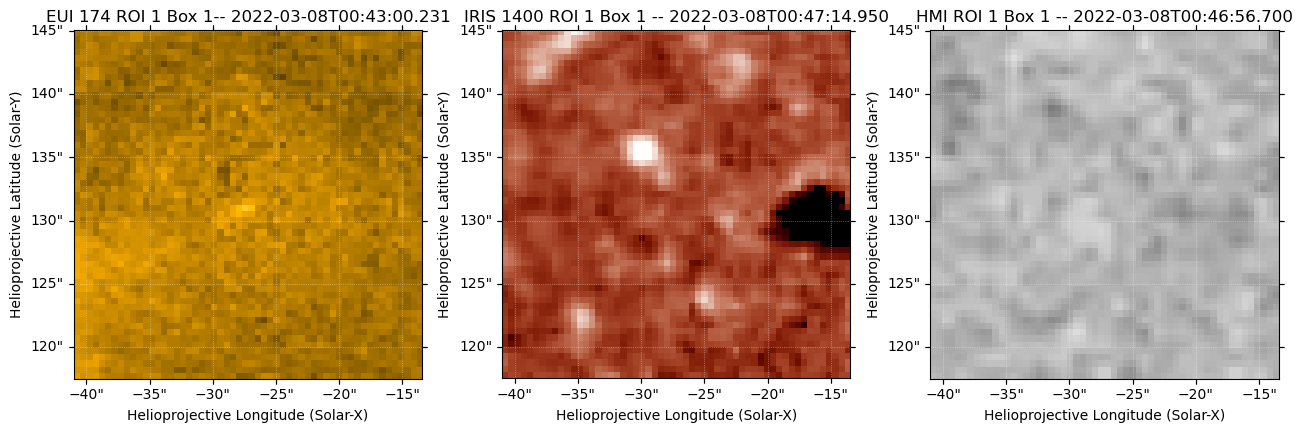

  2%|██▍                                                                                                                   | 1/49 [00:00<00:28,  1.70it/s]

<Figure size 640x480 with 0 Axes>

  4%|████▊                                                                                                                 | 2/49 [00:00<00:18,  2.60it/s]

<Figure size 640x480 with 0 Axes>

  6%|███████▏                                                                                                              | 3/49 [00:01<00:14,  3.11it/s]

<Figure size 640x480 with 0 Axes>

  8%|█████████▋                                                                                                            | 4/49 [00:01<00:13,  3.44it/s]

<Figure size 640x480 with 0 Axes>

 10%|████████████                                                                                                          | 5/49 [00:01<00:12,  3.61it/s]

<Figure size 640x480 with 0 Axes>

 12%|██████████████▍                                                                                                       | 6/49 [00:01<00:11,  3.71it/s]

<Figure size 640x480 with 0 Axes>

 14%|████████████████▊                                                                                                     | 7/49 [00:02<00:11,  3.76it/s]

<Figure size 640x480 with 0 Axes>

 16%|███████████████████▎                                                                                                  | 8/49 [00:02<00:10,  3.75it/s]

<Figure size 640x480 with 0 Axes>

 18%|█████████████████████▋                                                                                                | 9/49 [00:02<00:10,  3.78it/s]

<Figure size 640x480 with 0 Axes>

 20%|███████████████████████▉                                                                                             | 10/49 [00:03<00:17,  2.24it/s]

<Figure size 640x480 with 0 Axes>

 22%|██████████████████████████▎                                                                                          | 11/49 [00:03<00:14,  2.54it/s]

<Figure size 640x480 with 0 Axes>

 24%|████████████████████████████▋                                                                                        | 12/49 [00:04<00:13,  2.81it/s]

<Figure size 640x480 with 0 Axes>

 27%|███████████████████████████████                                                                                      | 13/49 [00:04<00:11,  3.03it/s]

<Figure size 640x480 with 0 Axes>

 29%|█████████████████████████████████▍                                                                                   | 14/49 [00:04<00:10,  3.19it/s]

<Figure size 640x480 with 0 Axes>

 31%|███████████████████████████████████▊                                                                                 | 15/49 [00:04<00:10,  3.31it/s]

<Figure size 640x480 with 0 Axes>

 33%|██████████████████████████████████████▏                                                                              | 16/49 [00:05<00:09,  3.38it/s]

<Figure size 640x480 with 0 Axes>

 35%|████████████████████████████████████████▌                                                                            | 17/49 [00:05<00:09,  3.46it/s]

<Figure size 640x480 with 0 Axes>

 37%|██████████████████████████████████████████▉                                                                          | 18/49 [00:05<00:08,  3.47it/s]

<Figure size 640x480 with 0 Axes>

 39%|█████████████████████████████████████████████▎                                                                       | 19/49 [00:05<00:08,  3.49it/s]

<Figure size 640x480 with 0 Axes>

 41%|███████████████████████████████████████████████▊                                                                     | 20/49 [00:06<00:08,  3.46it/s]

<Figure size 640x480 with 0 Axes>

 43%|██████████████████████████████████████████████████▏                                                                  | 21/49 [00:06<00:08,  3.46it/s]

<Figure size 640x480 with 0 Axes>

 45%|████████████████████████████████████████████████████▌                                                                | 22/49 [00:06<00:07,  3.47it/s]

<Figure size 640x480 with 0 Axes>

 47%|██████████████████████████████████████████████████████▉                                                              | 23/49 [00:07<00:07,  3.48it/s]

<Figure size 640x480 with 0 Axes>

 49%|█████████████████████████████████████████████████████████▎                                                           | 24/49 [00:07<00:07,  3.45it/s]

<Figure size 640x480 with 0 Axes>

 51%|███████████████████████████████████████████████████████████▋                                                         | 25/49 [00:07<00:06,  3.44it/s]

<Figure size 640x480 with 0 Axes>

 53%|██████████████████████████████████████████████████████████████                                                       | 26/49 [00:07<00:06,  3.42it/s]

<Figure size 640x480 with 0 Axes>

 55%|████████████████████████████████████████████████████████████████▍                                                    | 27/49 [00:08<00:06,  3.41it/s]

<Figure size 640x480 with 0 Axes>

 57%|██████████████████████████████████████████████████████████████████▊                                                  | 28/49 [00:08<00:06,  3.35it/s]

<Figure size 640x480 with 0 Axes>

 59%|█████████████████████████████████████████████████████████████████████▏                                               | 29/49 [00:08<00:05,  3.34it/s]

<Figure size 640x480 with 0 Axes>

 61%|███████████████████████████████████████████████████████████████████████▋                                             | 30/49 [00:09<00:05,  3.32it/s]

<Figure size 640x480 with 0 Axes>

 63%|██████████████████████████████████████████████████████████████████████████                                           | 31/49 [00:09<00:05,  3.31it/s]

<Figure size 640x480 with 0 Axes>

 65%|████████████████████████████████████████████████████████████████████████████▍                                        | 32/49 [00:09<00:05,  3.27it/s]

<Figure size 640x480 with 0 Axes>

 67%|██████████████████████████████████████████████████████████████████████████████▊                                      | 33/49 [00:10<00:04,  3.25it/s]

<Figure size 640x480 with 0 Axes>

 69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 34/49 [00:10<00:04,  3.23it/s]

<Figure size 640x480 with 0 Axes>

 71%|███████████████████████████████████████████████████████████████████████████████████▌                                 | 35/49 [00:10<00:04,  3.21it/s]

<Figure size 640x480 with 0 Axes>

 73%|█████████████████████████████████████████████████████████████████████████████████████▉                               | 36/49 [00:11<00:04,  3.18it/s]

<Figure size 640x480 with 0 Axes>

 76%|████████████████████████████████████████████████████████████████████████████████████████▎                            | 37/49 [00:11<00:03,  3.13it/s]

<Figure size 640x480 with 0 Axes>

 78%|██████████████████████████████████████████████████████████████████████████████████████████▋                          | 38/49 [00:11<00:03,  3.12it/s]

<Figure size 640x480 with 0 Axes>

 80%|█████████████████████████████████████████████████████████████████████████████████████████████                        | 39/49 [00:12<00:03,  3.11it/s]

<Figure size 640x480 with 0 Axes>

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                     | 40/49 [00:12<00:02,  3.09it/s]

<Figure size 640x480 with 0 Axes>

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 41/49 [00:12<00:02,  3.06it/s]

<Figure size 640x480 with 0 Axes>

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 42/49 [00:13<00:02,  3.04it/s]

<Figure size 640x480 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 43/49 [00:13<00:01,  3.01it/s]

<Figure size 640x480 with 0 Axes>

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 44/49 [00:13<00:01,  3.01it/s]

<Figure size 640x480 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 45/49 [00:14<00:01,  3.00it/s]

<Figure size 640x480 with 0 Axes>

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 46/49 [00:14<00:01,  2.92it/s]

<Figure size 640x480 with 0 Axes>

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 47/49 [00:14<00:00,  2.91it/s]

<Figure size 640x480 with 0 Axes>

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 48/49 [00:15<00:00,  2.91it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:15<00:00,  3.16it/s]


In [66]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_1_box_1_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_1_trimmed_box_1))):

        eui_map = eui_roi_1_trimmed_box_1[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 1 Box 1-- {eui174_matched[frame_ind_box_1[i]].date}')

        iris_map = iris_roi_1_trimmed_box_1[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 1 Box 1 -- {iris1400_matched[frame_ind_box_1[i]].date}')

        hmi_map = hmi_roi_1_trimmed_box_1[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 1 Box 1 -- {hmi_matched[frame_ind_box_1[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/36 [00:00<?, ?it/s]

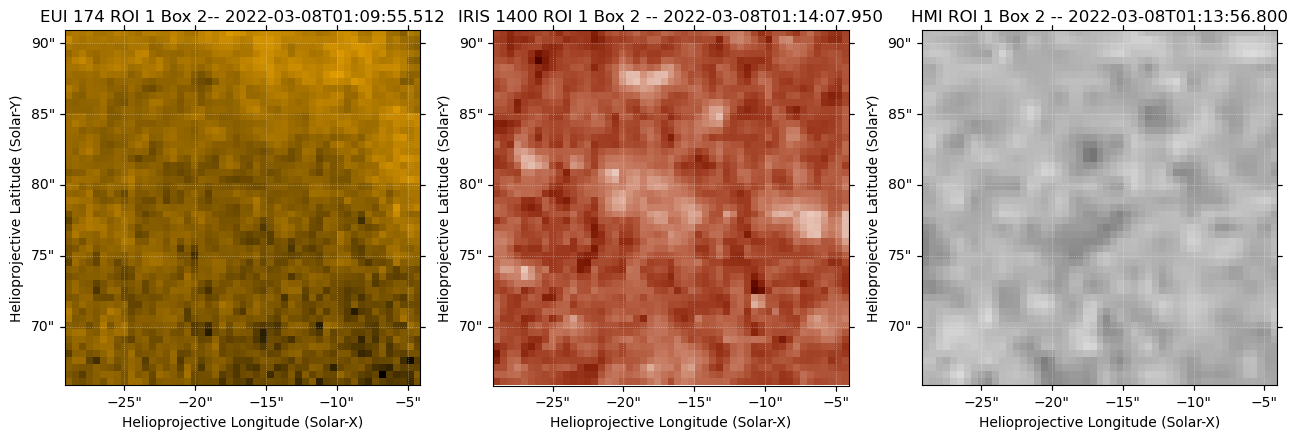

  3%|███▎                                                                                                                  | 1/36 [00:00<00:17,  1.96it/s]

<Figure size 640x480 with 0 Axes>

  6%|██████▌                                                                                                               | 2/36 [00:00<00:11,  2.85it/s]

<Figure size 640x480 with 0 Axes>

  8%|█████████▊                                                                                                            | 3/36 [00:00<00:09,  3.32it/s]

<Figure size 640x480 with 0 Axes>

 11%|█████████████                                                                                                         | 4/36 [00:01<00:08,  3.57it/s]

<Figure size 640x480 with 0 Axes>

 14%|████████████████▍                                                                                                     | 5/36 [00:01<00:08,  3.71it/s]

<Figure size 640x480 with 0 Axes>

 17%|███████████████████▋                                                                                                  | 6/36 [00:01<00:07,  3.81it/s]

<Figure size 640x480 with 0 Axes>

 19%|██████████████████████▉                                                                                               | 7/36 [00:01<00:07,  3.86it/s]

<Figure size 640x480 with 0 Axes>

 22%|██████████████████████████▏                                                                                           | 8/36 [00:02<00:07,  3.89it/s]

<Figure size 640x480 with 0 Axes>

 25%|█████████████████████████████▌                                                                                        | 9/36 [00:02<00:06,  3.86it/s]

<Figure size 640x480 with 0 Axes>

 28%|████████████████████████████████▌                                                                                    | 10/36 [00:02<00:06,  3.87it/s]

<Figure size 640x480 with 0 Axes>

 31%|███████████████████████████████████▊                                                                                 | 11/36 [00:03<00:06,  3.87it/s]

<Figure size 640x480 with 0 Axes>

 33%|███████████████████████████████████████                                                                              | 12/36 [00:03<00:06,  3.87it/s]

<Figure size 640x480 with 0 Axes>

 36%|██████████████████████████████████████████▎                                                                          | 13/36 [00:03<00:06,  3.83it/s]

<Figure size 640x480 with 0 Axes>

 39%|█████████████████████████████████████████████▌                                                                       | 14/36 [00:03<00:05,  3.80it/s]

<Figure size 640x480 with 0 Axes>

 42%|████████████████████████████████████████████████▊                                                                    | 15/36 [00:04<00:05,  3.76it/s]

<Figure size 640x480 with 0 Axes>

 44%|████████████████████████████████████████████████████                                                                 | 16/36 [00:04<00:05,  3.74it/s]

<Figure size 640x480 with 0 Axes>

 47%|███████████████████████████████████████████████████████▎                                                             | 17/36 [00:04<00:05,  3.71it/s]

<Figure size 640x480 with 0 Axes>

 50%|██████████████████████████████████████████████████████████▌                                                          | 18/36 [00:04<00:04,  3.69it/s]

<Figure size 640x480 with 0 Axes>

 53%|█████████████████████████████████████████████████████████████▊                                                       | 19/36 [00:05<00:04,  3.67it/s]

<Figure size 640x480 with 0 Axes>

 56%|█████████████████████████████████████████████████████████████████                                                    | 20/36 [00:05<00:04,  3.65it/s]

<Figure size 640x480 with 0 Axes>

 58%|████████████████████████████████████████████████████████████████████▎                                                | 21/36 [00:05<00:04,  3.62it/s]

<Figure size 640x480 with 0 Axes>

 61%|███████████████████████████████████████████████████████████████████████▌                                             | 22/36 [00:06<00:03,  3.59it/s]

<Figure size 640x480 with 0 Axes>

 64%|██████████████████████████████████████████████████████████████████████████▊                                          | 23/36 [00:06<00:03,  3.55it/s]

<Figure size 640x480 with 0 Axes>

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 24/36 [00:06<00:03,  3.52it/s]

<Figure size 640x480 with 0 Axes>

 69%|█████████████████████████████████████████████████████████████████████████████████▎                                   | 25/36 [00:06<00:03,  3.50it/s]

<Figure size 640x480 with 0 Axes>

 72%|████████████████████████████████████████████████████████████████████████████████████▌                                | 26/36 [00:07<00:02,  3.45it/s]

<Figure size 640x480 with 0 Axes>

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 27/36 [00:07<00:02,  3.42it/s]

<Figure size 640x480 with 0 Axes>

 78%|███████████████████████████████████████████████████████████████████████████████████████████                          | 28/36 [00:07<00:02,  3.39it/s]

<Figure size 640x480 with 0 Axes>

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                      | 29/36 [00:08<00:02,  3.36it/s]

<Figure size 640x480 with 0 Axes>

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 30/36 [00:08<00:01,  3.34it/s]

<Figure size 640x480 with 0 Axes>

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 31/36 [00:08<00:01,  3.30it/s]

<Figure size 640x480 with 0 Axes>

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████             | 32/36 [00:09<00:01,  3.28it/s]

<Figure size 640x480 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 33/36 [00:09<00:00,  3.26it/s]

<Figure size 640x480 with 0 Axes>

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 34/36 [00:09<00:00,  3.25it/s]

<Figure size 640x480 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 35/36 [00:09<00:00,  3.22it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.50it/s]


In [52]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_1_box_2_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_1_trimmed_box_2))):

        eui_map = eui_roi_1_trimmed_box_2[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 1 Box 2-- {eui174_matched[frame_ind_box_2[i]].date}')

        iris_map = iris_roi_1_trimmed_box_2[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 1 Box 2 -- {iris1400_matched[frame_ind_box_2[i]].date}')

        hmi_map = hmi_roi_1_trimmed_box_2[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 1 Box 2 -- {hmi_matched[frame_ind_box_2[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/36 [00:00<?, ?it/s]

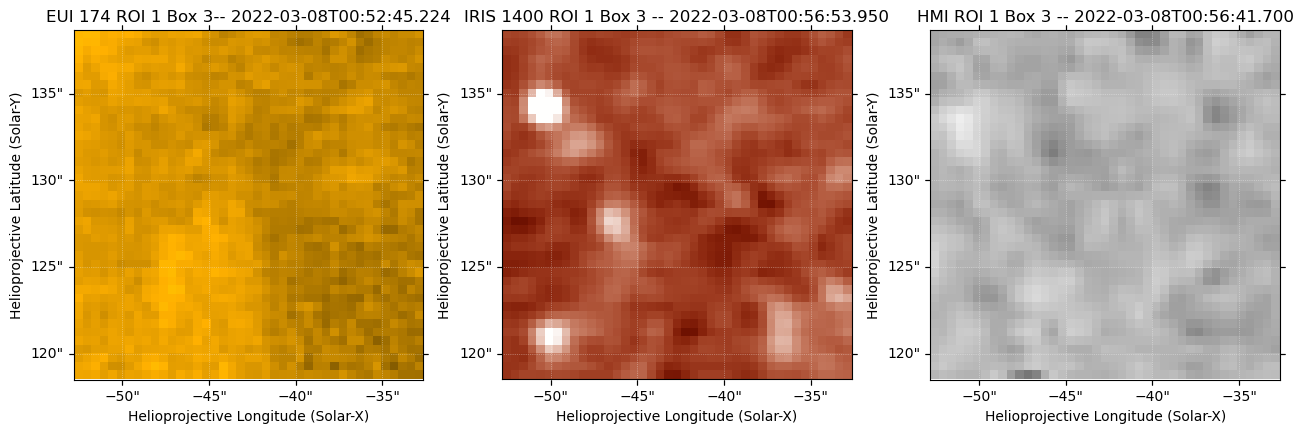

  3%|███▎                                                                                                                  | 1/36 [00:00<00:17,  2.02it/s]

<Figure size 640x480 with 0 Axes>

  6%|██████▌                                                                                                               | 2/36 [00:00<00:11,  2.90it/s]

<Figure size 640x480 with 0 Axes>

  8%|█████████▊                                                                                                            | 3/36 [00:00<00:09,  3.38it/s]

<Figure size 640x480 with 0 Axes>

 11%|█████████████                                                                                                         | 4/36 [00:01<00:08,  3.65it/s]

<Figure size 640x480 with 0 Axes>

 14%|████████████████▍                                                                                                     | 5/36 [00:01<00:08,  3.79it/s]

<Figure size 640x480 with 0 Axes>

 17%|███████████████████▋                                                                                                  | 6/36 [00:01<00:07,  3.91it/s]

<Figure size 640x480 with 0 Axes>

 19%|██████████████████████▉                                                                                               | 7/36 [00:02<00:12,  2.33it/s]

<Figure size 640x480 with 0 Axes>

 22%|██████████████████████████▏                                                                                           | 8/36 [00:02<00:10,  2.71it/s]

<Figure size 640x480 with 0 Axes>

 25%|█████████████████████████████▌                                                                                        | 9/36 [00:02<00:08,  3.02it/s]

<Figure size 640x480 with 0 Axes>

 28%|████████████████████████████████▌                                                                                    | 10/36 [00:03<00:08,  3.24it/s]

<Figure size 640x480 with 0 Axes>

 31%|███████████████████████████████████▊                                                                                 | 11/36 [00:03<00:07,  3.42it/s]

<Figure size 640x480 with 0 Axes>

 33%|███████████████████████████████████████                                                                              | 12/36 [00:03<00:06,  3.55it/s]

<Figure size 640x480 with 0 Axes>

 36%|██████████████████████████████████████████▎                                                                          | 13/36 [00:04<00:06,  3.64it/s]

<Figure size 640x480 with 0 Axes>

 39%|█████████████████████████████████████████████▌                                                                       | 14/36 [00:04<00:05,  3.68it/s]

<Figure size 640x480 with 0 Axes>

 42%|████████████████████████████████████████████████▊                                                                    | 15/36 [00:04<00:05,  3.73it/s]

<Figure size 640x480 with 0 Axes>

 44%|████████████████████████████████████████████████████                                                                 | 16/36 [00:04<00:05,  3.73it/s]

<Figure size 640x480 with 0 Axes>

 47%|███████████████████████████████████████████████████████▎                                                             | 17/36 [00:05<00:05,  3.74it/s]

<Figure size 640x480 with 0 Axes>

 50%|██████████████████████████████████████████████████████████▌                                                          | 18/36 [00:05<00:04,  3.72it/s]

<Figure size 640x480 with 0 Axes>

 53%|█████████████████████████████████████████████████████████████▊                                                       | 19/36 [00:05<00:04,  3.67it/s]

<Figure size 640x480 with 0 Axes>

 56%|█████████████████████████████████████████████████████████████████                                                    | 20/36 [00:05<00:04,  3.60it/s]

<Figure size 640x480 with 0 Axes>

 58%|████████████████████████████████████████████████████████████████████▎                                                | 21/36 [00:06<00:04,  3.56it/s]

<Figure size 640x480 with 0 Axes>

 61%|███████████████████████████████████████████████████████████████████████▌                                             | 22/36 [00:06<00:03,  3.58it/s]

<Figure size 640x480 with 0 Axes>

 64%|██████████████████████████████████████████████████████████████████████████▊                                          | 23/36 [00:06<00:03,  3.57it/s]

<Figure size 640x480 with 0 Axes>

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 24/36 [00:07<00:03,  3.56it/s]

<Figure size 640x480 with 0 Axes>

 69%|█████████████████████████████████████████████████████████████████████████████████▎                                   | 25/36 [00:07<00:03,  3.53it/s]

<Figure size 640x480 with 0 Axes>

 72%|████████████████████████████████████████████████████████████████████████████████████▌                                | 26/36 [00:07<00:02,  3.43it/s]

<Figure size 640x480 with 0 Axes>

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 27/36 [00:07<00:02,  3.34it/s]

<Figure size 640x480 with 0 Axes>

 78%|███████████████████████████████████████████████████████████████████████████████████████████                          | 28/36 [00:08<00:02,  3.33it/s]

<Figure size 640x480 with 0 Axes>

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                      | 29/36 [00:08<00:02,  3.35it/s]

<Figure size 640x480 with 0 Axes>

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 30/36 [00:08<00:01,  3.32it/s]

<Figure size 640x480 with 0 Axes>

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 31/36 [00:09<00:01,  3.33it/s]

<Figure size 640x480 with 0 Axes>

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████             | 32/36 [00:09<00:01,  3.31it/s]

<Figure size 640x480 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 33/36 [00:09<00:00,  3.31it/s]

<Figure size 640x480 with 0 Axes>

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 34/36 [00:10<00:00,  3.29it/s]

<Figure size 640x480 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 35/36 [00:10<00:00,  3.27it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.37it/s]


In [53]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_1_box_3_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_1_trimmed_box_3))):

        eui_map = eui_roi_1_trimmed_box_3[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 1 Box 3-- {eui174_matched[frame_ind_box_3[i]].date}')

        iris_map = iris_roi_1_trimmed_box_3[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 1 Box 3 -- {iris1400_matched[frame_ind_box_3[i]].date}')

        hmi_map = hmi_roi_1_trimmed_box_3[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 1 Box 3 -- {hmi_matched[frame_ind_box_3[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/24 [00:00<?, ?it/s]

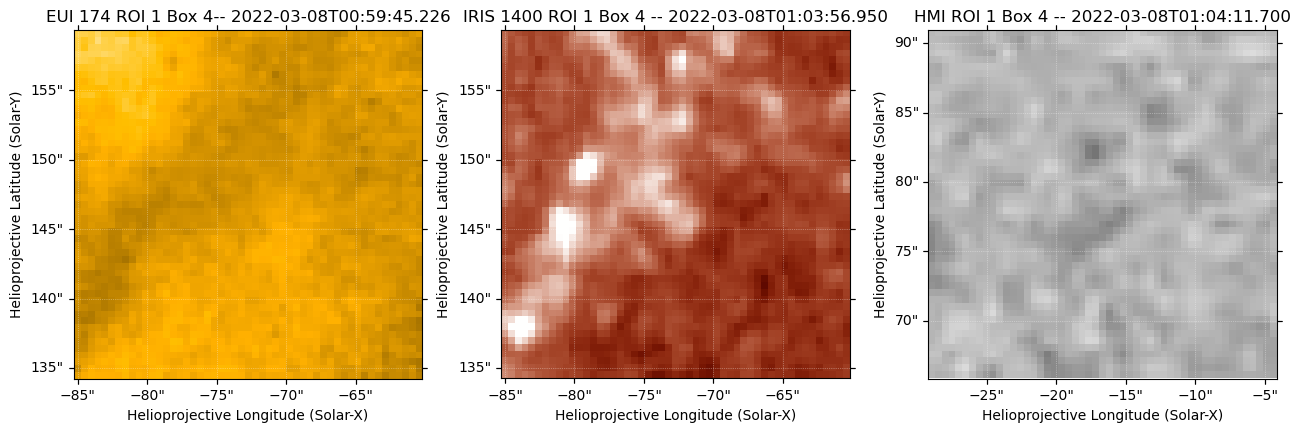

  4%|████▉                                                                                                                 | 1/24 [00:00<00:11,  2.09it/s]

<Figure size 640x480 with 0 Axes>

  8%|█████████▊                                                                                                            | 2/24 [00:00<00:07,  2.94it/s]

<Figure size 640x480 with 0 Axes>

 12%|██████████████▊                                                                                                       | 3/24 [00:00<00:06,  3.41it/s]

<Figure size 640x480 with 0 Axes>

 17%|███████████████████▋                                                                                                  | 4/24 [00:01<00:05,  3.64it/s]

<Figure size 640x480 with 0 Axes>

 21%|████████████████████████▌                                                                                             | 5/24 [00:01<00:05,  3.78it/s]

<Figure size 640x480 with 0 Axes>

 25%|█████████████████████████████▌                                                                                        | 6/24 [00:01<00:04,  3.87it/s]

<Figure size 640x480 with 0 Axes>

 29%|██████████████████████████████████▍                                                                                   | 7/24 [00:01<00:04,  3.93it/s]

<Figure size 640x480 with 0 Axes>

 33%|███████████████████████████████████████▎                                                                              | 8/24 [00:02<00:04,  3.93it/s]

<Figure size 640x480 with 0 Axes>

 38%|████████████████████████████████████████████▎                                                                         | 9/24 [00:02<00:03,  3.92it/s]

<Figure size 640x480 with 0 Axes>

 42%|████████████████████████████████████████████████▊                                                                    | 10/24 [00:02<00:03,  3.92it/s]

<Figure size 640x480 with 0 Axes>

 46%|█████████████████████████████████████████████████████▋                                                               | 11/24 [00:02<00:03,  3.90it/s]

<Figure size 640x480 with 0 Axes>

 50%|██████████████████████████████████████████████████████████▌                                                          | 12/24 [00:03<00:03,  3.87it/s]

<Figure size 640x480 with 0 Axes>

 54%|███████████████████████████████████████████████████████████████▎                                                     | 13/24 [00:03<00:02,  3.84it/s]

<Figure size 640x480 with 0 Axes>

 58%|████████████████████████████████████████████████████████████████████▎                                                | 14/24 [00:03<00:02,  3.82it/s]

<Figure size 640x480 with 0 Axes>

 62%|█████████████████████████████████████████████████████████████████████████▏                                           | 15/24 [00:04<00:02,  3.80it/s]

<Figure size 640x480 with 0 Axes>

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 16/24 [00:04<00:02,  3.77it/s]

<Figure size 640x480 with 0 Axes>

 71%|██████████████████████████████████████████████████████████████████████████████████▉                                  | 17/24 [00:05<00:02,  2.46it/s]

<Figure size 640x480 with 0 Axes>

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 18/24 [00:05<00:02,  2.66it/s]

<Figure size 640x480 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                        | 19/24 [00:05<00:01,  2.86it/s]

<Figure size 640x480 with 0 Axes>

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 20/24 [00:05<00:01,  3.01it/s]

<Figure size 640x480 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21/24 [00:06<00:00,  3.15it/s]

<Figure size 640x480 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 22/24 [00:06<00:00,  3.25it/s]

<Figure size 640x480 with 0 Axes>

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 23/24 [00:06<00:00,  3.32it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.39it/s]


In [56]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_1_box_4_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_1_trimmed_box_4))):

        eui_map = eui_roi_1_trimmed_box_4[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=500, vmax=1500, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 1 Box 4-- {eui174_matched[frame_ind_box_4[i]].date}')

        iris_map = iris_roi_1_trimmed_box_4[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 1 Box 4 -- {iris1400_matched[frame_ind_box_4[i]].date}')

        hmi_map = hmi_roi_1_trimmed_box_2[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 1 Box 4 -- {hmi_matched[frame_ind_box_4[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/23 [00:00<?, ?it/s]

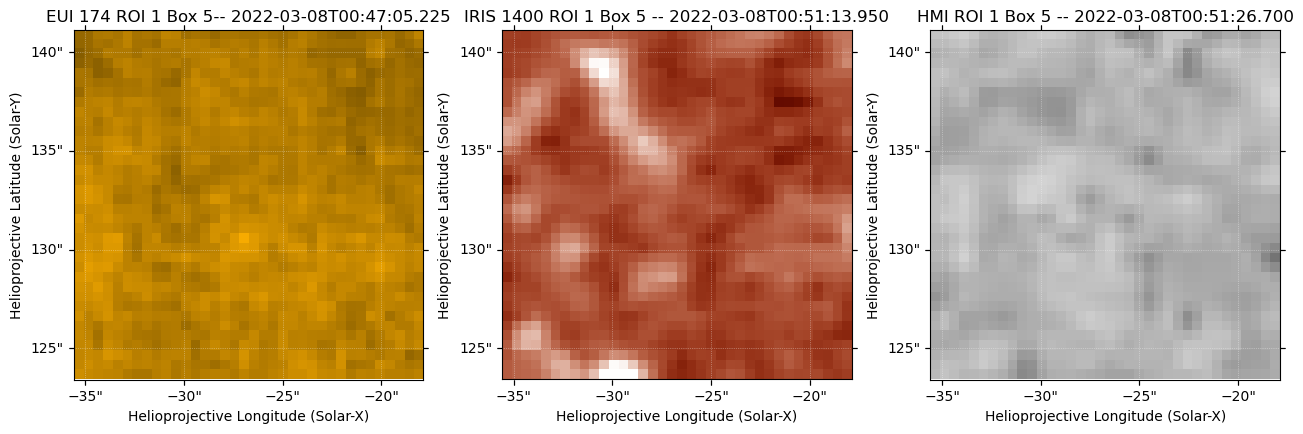

  4%|█████▏                                                                                                                | 1/23 [00:00<00:11,  1.85it/s]

<Figure size 640x480 with 0 Axes>

  9%|██████████▎                                                                                                           | 2/23 [00:00<00:07,  2.77it/s]

<Figure size 640x480 with 0 Axes>

 13%|███████████████▍                                                                                                      | 3/23 [00:01<00:06,  3.29it/s]

<Figure size 640x480 with 0 Axes>

 17%|████████████████████▌                                                                                                 | 4/23 [00:01<00:05,  3.59it/s]

<Figure size 640x480 with 0 Axes>

 22%|█████████████████████████▋                                                                                            | 5/23 [00:01<00:04,  3.75it/s]

<Figure size 640x480 with 0 Axes>

 26%|██████████████████████████████▊                                                                                       | 6/23 [00:01<00:04,  3.85it/s]

<Figure size 640x480 with 0 Axes>

 30%|███████████████████████████████████▉                                                                                  | 7/23 [00:01<00:04,  3.92it/s]

<Figure size 640x480 with 0 Axes>

 35%|█████████████████████████████████████████                                                                             | 8/23 [00:02<00:03,  3.94it/s]

<Figure size 640x480 with 0 Axes>

 39%|██████████████████████████████████████████████▏                                                                       | 9/23 [00:02<00:03,  3.95it/s]

<Figure size 640x480 with 0 Axes>

 43%|██████████████████████████████████████████████████▊                                                                  | 10/23 [00:02<00:03,  3.93it/s]

<Figure size 640x480 with 0 Axes>

 48%|███████████████████████████████████████████████████████▉                                                             | 11/23 [00:03<00:03,  3.93it/s]

<Figure size 640x480 with 0 Axes>

 52%|█████████████████████████████████████████████████████████████                                                        | 12/23 [00:03<00:02,  3.93it/s]

<Figure size 640x480 with 0 Axes>

 57%|██████████████████████████████████████████████████████████████████▏                                                  | 13/23 [00:03<00:02,  3.91it/s]

<Figure size 640x480 with 0 Axes>

 61%|███████████████████████████████████████████████████████████████████████▏                                             | 14/23 [00:03<00:02,  3.86it/s]

<Figure size 640x480 with 0 Axes>

 65%|████████████████████████████████████████████████████████████████████████████▎                                        | 15/23 [00:04<00:02,  3.83it/s]

<Figure size 640x480 with 0 Axes>

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                   | 16/23 [00:04<00:01,  3.81it/s]

<Figure size 640x480 with 0 Axes>

 74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 17/23 [00:04<00:01,  3.78it/s]

<Figure size 640x480 with 0 Axes>

 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                         | 18/23 [00:04<00:01,  3.76it/s]

<Figure size 640x480 with 0 Axes>

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 19/23 [00:05<00:01,  3.74it/s]

<Figure size 640x480 with 0 Axes>

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 20/23 [00:05<00:00,  3.71it/s]

<Figure size 640x480 with 0 Axes>

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 21/23 [00:05<00:00,  3.68it/s]

<Figure size 640x480 with 0 Axes>

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 22/23 [00:05<00:00,  3.64it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.69it/s]


In [57]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_1_box_5_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_1_trimmed_box_5))):

        eui_map = eui_roi_1_trimmed_box_5[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 1 Box 5-- {eui174_matched[frame_ind_box_5[i]].date}')

        iris_map = iris_roi_1_trimmed_box_5[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 1 Box 5 -- {iris1400_matched[frame_ind_box_5[i]].date}')

        hmi_map = hmi_roi_1_trimmed_box_5[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 1 Box 5 -- {hmi_matched[frame_ind_box_5[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/13 [00:00<?, ?it/s]

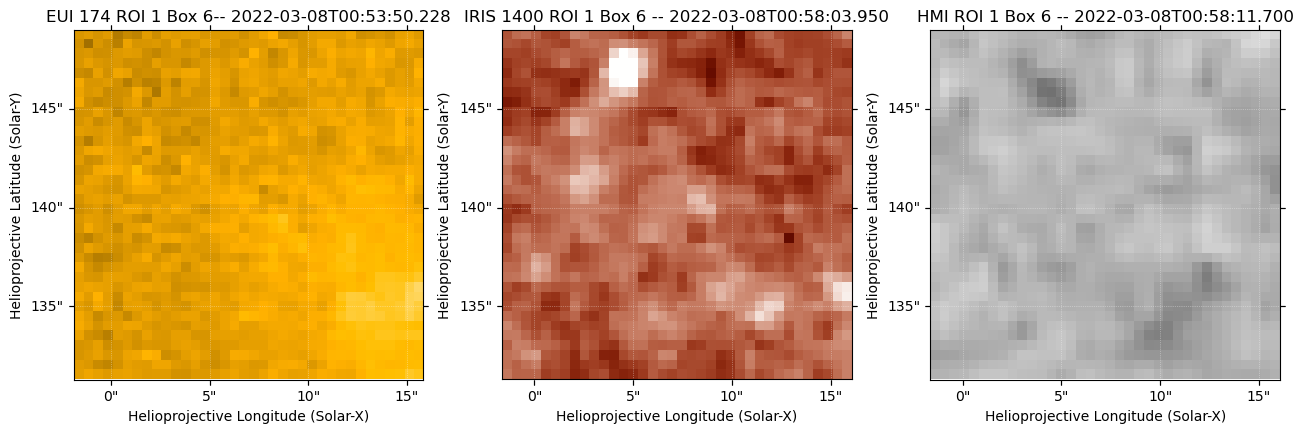

  8%|█████████                                                                                                             | 1/13 [00:00<00:06,  1.75it/s]

<Figure size 640x480 with 0 Axes>

 15%|██████████████████▏                                                                                                   | 2/13 [00:00<00:04,  2.66it/s]

<Figure size 640x480 with 0 Axes>

 23%|███████████████████████████▏                                                                                          | 3/13 [00:01<00:03,  3.21it/s]

<Figure size 640x480 with 0 Axes>

 31%|████████████████████████████████████▎                                                                                 | 4/13 [00:01<00:02,  3.50it/s]

<Figure size 640x480 with 0 Axes>

 38%|█████████████████████████████████████████████▍                                                                        | 5/13 [00:01<00:02,  3.72it/s]

<Figure size 640x480 with 0 Axes>

 46%|██████████████████████████████████████████████████████▍                                                               | 6/13 [00:01<00:01,  3.84it/s]

<Figure size 640x480 with 0 Axes>

 54%|███████████████████████████████████████████████████████████████▌                                                      | 7/13 [00:02<00:01,  3.92it/s]

<Figure size 640x480 with 0 Axes>

 62%|████████████████████████████████████████████████████████████████████████▌                                             | 8/13 [00:02<00:01,  3.96it/s]

<Figure size 640x480 with 0 Axes>

 69%|█████████████████████████████████████████████████████████████████████████████████▋                                    | 9/13 [00:02<00:01,  3.98it/s]

<Figure size 640x480 with 0 Axes>

 77%|██████████████████████████████████████████████████████████████████████████████████████████                           | 10/13 [00:02<00:00,  3.98it/s]

<Figure size 640x480 with 0 Axes>

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 11/13 [00:03<00:00,  3.83it/s]

<Figure size 640x480 with 0 Axes>

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 12/13 [00:03<00:00,  3.79it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.62it/s]


In [58]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_1_box_6_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_1_trimmed_box_6))):

        eui_map = eui_roi_1_trimmed_box_6[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=300, vmax=900, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 1 Box 6-- {eui174_matched[frame_ind_box_6[i]].date}')

        iris_map = iris_roi_1_trimmed_box_6[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 1 Box 6 -- {iris1400_matched[frame_ind_box_6[i]].date}')

        hmi_map = hmi_roi_1_trimmed_box_6[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 1 Box 6 -- {hmi_matched[frame_ind_box_6[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                               | 0/6 [00:00<?, ?it/s]

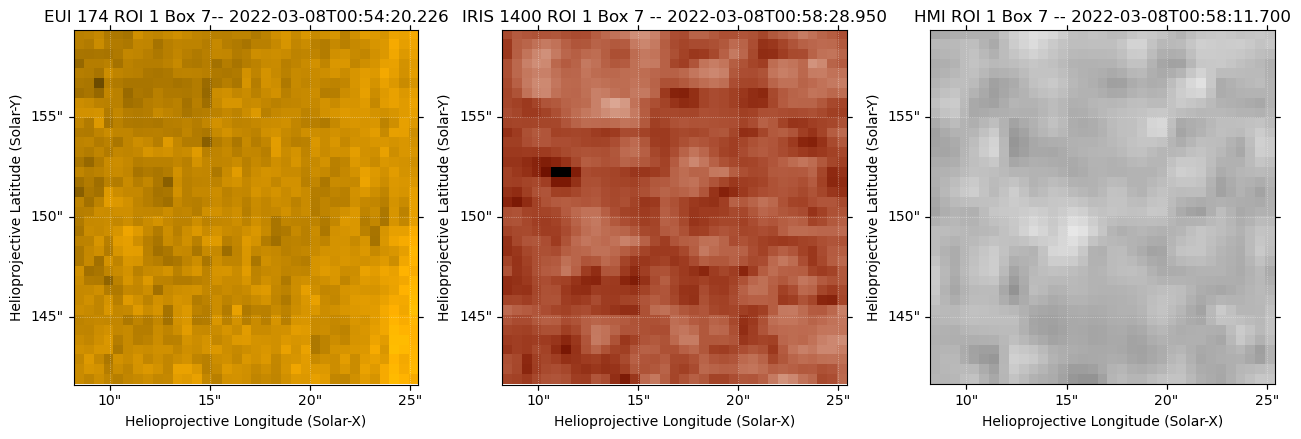

 17%|███████████████████▊                                                                                                   | 1/6 [00:00<00:02,  2.01it/s]

<Figure size 640x480 with 0 Axes>

 33%|███████████████████████████████████████▋                                                                               | 2/6 [00:00<00:01,  2.92it/s]

<Figure size 640x480 with 0 Axes>

 50%|███████████████████████████████████████████████████████████▌                                                           | 3/6 [00:00<00:00,  3.38it/s]

<Figure size 640x480 with 0 Axes>

 67%|███████████████████████████████████████████████████████████████████████████████▎                                       | 4/6 [00:01<00:00,  3.62it/s]

<Figure size 640x480 with 0 Axes>

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5/6 [00:02<00:00,  2.14it/s]

<Figure size 640x480 with 0 Axes>

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.65it/s]


In [59]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_1_box_7_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_1_trimmed_box_7))):

        eui_map = eui_roi_1_trimmed_box_7[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 1 Box 7-- {eui174_matched[frame_ind_box_7[i]].date}')

        iris_map = iris_roi_1_trimmed_box_7[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 1 Box 7 -- {iris1400_matched[frame_ind_box_7[i]].date}')

        hmi_map = hmi_roi_1_trimmed_box_7[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 1 Box 7 -- {hmi_matched[frame_ind_box_7[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/19 [00:00<?, ?it/s]

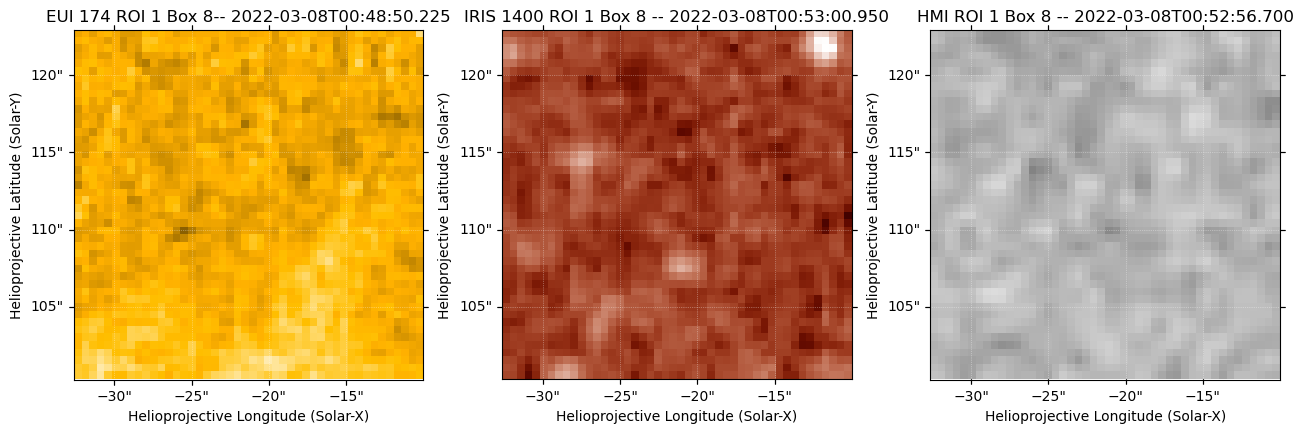

  5%|██████▏                                                                                                               | 1/19 [00:00<00:09,  1.94it/s]

<Figure size 640x480 with 0 Axes>

 11%|████████████▍                                                                                                         | 2/19 [00:00<00:05,  2.84it/s]

<Figure size 640x480 with 0 Axes>

 16%|██████████████████▋                                                                                                   | 3/19 [00:00<00:04,  3.37it/s]

<Figure size 640x480 with 0 Axes>

 21%|████████████████████████▊                                                                                             | 4/19 [00:01<00:04,  3.66it/s]

<Figure size 640x480 with 0 Axes>

 26%|███████████████████████████████                                                                                       | 5/19 [00:01<00:03,  3.84it/s]

<Figure size 640x480 with 0 Axes>

 32%|█████████████████████████████████████▎                                                                                | 6/19 [00:01<00:03,  3.95it/s]

<Figure size 640x480 with 0 Axes>

 37%|███████████████████████████████████████████▍                                                                          | 7/19 [00:01<00:02,  4.01it/s]

<Figure size 640x480 with 0 Axes>

 42%|█████████████████████████████████████████████████▋                                                                    | 8/19 [00:02<00:02,  4.04it/s]

<Figure size 640x480 with 0 Axes>

 47%|███████████████████████████████████████████████████████▉                                                              | 9/19 [00:02<00:02,  4.04it/s]

<Figure size 640x480 with 0 Axes>

 53%|█████████████████████████████████████████████████████████████▌                                                       | 10/19 [00:02<00:02,  4.00it/s]

<Figure size 640x480 with 0 Axes>

 58%|███████████████████████████████████████████████████████████████████▋                                                 | 11/19 [00:02<00:02,  3.98it/s]

<Figure size 640x480 with 0 Axes>

 63%|█████████████████████████████████████████████████████████████████████████▉                                           | 12/19 [00:03<00:01,  3.95it/s]

<Figure size 640x480 with 0 Axes>

 68%|████████████████████████████████████████████████████████████████████████████████                                     | 13/19 [00:03<00:01,  3.94it/s]

<Figure size 640x480 with 0 Axes>

 74%|██████████████████████████████████████████████████████████████████████████████████████▏                              | 14/19 [00:03<00:01,  3.90it/s]

<Figure size 640x480 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/19 [00:03<00:01,  3.85it/s]

<Figure size 640x480 with 0 Axes>

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 16/19 [00:04<00:00,  3.81it/s]

<Figure size 640x480 with 0 Axes>

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17/19 [00:04<00:00,  3.74it/s]

<Figure size 640x480 with 0 Axes>

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18/19 [00:04<00:00,  3.68it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.74it/s]


In [64]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_1_box_8_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_1_trimmed_box_8))):

        eui_map = eui_roi_1_trimmed_box_8[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=650, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 1 Box 8-- {eui174_matched[frame_ind_box_8[i]].date}')

        iris_map = iris_roi_1_trimmed_box_8[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 1 Box 8 -- {iris1400_matched[frame_ind_box_8[i]].date}')

        hmi_map = hmi_roi_1_trimmed_box_8[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 1 Box 8 -- {hmi_matched[frame_ind_box_8[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                               | 0/6 [00:00<?, ?it/s]

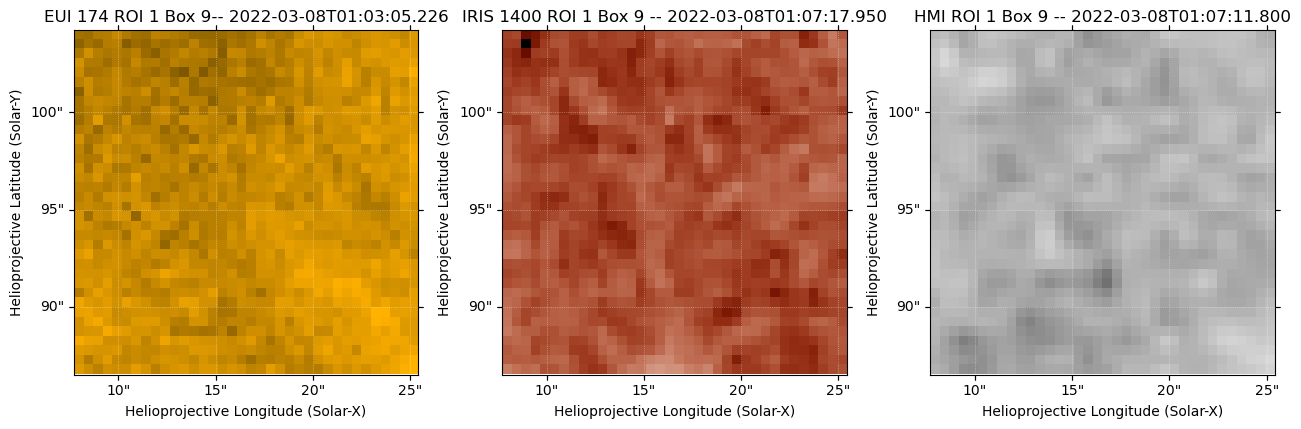

 17%|███████████████████▊                                                                                                   | 1/6 [00:00<00:02,  2.12it/s]

<Figure size 640x480 with 0 Axes>

 33%|███████████████████████████████████████▋                                                                               | 2/6 [00:00<00:01,  3.01it/s]

<Figure size 640x480 with 0 Axes>

 50%|███████████████████████████████████████████████████████████▌                                                           | 3/6 [00:00<00:00,  3.44it/s]

<Figure size 640x480 with 0 Axes>

 67%|███████████████████████████████████████████████████████████████████████████████▎                                       | 4/6 [00:01<00:00,  3.69it/s]

<Figure size 640x480 with 0 Axes>

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5/6 [00:01<00:00,  3.83it/s]

<Figure size 640x480 with 0 Axes>

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.57it/s]


In [61]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_1_box_9_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_1_trimmed_box_9))):

        eui_map = eui_roi_1_trimmed_box_9[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 1 Box 9-- {eui174_matched[frame_ind_box_9[i]].date}')

        iris_map = iris_roi_1_trimmed_box_9[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 1 Box 9 -- {iris1400_matched[frame_ind_box_9[i]].date}')

        hmi_map = hmi_roi_1_trimmed_box_9[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 1 Box 9 -- {hmi_matched[frame_ind_box_9[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

![SegmentLocal](gifs/eui_iris_hmi_roi_1_box_1_interval1.gif "ROI 1 Box 1")
![SegmentLocal](gifs/eui_iris_hmi_roi_1_box_2_interval1.gif "ROI 1 Box 2")
![SegmentLocal](gifs/eui_iris_hmi_roi_1_box_3_interval1.gif "ROI 1 Box 3")
![SegmentLocal](gifs/eui_iris_hmi_roi_1_box_4_interval1.gif "ROI 1 Box 4")
![SegmentLocal](gifs/eui_iris_hmi_roi_1_box_5_interval1.gif "ROI 1 Box 5")
![SegmentLocal](gifs/eui_iris_hmi_roi_1_box_6_interval1.gif "ROI 1 Box 6")
![SegmentLocal](gifs/eui_iris_hmi_roi_1_box_7_interval1.gif "ROI 1 Box 7")
![SegmentLocal](gifs/eui_iris_hmi_roi_1_box_8_interval1.gif "ROI 1 Box 8")
![SegmentLocal](gifs/eui_iris_hmi_roi_1_box_9_interval1.gif "ROI 1 Box 9")

---
# ROI 2

View side-by-side movie for ROI 2...

![SegmentLocal](gifs/eui_and_hmi_and_iris_roi_2_interval1.gif "EUI, HMI, and IRIS ROI 2")

Use interactive plot to investigate brightenings and their coordinates...

In [80]:
# add for faster transitions between frames (does not show cursor coords)
%matplotlib inline 

# define function for updating maps with boxes
def show_frame_with_boxes_roi_2(i):
    eui_map = eui_aligned_shifted_roi_2[i]
    iris_map = iris1400_aligned_roi_2[i]
    hmi_map = hmi_aligned_roi_2[i]

    eui_norm = ImageNormalize(eui_map.data, vmin=300, vmax=1300, stretch=SqrtStretch())
    iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=15, stretch=SqrtStretch())
    hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
    
    fig = plt.figure(figsize=(13, 5))

    ax1 = fig.add_subplot(131, projection=eui_map.wcs)
    eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', title=f'EUI 174 -- {eui174_matched[i].date}')

    ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
    iris_map.plot(axes=ax2, norm=iris_norm, title=f'IRIS 1400 -- {iris1400_matched[i].date}')

    ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
    hmi_map.plot(axes=ax3, norm=hmi_norm, title=f'HMI LOS Magnetogram -- {hmi_matched[i].date}')

    ax1.set_xlim(15, 345)
    ax1.set_ylim(30, 360)

# draw and label boxes...
    boxes = [
        {'xs': [50, 80], 'ys': [165, 195], 'label': '1'},
        {'xs': [183, 233], 'ys': [117, 167], 'label': '2'},
        {'xs': [272, 302], 'ys': [130, 160], 'label': '3'},
        {'xs': [29, 59], 'ys': [262, 292], 'label': '4'},
        {'xs': [43, 88], 'ys': [163, 208], 'label': '5'},
        {'xs': [177, 207], 'ys': [243, 273], 'label': '6'},
        {'xs': [100, 170], 'ys': [250, 320], 'label': '7'},
        {'xs': [149, 179], 'ys': [272, 302], 'label': '8'},
        {'xs': [141, 171], 'ys': [101, 131], 'label': '9'},
        {'xs': [164, 194], 'ys': [143, 173], 'label': '10'},
        {'xs': [86, 126], 'ys': [170, 210], 'label': '11'},
        {'xs': [105, 135], 'ys': [130, 160], 'label': '12'},
        {'xs': [201, 236], 'ys': [169, 204], 'label': '13'},
        {'xs': [172, 202], 'ys': [288, 318], 'label': '14'},
        {'xs': [30, 65], 'ys': [324, 359], 'label': '15'}
    ]

    for box in boxes:
        x0, x1 = box['xs']
        y0, y1 = box['ys']
        w = x1 - x0
        h = y1 - y0
        label = box['label']

        for ax in [ax1, ax2, ax3]:
            rect = plt.Rectangle((x0, y0), w, h, edgecolor='lime', facecolor='none', alpha=1.0, linewidth=1, transform=ax.get_transform('pixel'))
            ax.add_patch(rect)
            ax.text(x1, y1, label, color='lime', fontsize=10, weight='bold', transform=ax.get_transform('pixel'))

    plt.tight_layout()
    plt.show()

# create slider widget
interact(show_frame_with_boxes_roi_2, i=IntSlider(
    min=0, max=len(eui_aligned)-1, step=1, value=0, layout=Layout(width='1000px')))

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='1000px'), max=359), Output()), …

<function __main__.show_frame_with_boxes_roi_2(i)>

In [81]:
# to readout coordinates of cursor position (downside is slower transitions between frames)
%matplotlib widget

# create slider widget
interact(show_frame_with_boxes_roi_2, i=IntSlider(
    min=0, max=len(eui_aligned)-1, step=1, value=0, layout=Layout(width='1000px')))

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='1000px'), max=359), Output()), …

<function __main__.show_frame_with_boxes_roi_2(i)>

### Submap movies

In [13]:
# redefine boxes in same cell (include +/- 3 frame padding and +/- 10 pixel box size padding)
# Note: box 1 and 2 did not seem to properly respond to the specified start and end frame, so added a buffer of +9 frames
boxes_roi_2 = [
    {'xs': [50 - 10, 80 + 10], 'ys': [165 - 10, 195 + 10], 'label': '1', 'i_start': 239 - 3, 'i_end': 301 + 3}, # first event in this region
    {'xs': [183 - 10, 233 + 10], 'ys': [117 - 10, 167 + 10], 'label': '2', 'i_start': 90 - 3, 'i_end': 124 + 3},
    {'xs': [272 - 10, 302 + 10], 'ys': [130 - 10, 160 + 10], 'label': '3', 'i_start': 311 - 3, 'i_end': 338 + 3},
    {'xs': [29 - 10, 59 + 10], 'ys': [262 - 10, 292 + 10], 'label': '4', 'i_start': 32 - 3, 'i_end': 59 + 3},
    {'xs': [43 - 10, 88 + 10], 'ys': [163 - 10, 208 + 10], 'label': '5', 'i_start': 300 - 3, 'i_end': 359}, # second event in this region
    {'xs': [177 - 10, 207 + 10], 'ys': [243 - 10, 273 + 10], 'label': '6', 'i_start': 106 - 3, 'i_end': 136 + 3},
    {'xs': [100 - 10, 170 + 10], 'ys': [250 - 10, 320 + 10], 'label': '7', 'i_start': 53 - 3, 'i_end': 149 + 3},
    {'xs': [149 - 10, 179 + 10], 'ys': [272 - 10, 302 + 10], 'label': '8', 'i_start': 299 - 3, 'i_end': 356 + 3},
    {'xs': [141 - 10, 171 + 10], 'ys': [101- 10, 131 + 10], 'label': '9', 'i_start': 156 - 3, 'i_end': 228 + 3},
    {'xs': [164 - 10, 194 + 10], 'ys': [143 - 10, 173 + 10], 'label': '10', 'i_start': 127 - 3, 'i_end': 189 + 3},
    {'xs': [86 - 10, 126 + 10], 'ys': [170 - 10, 210 + 10], 'label': '11', 'i_start': 34 - 3, 'i_end': 49 + 3},
    {'xs': [105 - 10, 135 + 10], 'ys': [130 - 10, 160 + 10], 'label': '12', 'i_start': 325 - 3, 'i_end': 359},
    {'xs': [201 - 10, 236 + 10], 'ys': [169 - 10, 204 + 10], 'label': '13', 'i_start': 287 - 3, 'i_end': 329 + 3},
    {'xs': [172 - 10, 202 + 10], 'ys': [130 - 10, 160 + 10], 'label': '14', 'i_start': 214 - 3, 'i_end': 269 + 3},
    {'xs': [30, 65], 'ys': [324, 359], 'label': '15', 'i_start': 280 - 3, 'i_end': 305 + 3}
    ]

cropped_sequences_roi_2 = {}  

for box in boxes_roi_2:
    label = box['label']
    xs, ys = box['xs'], box['ys']
    i_start, i_end = box['i_start'], box['i_end']

    # trimming and cropping 
    submaps_eui_roi_2 = []
    for m in eui_aligned_shifted_roi_2:
        m.plot_settings['norm'] = ImageNormalize(vmin=300, vmax=1300, stretch=SqrtStretch())
        bl = m.pixel_to_world(xs[0] * u.pixel, ys[0] * u.pixel)
        tr = m.pixel_to_world(xs[1] * u.pixel, ys[1] * u.pixel)
        submaps_eui_roi_2.append(m.submap(bottom_left=bl, top_right=tr))
    eui_seq_roi_2 = sunpy.map.Map(submaps_eui_roi_2[i_start:i_end], sequence=True)

    submaps_iris_roi_2 = []
    for m in iris1400_aligned_roi_2:
        m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=15, stretch=SqrtStretch())
        bl = m.pixel_to_world(xs[0] * u.pixel, ys[0] * u.pixel)
        tr = m.pixel_to_world(xs[1] * u.pixel, ys[1] * u.pixel)
        submaps_iris_roi_2.append(m.submap(bottom_left=bl, top_right=tr))
    iris_seq_roi_2 = sunpy.map.Map(submaps_iris_roi_2[i_start:i_end], sequence=True)

    submaps_hmi_roi_2 = []
    for m in hmi_aligned_roi_2:
        m.plot_settings['norm'] = ImageNormalize(vmin=-50, vmax=50, stretch=SqrtStretch())
        bl = m.pixel_to_world(xs[0] * u.pixel, ys[0] * u.pixel)
        tr = m.pixel_to_world(xs[1] * u.pixel, ys[1] * u.pixel)
        submaps_hmi_roi_2.append(m.submap(bottom_left=bl, top_right=tr))
    hmi_seq_roi_2 = sunpy.map.Map(submaps_hmi_roi_2[i_start:i_end], sequence=True)

    frame_indices = list(range(i_start, i_end)) # record index for original timestamps

    # store results
    cropped_sequences_roi_2[label] = {
        'eui': eui_seq_roi_2,
        'iris': iris_seq_roi_2,
        'hmi': hmi_seq_roi_2,
        'frame_indices': frame_indices
    }

In [14]:
# trimmed and cropped sequences from box 1 - 15
eui_roi_2_trimmed_box_1 = cropped_sequences_roi_2['1']['eui']; iris_roi_2_trimmed_box_1 = cropped_sequences_roi_2['1']['iris']
hmi_roi_2_trimmed_box_1 = cropped_sequences_roi_2['1']['hmi']; frame_indices_box_1 = cropped_sequences_roi_2['1']['frame_indices']
eui_roi_2_trimmed_box_2 = cropped_sequences_roi_2['2']['eui']; iris_roi_2_trimmed_box_2 = cropped_sequences_roi_2['2']['iris']
hmi_roi_2_trimmed_box_2 = cropped_sequences_roi_2['2']['hmi']; frame_indices_box_2 = cropped_sequences_roi_2['2']['frame_indices']
eui_roi_2_trimmed_box_3 = cropped_sequences_roi_2['3']['eui']; iris_roi_2_trimmed_box_3 = cropped_sequences_roi_2['3']['iris']
hmi_roi_2_trimmed_box_3 = cropped_sequences_roi_2['3']['hmi']; frame_indices_box_3 = cropped_sequences_roi_2['3']['frame_indices']
eui_roi_2_trimmed_box_4 = cropped_sequences_roi_2['4']['eui']; iris_roi_2_trimmed_box_4 = cropped_sequences_roi_2['4']['iris']
hmi_roi_2_trimmed_box_4 = cropped_sequences_roi_2['4']['hmi']; frame_indices_box_4 = cropped_sequences_roi_2['4']['frame_indices']
eui_roi_2_trimmed_box_5 = cropped_sequences_roi_2['5']['eui']; iris_roi_2_trimmed_box_5 = cropped_sequences_roi_2['5']['iris']
hmi_roi_2_trimmed_box_5 = cropped_sequences_roi_2['5']['hmi']; frame_indices_box_5 = cropped_sequences_roi_2['5']['frame_indices']
eui_roi_2_trimmed_box_6 = cropped_sequences_roi_2['6']['eui']; iris_roi_2_trimmed_box_6 = cropped_sequences_roi_2['6']['iris']
hmi_roi_2_trimmed_box_6 = cropped_sequences_roi_2['6']['hmi']; frame_indices_box_6 = cropped_sequences_roi_2['6']['frame_indices']
eui_roi_2_trimmed_box_7 = cropped_sequences_roi_2['7']['eui']; iris_roi_2_trimmed_box_7 = cropped_sequences_roi_2['7']['iris']
hmi_roi_2_trimmed_box_7 = cropped_sequences_roi_2['7']['hmi']; frame_indices_box_7 = cropped_sequences_roi_2['7']['frame_indices']
eui_roi_2_trimmed_box_8 = cropped_sequences_roi_2['8']['eui']; iris_roi_2_trimmed_box_8 = cropped_sequences_roi_2['8']['iris']
hmi_roi_2_trimmed_box_8 = cropped_sequences_roi_2['8']['hmi']; frame_indices_box_8 = cropped_sequences_roi_2['8']['frame_indices']
eui_roi_2_trimmed_box_9 = cropped_sequences_roi_2['9']['eui']; iris_roi_2_trimmed_box_9 = cropped_sequences_roi_2['9']['iris']
hmi_roi_2_trimmed_box_9 = cropped_sequences_roi_2['9']['hmi']; frame_indices_box_9 = cropped_sequences_roi_2['9']['frame_indices']
eui_roi_2_trimmed_box_10 = cropped_sequences_roi_2['10']['eui']; iris_roi_2_trimmed_box_10 = cropped_sequences_roi_2['10']['iris']
hmi_roi_2_trimmed_box_10 = cropped_sequences_roi_2['10']['hmi']; frame_indices_box_10 = cropped_sequences_roi_2['10']['frame_indices']
eui_roi_2_trimmed_box_11 = cropped_sequences_roi_2['11']['eui']; iris_roi_2_trimmed_box_11 = cropped_sequences_roi_2['11']['iris']
hmi_roi_2_trimmed_box_11 = cropped_sequences_roi_2['11']['hmi']; frame_indices_box_11 = cropped_sequences_roi_2['11']['frame_indices']
eui_roi_2_trimmed_box_12 = cropped_sequences_roi_2['12']['eui']; iris_roi_2_trimmed_box_12 = cropped_sequences_roi_2['12']['iris']
hmi_roi_2_trimmed_box_12 = cropped_sequences_roi_2['12']['hmi']; frame_indices_box_12 = cropped_sequences_roi_2['12']['frame_indices']
eui_roi_2_trimmed_box_13 = cropped_sequences_roi_2['13']['eui']; iris_roi_2_trimmed_box_13 = cropped_sequences_roi_2['13']['iris']
hmi_roi_2_trimmed_box_13 = cropped_sequences_roi_2['13']['hmi']; frame_indices_box_13 = cropped_sequences_roi_2['13']['frame_indices']
eui_roi_2_trimmed_box_14 = cropped_sequences_roi_2['14']['eui']; iris_roi_2_trimmed_box_14 = cropped_sequences_roi_2['14']['iris']
hmi_roi_2_trimmed_box_14 = cropped_sequences_roi_2['14']['hmi']; frame_indices_box_14 = cropped_sequences_roi_2['14']['frame_indices']
eui_roi_2_trimmed_box_15 = cropped_sequences_roi_2['15']['eui']; iris_roi_2_trimmed_box_15 = cropped_sequences_roi_2['15']['iris']
hmi_roi_2_trimmed_box_15 = cropped_sequences_roi_2['15']['hmi']; frame_indices_box_15 = cropped_sequences_roi_2['15']['frame_indices']

ROI 2 Boxes 1 - 15...

  0%|                                                                                                                              | 0/68 [00:00<?, ?it/s]

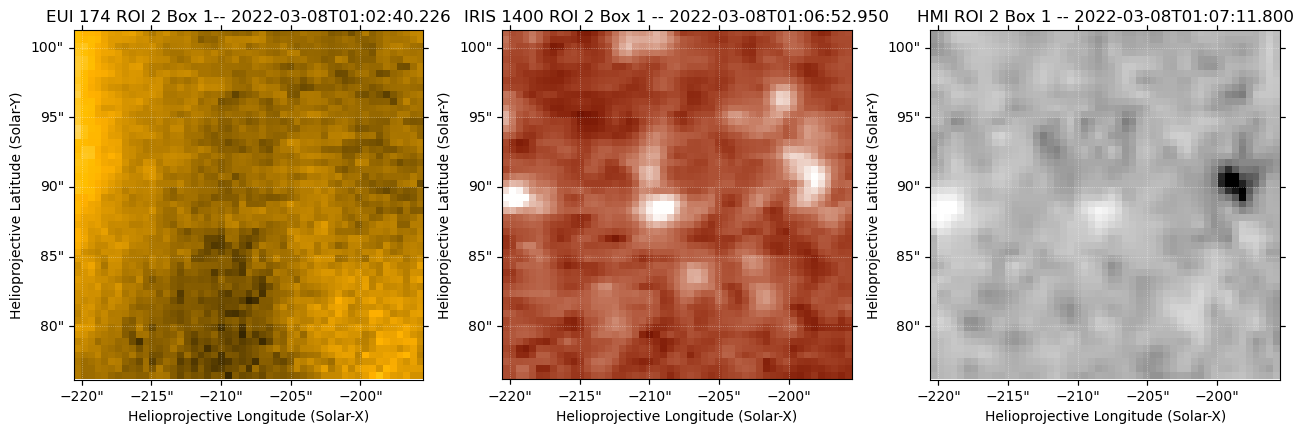

  1%|█▋                                                                                                                    | 1/68 [00:00<00:37,  1.80it/s]

<Figure size 640x480 with 0 Axes>

  3%|███▍                                                                                                                  | 2/68 [00:00<00:24,  2.69it/s]

<Figure size 640x480 with 0 Axes>

  4%|█████▏                                                                                                                | 3/68 [00:01<00:20,  3.20it/s]

<Figure size 640x480 with 0 Axes>

  6%|██████▉                                                                                                               | 4/68 [00:01<00:18,  3.49it/s]

<Figure size 640x480 with 0 Axes>

  7%|████████▋                                                                                                             | 5/68 [00:01<00:17,  3.63it/s]

<Figure size 640x480 with 0 Axes>

  9%|██████████▍                                                                                                           | 6/68 [00:01<00:16,  3.71it/s]

<Figure size 640x480 with 0 Axes>

 10%|████████████▏                                                                                                         | 7/68 [00:02<00:16,  3.79it/s]

<Figure size 640x480 with 0 Axes>

 12%|█████████████▉                                                                                                        | 8/68 [00:02<00:15,  3.82it/s]

<Figure size 640x480 with 0 Axes>

 13%|███████████████▌                                                                                                      | 9/68 [00:02<00:15,  3.86it/s]

<Figure size 640x480 with 0 Axes>

 15%|█████████████████▏                                                                                                   | 10/68 [00:02<00:15,  3.84it/s]

<Figure size 640x480 with 0 Axes>

 16%|██████████████████▉                                                                                                  | 11/68 [00:03<00:14,  3.83it/s]

<Figure size 640x480 with 0 Axes>

 18%|████████████████████▋                                                                                                | 12/68 [00:03<00:14,  3.83it/s]

<Figure size 640x480 with 0 Axes>

 19%|██████████████████████▎                                                                                              | 13/68 [00:03<00:14,  3.82it/s]

<Figure size 640x480 with 0 Axes>

 21%|████████████████████████                                                                                             | 14/68 [00:03<00:14,  3.79it/s]

<Figure size 640x480 with 0 Axes>

 22%|█████████████████████████▊                                                                                           | 15/68 [00:04<00:14,  3.75it/s]

<Figure size 640x480 with 0 Axes>

 24%|███████████████████████████▌                                                                                         | 16/68 [00:04<00:13,  3.72it/s]

<Figure size 640x480 with 0 Axes>

 25%|█████████████████████████████▎                                                                                       | 17/68 [00:04<00:13,  3.70it/s]

<Figure size 640x480 with 0 Axes>

 26%|██████████████████████████████▉                                                                                      | 18/68 [00:04<00:13,  3.67it/s]

<Figure size 640x480 with 0 Axes>

 28%|████████████████████████████████▋                                                                                    | 19/68 [00:05<00:13,  3.63it/s]

<Figure size 640x480 with 0 Axes>

 29%|██████████████████████████████████▍                                                                                  | 20/68 [00:05<00:13,  3.60it/s]

<Figure size 640x480 with 0 Axes>

 31%|████████████████████████████████████▏                                                                                | 21/68 [00:05<00:13,  3.57it/s]

<Figure size 640x480 with 0 Axes>

 32%|█████████████████████████████████████▊                                                                               | 22/68 [00:06<00:13,  3.50it/s]

<Figure size 640x480 with 0 Axes>

 34%|███████████████████████████████████████▌                                                                             | 23/68 [00:06<00:13,  3.45it/s]

<Figure size 640x480 with 0 Axes>

 35%|█████████████████████████████████████████▎                                                                           | 24/68 [00:06<00:12,  3.43it/s]

<Figure size 640x480 with 0 Axes>

 37%|███████████████████████████████████████████                                                                          | 25/68 [00:07<00:12,  3.36it/s]

<Figure size 640x480 with 0 Axes>

 38%|████████████████████████████████████████████▋                                                                        | 26/68 [00:07<00:12,  3.34it/s]

<Figure size 640x480 with 0 Axes>

 40%|██████████████████████████████████████████████▍                                                                      | 27/68 [00:07<00:12,  3.35it/s]

<Figure size 640x480 with 0 Axes>

 41%|████████████████████████████████████████████████▏                                                                    | 28/68 [00:07<00:11,  3.34it/s]

<Figure size 640x480 with 0 Axes>

 43%|█████████████████████████████████████████████████▉                                                                   | 29/68 [00:08<00:11,  3.33it/s]

<Figure size 640x480 with 0 Axes>

 44%|███████████████████████████████████████████████████▌                                                                 | 30/68 [00:08<00:11,  3.31it/s]

<Figure size 640x480 with 0 Axes>

 46%|█████████████████████████████████████████████████████▎                                                               | 31/68 [00:08<00:11,  3.23it/s]

<Figure size 640x480 with 0 Axes>

 47%|███████████████████████████████████████████████████████                                                              | 32/68 [00:09<00:11,  3.22it/s]

<Figure size 640x480 with 0 Axes>

 49%|████████████████████████████████████████████████████████▊                                                            | 33/68 [00:09<00:10,  3.22it/s]

<Figure size 640x480 with 0 Axes>

 50%|██████████████████████████████████████████████████████████▌                                                          | 34/68 [00:09<00:10,  3.21it/s]

<Figure size 640x480 with 0 Axes>

 51%|████████████████████████████████████████████████████████████▏                                                        | 35/68 [00:10<00:10,  3.19it/s]

<Figure size 640x480 with 0 Axes>

 53%|█████████████████████████████████████████████████████████████▉                                                       | 36/68 [00:10<00:10,  3.16it/s]

<Figure size 640x480 with 0 Axes>

 54%|███████████████████████████████████████████████████████████████▋                                                     | 37/68 [00:10<00:09,  3.12it/s]

<Figure size 640x480 with 0 Axes>

 56%|█████████████████████████████████████████████████████████████████▍                                                   | 38/68 [00:11<00:09,  3.10it/s]

<Figure size 640x480 with 0 Axes>

 57%|███████████████████████████████████████████████████████████████████                                                  | 39/68 [00:11<00:09,  3.08it/s]

<Figure size 640x480 with 0 Axes>

 59%|████████████████████████████████████████████████████████████████████▊                                                | 40/68 [00:11<00:09,  3.07it/s]

<Figure size 640x480 with 0 Axes>

 60%|██████████████████████████████████████████████████████████████████████▌                                              | 41/68 [00:12<00:08,  3.06it/s]

<Figure size 640x480 with 0 Axes>

 62%|████████████████████████████████████████████████████████████████████████▎                                            | 42/68 [00:12<00:08,  3.04it/s]

<Figure size 640x480 with 0 Axes>

 63%|█████████████████████████████████████████████████████████████████████████▉                                           | 43/68 [00:12<00:08,  3.01it/s]

<Figure size 640x480 with 0 Axes>

 65%|███████████████████████████████████████████████████████████████████████████▋                                         | 44/68 [00:13<00:08,  3.00it/s]

<Figure size 640x480 with 0 Axes>

 66%|█████████████████████████████████████████████████████████████████████████████▍                                       | 45/68 [00:13<00:07,  2.99it/s]

<Figure size 640x480 with 0 Axes>

 68%|███████████████████████████████████████████████████████████████████████████████▏                                     | 46/68 [00:13<00:07,  2.98it/s]

<Figure size 640x480 with 0 Axes>

 69%|████████████████████████████████████████████████████████████████████████████████▊                                    | 47/68 [00:14<00:07,  2.96it/s]

<Figure size 640x480 with 0 Axes>

 71%|██████████████████████████████████████████████████████████████████████████████████▌                                  | 48/68 [00:14<00:06,  2.95it/s]

<Figure size 640x480 with 0 Axes>

 72%|████████████████████████████████████████████████████████████████████████████████████▎                                | 49/68 [00:14<00:06,  2.91it/s]

<Figure size 640x480 with 0 Axes>

 74%|██████████████████████████████████████████████████████████████████████████████████████                               | 50/68 [00:15<00:06,  2.87it/s]

<Figure size 640x480 with 0 Axes>

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 51/68 [00:15<00:05,  2.87it/s]

<Figure size 640x480 with 0 Axes>

 76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 52/68 [00:15<00:05,  2.86it/s]

<Figure size 640x480 with 0 Axes>

 78%|███████████████████████████████████████████████████████████████████████████████████████████▏                         | 53/68 [00:16<00:05,  2.85it/s]

<Figure size 640x480 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████▉                        | 54/68 [00:16<00:04,  2.84it/s]

<Figure size 640x480 with 0 Axes>

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 55/68 [00:16<00:04,  2.83it/s]

<Figure size 640x480 with 0 Axes>

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 56/68 [00:17<00:04,  2.80it/s]

<Figure size 640x480 with 0 Axes>

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████                   | 57/68 [00:18<00:05,  2.04it/s]

<Figure size 640x480 with 0 Axes>

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 58/68 [00:18<00:04,  2.22it/s]

<Figure size 640x480 with 0 Axes>

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 59/68 [00:18<00:03,  2.35it/s]

<Figure size 640x480 with 0 Axes>

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 60/68 [00:19<00:03,  2.46it/s]

<Figure size 640x480 with 0 Axes>

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 61/68 [00:19<00:02,  2.52it/s]

<Figure size 640x480 with 0 Axes>

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 62/68 [00:19<00:02,  2.57it/s]

<Figure size 640x480 with 0 Axes>

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 63/68 [00:20<00:01,  2.59it/s]

<Figure size 640x480 with 0 Axes>

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 64/68 [00:20<00:01,  2.60it/s]

<Figure size 640x480 with 0 Axes>

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 65/68 [00:21<00:01,  2.61it/s]

<Figure size 640x480 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 66/68 [00:21<00:00,  2.60it/s]

<Figure size 640x480 with 0 Axes>

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 67/68 [00:21<00:00,  2.60it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:22<00:00,  3.06it/s]


In [23]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_1_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_1))):

        eui_map = eui_roi_2_trimmed_box_1[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 1-- {eui174_matched[frame_indices_box_1[i]].date}')

        iris_map = iris_roi_2_trimmed_box_1[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 1 -- {iris1400_matched[frame_indices_box_1[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_1[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 1 -- {hmi_matched[frame_indices_box_1[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/40 [00:00<?, ?it/s]

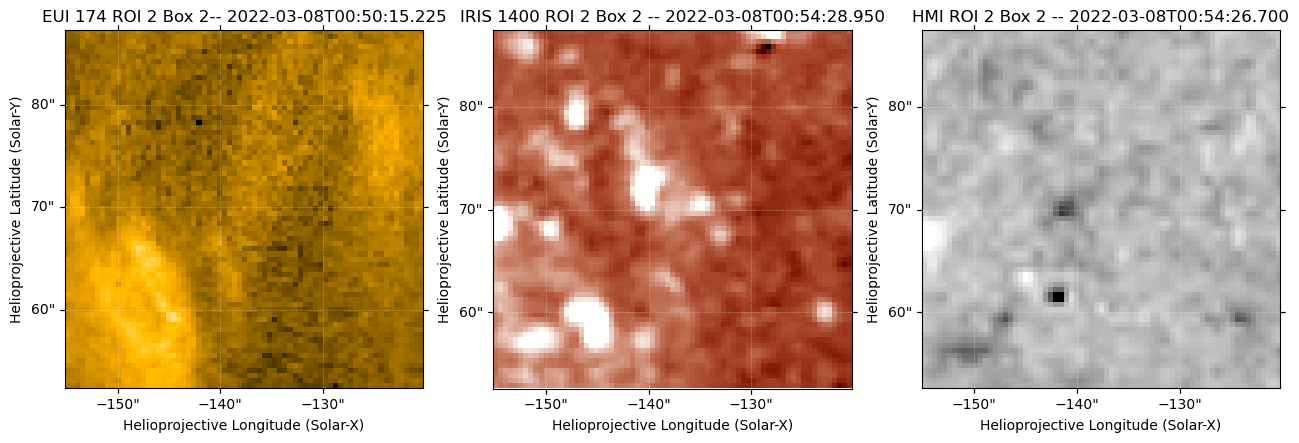

  2%|██▉                                                                                                                   | 1/40 [00:00<00:22,  1.76it/s]

<Figure size 640x480 with 0 Axes>

  5%|█████▉                                                                                                                | 2/40 [00:00<00:16,  2.36it/s]

<Figure size 640x480 with 0 Axes>

  8%|████████▊                                                                                                             | 3/40 [00:01<00:12,  2.95it/s]

<Figure size 640x480 with 0 Axes>

 10%|███████████▊                                                                                                          | 4/40 [00:01<00:10,  3.35it/s]

<Figure size 640x480 with 0 Axes>

 12%|██████████████▊                                                                                                       | 5/40 [00:01<00:09,  3.61it/s]

<Figure size 640x480 with 0 Axes>

 15%|█████████████████▋                                                                                                    | 6/40 [00:01<00:09,  3.75it/s]

<Figure size 640x480 with 0 Axes>

 18%|████████████████████▋                                                                                                 | 7/40 [00:02<00:08,  3.84it/s]

<Figure size 640x480 with 0 Axes>

 20%|███████████████████████▌                                                                                              | 8/40 [00:02<00:08,  3.90it/s]

<Figure size 640x480 with 0 Axes>

 22%|██████████████████████████▌                                                                                           | 9/40 [00:03<00:14,  2.18it/s]

<Figure size 640x480 with 0 Axes>

 25%|█████████████████████████████▎                                                                                       | 10/40 [00:03<00:11,  2.51it/s]

<Figure size 640x480 with 0 Axes>

 28%|████████████████████████████████▏                                                                                    | 11/40 [00:03<00:10,  2.80it/s]

<Figure size 640x480 with 0 Axes>

 30%|███████████████████████████████████                                                                                  | 12/40 [00:04<00:09,  3.03it/s]

<Figure size 640x480 with 0 Axes>

 32%|██████████████████████████████████████                                                                               | 13/40 [00:04<00:08,  3.26it/s]

<Figure size 640x480 with 0 Axes>

 35%|████████████████████████████████████████▉                                                                            | 14/40 [00:04<00:07,  3.43it/s]

<Figure size 640x480 with 0 Axes>

 38%|███████████████████████████████████████████▉                                                                         | 15/40 [00:04<00:07,  3.53it/s]

<Figure size 640x480 with 0 Axes>

 40%|██████████████████████████████████████████████▊                                                                      | 16/40 [00:05<00:06,  3.61it/s]

<Figure size 640x480 with 0 Axes>

 42%|█████████████████████████████████████████████████▋                                                                   | 17/40 [00:05<00:06,  3.66it/s]

<Figure size 640x480 with 0 Axes>

 45%|████████████████████████████████████████████████████▋                                                                | 18/40 [00:05<00:05,  3.69it/s]

<Figure size 640x480 with 0 Axes>

 48%|███████████████████████████████████████████████████████▌                                                             | 19/40 [00:05<00:05,  3.70it/s]

<Figure size 640x480 with 0 Axes>

 50%|██████████████████████████████████████████████████████████▌                                                          | 20/40 [00:06<00:05,  3.68it/s]

<Figure size 640x480 with 0 Axes>

 52%|█████████████████████████████████████████████████████████████▍                                                       | 21/40 [00:06<00:05,  3.68it/s]

<Figure size 640x480 with 0 Axes>

 55%|████████████████████████████████████████████████████████████████▎                                                    | 22/40 [00:06<00:04,  3.64it/s]

<Figure size 640x480 with 0 Axes>

 57%|███████████████████████████████████████████████████████████████████▎                                                 | 23/40 [00:06<00:04,  3.64it/s]

<Figure size 640x480 with 0 Axes>

 60%|██████████████████████████████████████████████████████████████████████▏                                              | 24/40 [00:07<00:04,  3.62it/s]

<Figure size 640x480 with 0 Axes>

 62%|█████████████████████████████████████████████████████████████████████████▏                                           | 25/40 [00:07<00:04,  3.59it/s]

<Figure size 640x480 with 0 Axes>

 65%|████████████████████████████████████████████████████████████████████████████                                         | 26/40 [00:07<00:03,  3.58it/s]

<Figure size 640x480 with 0 Axes>

 68%|██████████████████████████████████████████████████████████████████████████████▉                                      | 27/40 [00:08<00:03,  3.55it/s]

<Figure size 640x480 with 0 Axes>

 70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 28/40 [00:08<00:03,  3.52it/s]

<Figure size 640x480 with 0 Axes>

 72%|████████████████████████████████████████████████████████████████████████████████████▊                                | 29/40 [00:08<00:03,  3.45it/s]

<Figure size 640x480 with 0 Axes>

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 30/40 [00:08<00:02,  3.45it/s]

<Figure size 640x480 with 0 Axes>

 78%|██████████████████████████████████████████████████████████████████████████████████████████▋                          | 31/40 [00:09<00:02,  3.42it/s]

<Figure size 640x480 with 0 Axes>

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 32/40 [00:09<00:02,  3.38it/s]

<Figure size 640x480 with 0 Axes>

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 33/40 [00:09<00:02,  3.35it/s]

<Figure size 640x480 with 0 Axes>

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 34/40 [00:10<00:01,  3.33it/s]

<Figure size 640x480 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 35/40 [00:10<00:01,  3.30it/s]

<Figure size 640x480 with 0 Axes>

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 36/40 [00:10<00:01,  3.29it/s]

<Figure size 640x480 with 0 Axes>

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 37/40 [00:11<00:00,  3.28it/s]

<Figure size 640x480 with 0 Axes>

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 38/40 [00:11<00:00,  3.25it/s]

<Figure size 640x480 with 0 Axes>

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 39/40 [00:11<00:00,  3.20it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.31it/s]


In [44]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_2_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_2))):

        eui_map = eui_roi_2_trimmed_box_2[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 2-- {eui174_matched[frame_indices_box_2[i]].date}')

        iris_map = iris_roi_2_trimmed_box_2[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 2 -- {iris1400_matched[frame_indices_box_2[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_2[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 2 -- {hmi_matched[frame_indices_box_2[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/33 [00:00<?, ?it/s]

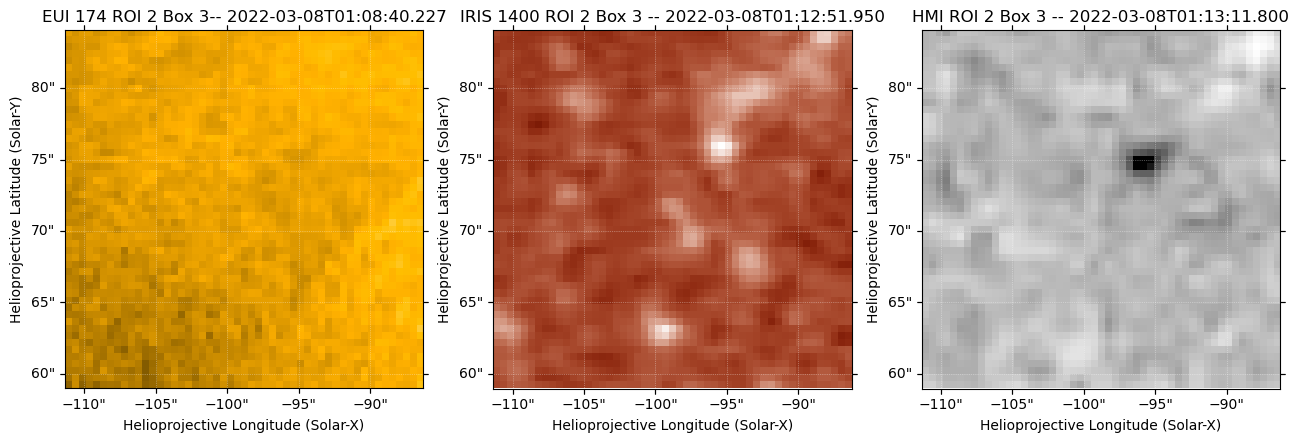

  3%|███▌                                                                                                                  | 1/33 [00:00<00:17,  1.80it/s]

<Figure size 640x480 with 0 Axes>

  6%|███████▏                                                                                                              | 2/33 [00:00<00:11,  2.66it/s]

<Figure size 640x480 with 0 Axes>

  9%|██████████▋                                                                                                           | 3/33 [00:01<00:09,  3.15it/s]

<Figure size 640x480 with 0 Axes>

 12%|██████████████▎                                                                                                       | 4/33 [00:01<00:08,  3.44it/s]

<Figure size 640x480 with 0 Axes>

 15%|█████████████████▉                                                                                                    | 5/33 [00:01<00:07,  3.60it/s]

<Figure size 640x480 with 0 Axes>

 18%|█████████████████████▍                                                                                                | 6/33 [00:01<00:07,  3.70it/s]

<Figure size 640x480 with 0 Axes>

 21%|█████████████████████████                                                                                             | 7/33 [00:02<00:06,  3.74it/s]

<Figure size 640x480 with 0 Axes>

 24%|████████████████████████████▌                                                                                         | 8/33 [00:02<00:06,  3.79it/s]

<Figure size 640x480 with 0 Axes>

 27%|████████████████████████████████▏                                                                                     | 9/33 [00:02<00:06,  3.81it/s]

<Figure size 640x480 with 0 Axes>

 30%|███████████████████████████████████▍                                                                                 | 10/33 [00:02<00:06,  3.81it/s]

<Figure size 640x480 with 0 Axes>

 33%|███████████████████████████████████████                                                                              | 11/33 [00:03<00:05,  3.80it/s]

<Figure size 640x480 with 0 Axes>

 36%|██████████████████████████████████████████▌                                                                          | 12/33 [00:03<00:05,  3.80it/s]

<Figure size 640x480 with 0 Axes>

 39%|██████████████████████████████████████████████                                                                       | 13/33 [00:03<00:05,  3.77it/s]

<Figure size 640x480 with 0 Axes>

 42%|█████████████████████████████████████████████████▋                                                                   | 14/33 [00:03<00:05,  3.76it/s]

<Figure size 640x480 with 0 Axes>

 45%|█████████████████████████████████████████████████████▏                                                               | 15/33 [00:04<00:04,  3.71it/s]

<Figure size 640x480 with 0 Axes>

 48%|████████████████████████████████████████████████████████▋                                                            | 16/33 [00:04<00:04,  3.69it/s]

<Figure size 640x480 with 0 Axes>

 52%|████████████████████████████████████████████████████████████▎                                                        | 17/33 [00:04<00:04,  3.67it/s]

<Figure size 640x480 with 0 Axes>

 55%|███████████████████████████████████████████████████████████████▊                                                     | 18/33 [00:05<00:04,  3.64it/s]

<Figure size 640x480 with 0 Axes>

 58%|███████████████████████████████████████████████████████████████████▎                                                 | 19/33 [00:05<00:03,  3.59it/s]

<Figure size 640x480 with 0 Axes>

 61%|██████████████████████████████████████████████████████████████████████▉                                              | 20/33 [00:05<00:03,  3.56it/s]

<Figure size 640x480 with 0 Axes>

 64%|██████████████████████████████████████████████████████████████████████████▍                                          | 21/33 [00:05<00:03,  3.52it/s]

<Figure size 640x480 with 0 Axes>

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 22/33 [00:06<00:03,  3.50it/s]

<Figure size 640x480 with 0 Axes>

 70%|█████████████████████████████████████████████████████████████████████████████████▌                                   | 23/33 [00:06<00:02,  3.48it/s]

<Figure size 640x480 with 0 Axes>

 73%|█████████████████████████████████████████████████████████████████████████████████████                                | 24/33 [00:06<00:02,  3.46it/s]

<Figure size 640x480 with 0 Axes>

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 25/33 [00:07<00:02,  3.44it/s]

<Figure size 640x480 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████▏                        | 26/33 [00:07<00:02,  3.42it/s]

<Figure size 640x480 with 0 Axes>

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                     | 27/33 [00:07<00:01,  3.38it/s]

<Figure size 640x480 with 0 Axes>

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 28/33 [00:07<00:01,  3.35it/s]

<Figure size 640x480 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 29/33 [00:08<00:01,  3.31it/s]

<Figure size 640x480 with 0 Axes>

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 30/33 [00:08<00:00,  3.29it/s]

<Figure size 640x480 with 0 Axes>

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 31/33 [00:08<00:00,  3.26it/s]

<Figure size 640x480 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 32/33 [00:09<00:00,  3.23it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.46it/s]


In [28]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_3_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_3))):

        eui_map = eui_roi_2_trimmed_box_3[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 3-- {eui174_matched[frame_indices_box_3[i]].date}')

        iris_map = iris_roi_2_trimmed_box_3[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 3 -- {iris1400_matched[frame_indices_box_3[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_3[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 3 -- {hmi_matched[frame_indices_box_3[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/33 [00:00<?, ?it/s]

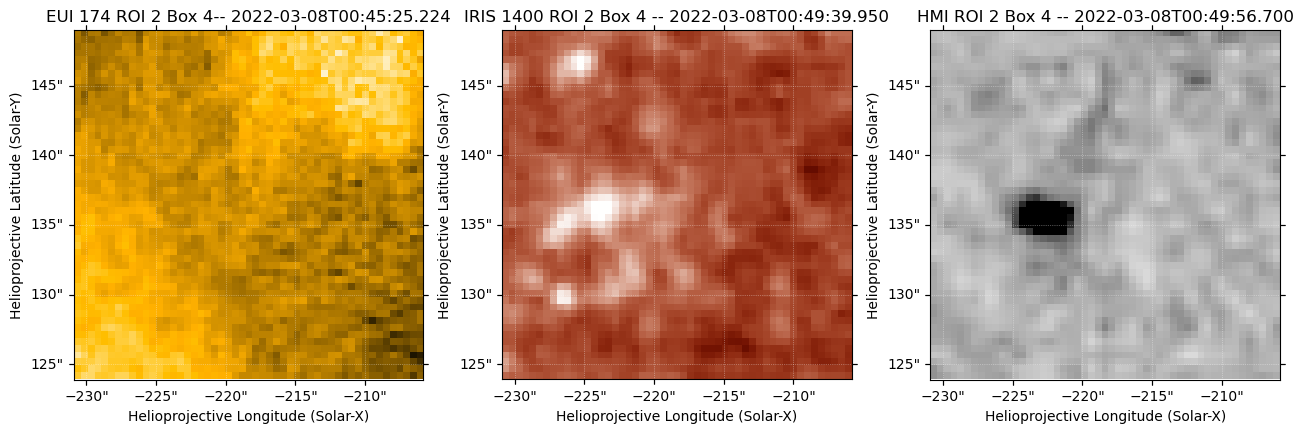

  3%|███▌                                                                                                                  | 1/33 [00:00<00:15,  2.03it/s]

<Figure size 640x480 with 0 Axes>

  6%|███████▏                                                                                                              | 2/33 [00:00<00:10,  2.93it/s]

<Figure size 640x480 with 0 Axes>

  9%|██████████▋                                                                                                           | 3/33 [00:00<00:08,  3.40it/s]

<Figure size 640x480 with 0 Axes>

 12%|██████████████▎                                                                                                       | 4/33 [00:01<00:07,  3.66it/s]

<Figure size 640x480 with 0 Axes>

 15%|█████████████████▉                                                                                                    | 5/33 [00:01<00:07,  3.80it/s]

<Figure size 640x480 with 0 Axes>

 18%|█████████████████████▍                                                                                                | 6/33 [00:01<00:06,  3.87it/s]

<Figure size 640x480 with 0 Axes>

 21%|█████████████████████████                                                                                             | 7/33 [00:01<00:06,  3.85it/s]

<Figure size 640x480 with 0 Axes>

 24%|████████████████████████████▌                                                                                         | 8/33 [00:02<00:06,  3.90it/s]

<Figure size 640x480 with 0 Axes>

 27%|████████████████████████████████▏                                                                                     | 9/33 [00:02<00:06,  3.90it/s]

<Figure size 640x480 with 0 Axes>

 30%|███████████████████████████████████▍                                                                                 | 10/33 [00:02<00:05,  3.90it/s]

<Figure size 640x480 with 0 Axes>

 33%|███████████████████████████████████████                                                                              | 11/33 [00:02<00:05,  3.85it/s]

<Figure size 640x480 with 0 Axes>

 36%|██████████████████████████████████████████▌                                                                          | 12/33 [00:03<00:05,  3.84it/s]

<Figure size 640x480 with 0 Axes>

 39%|██████████████████████████████████████████████                                                                       | 13/33 [00:03<00:05,  3.81it/s]

<Figure size 640x480 with 0 Axes>

 42%|█████████████████████████████████████████████████▋                                                                   | 14/33 [00:03<00:05,  3.77it/s]

<Figure size 640x480 with 0 Axes>

 45%|█████████████████████████████████████████████████████▏                                                               | 15/33 [00:04<00:05,  3.39it/s]

<Figure size 640x480 with 0 Axes>

 48%|████████████████████████████████████████████████████████▋                                                            | 16/33 [00:04<00:04,  3.46it/s]

<Figure size 640x480 with 0 Axes>

 52%|████████████████████████████████████████████████████████████▎                                                        | 17/33 [00:04<00:04,  3.48it/s]

<Figure size 640x480 with 0 Axes>

 55%|███████████████████████████████████████████████████████████████▊                                                     | 18/33 [00:05<00:04,  3.49it/s]

<Figure size 640x480 with 0 Axes>

 58%|███████████████████████████████████████████████████████████████████▎                                                 | 19/33 [00:05<00:04,  3.50it/s]

<Figure size 640x480 with 0 Axes>

 61%|██████████████████████████████████████████████████████████████████████▉                                              | 20/33 [00:05<00:03,  3.49it/s]

<Figure size 640x480 with 0 Axes>

 64%|██████████████████████████████████████████████████████████████████████████▍                                          | 21/33 [00:06<00:04,  2.51it/s]

<Figure size 640x480 with 0 Axes>

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 22/33 [00:06<00:04,  2.71it/s]

<Figure size 640x480 with 0 Axes>

 70%|█████████████████████████████████████████████████████████████████████████████████▌                                   | 23/33 [00:06<00:03,  2.88it/s]

<Figure size 640x480 with 0 Axes>

 73%|█████████████████████████████████████████████████████████████████████████████████████                                | 24/33 [00:07<00:02,  3.01it/s]

<Figure size 640x480 with 0 Axes>

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 25/33 [00:07<00:02,  3.11it/s]

<Figure size 640x480 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████▏                        | 26/33 [00:07<00:02,  3.16it/s]

<Figure size 640x480 with 0 Axes>

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                     | 27/33 [00:08<00:01,  3.18it/s]

<Figure size 640x480 with 0 Axes>

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 28/33 [00:08<00:01,  3.19it/s]

<Figure size 640x480 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 29/33 [00:08<00:01,  3.20it/s]

<Figure size 640x480 with 0 Axes>

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 30/33 [00:08<00:00,  3.22it/s]

<Figure size 640x480 with 0 Axes>

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 31/33 [00:09<00:00,  3.22it/s]

<Figure size 640x480 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 32/33 [00:09<00:00,  3.22it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.33it/s]


In [30]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_4_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_4))):

        eui_map = eui_roi_2_trimmed_box_4[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_map.plot(axes=ax1, norm=ImageNormalize(eui_map.data, vmin=500, vmax=1000, stretch=SqrtStretch()), 
                     cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 4-- {eui174_matched[frame_indices_box_4[i]].date}')

        iris_map = iris_roi_2_trimmed_box_4[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 4 -- {iris1400_matched[frame_indices_box_4[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_4[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 4 -- {hmi_matched[frame_indices_box_4[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/62 [00:00<?, ?it/s]

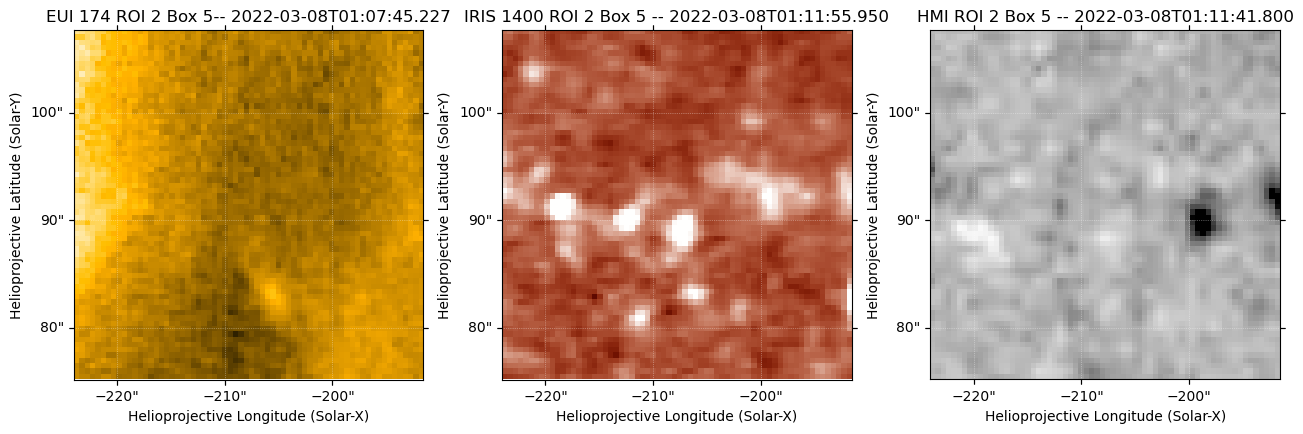

  2%|█▉                                                                                                                    | 1/62 [00:00<00:29,  2.08it/s]

<Figure size 640x480 with 0 Axes>

  3%|███▊                                                                                                                  | 2/62 [00:00<00:20,  2.98it/s]

<Figure size 640x480 with 0 Axes>

  5%|█████▋                                                                                                                | 3/62 [00:00<00:17,  3.44it/s]

<Figure size 640x480 with 0 Axes>

  6%|███████▌                                                                                                              | 4/62 [00:01<00:15,  3.71it/s]

<Figure size 640x480 with 0 Axes>

  8%|█████████▌                                                                                                            | 5/62 [00:01<00:14,  3.82it/s]

<Figure size 640x480 with 0 Axes>

 10%|███████████▍                                                                                                          | 6/62 [00:01<00:14,  3.88it/s]

<Figure size 640x480 with 0 Axes>

 11%|█████████████▎                                                                                                        | 7/62 [00:01<00:13,  3.95it/s]

<Figure size 640x480 with 0 Axes>

 13%|███████████████▏                                                                                                      | 8/62 [00:02<00:13,  3.99it/s]

<Figure size 640x480 with 0 Axes>

 15%|█████████████████▏                                                                                                    | 9/62 [00:02<00:13,  3.98it/s]

<Figure size 640x480 with 0 Axes>

 16%|██████████████████▊                                                                                                  | 10/62 [00:02<00:13,  3.99it/s]

<Figure size 640x480 with 0 Axes>

 18%|████████████████████▊                                                                                                | 11/62 [00:02<00:12,  3.98it/s]

<Figure size 640x480 with 0 Axes>

 19%|██████████████████████▋                                                                                              | 12/62 [00:03<00:12,  3.96it/s]

<Figure size 640x480 with 0 Axes>

 21%|████████████████████████▌                                                                                            | 13/62 [00:03<00:12,  3.91it/s]

<Figure size 640x480 with 0 Axes>

 23%|██████████████████████████▍                                                                                          | 14/62 [00:03<00:12,  3.87it/s]

<Figure size 640x480 with 0 Axes>

 24%|████████████████████████████▎                                                                                        | 15/62 [00:03<00:12,  3.82it/s]

<Figure size 640x480 with 0 Axes>

 26%|██████████████████████████████▏                                                                                      | 16/62 [00:04<00:12,  3.80it/s]

<Figure size 640x480 with 0 Axes>

 27%|████████████████████████████████                                                                                     | 17/62 [00:04<00:11,  3.79it/s]

<Figure size 640x480 with 0 Axes>

 29%|█████████████████████████████████▉                                                                                   | 18/62 [00:04<00:11,  3.73it/s]

<Figure size 640x480 with 0 Axes>

 31%|███████████████████████████████████▊                                                                                 | 19/62 [00:05<00:11,  3.68it/s]

<Figure size 640x480 with 0 Axes>

 32%|█████████████████████████████████████▋                                                                               | 20/62 [00:05<00:11,  3.67it/s]

<Figure size 640x480 with 0 Axes>

 34%|███████████████████████████████████████▋                                                                             | 21/62 [00:05<00:11,  3.65it/s]

<Figure size 640x480 with 0 Axes>

 35%|█████████████████████████████████████████▌                                                                           | 22/62 [00:05<00:11,  3.63it/s]

<Figure size 640x480 with 0 Axes>

 37%|███████████████████████████████████████████▍                                                                         | 23/62 [00:06<00:10,  3.61it/s]

<Figure size 640x480 with 0 Axes>

 39%|█████████████████████████████████████████████▎                                                                       | 24/62 [00:06<00:10,  3.59it/s]

<Figure size 640x480 with 0 Axes>

 40%|███████████████████████████████████████████████▏                                                                     | 25/62 [00:06<00:10,  3.56it/s]

<Figure size 640x480 with 0 Axes>

 42%|█████████████████████████████████████████████████                                                                    | 26/62 [00:07<00:10,  3.49it/s]

<Figure size 640x480 with 0 Axes>

 44%|██████████████████████████████████████████████████▉                                                                  | 27/62 [00:07<00:10,  3.43it/s]

<Figure size 640x480 with 0 Axes>

 45%|████████████████████████████████████████████████████▊                                                                | 28/62 [00:07<00:10,  3.39it/s]

<Figure size 640x480 with 0 Axes>

 47%|██████████████████████████████████████████████████████▋                                                              | 29/62 [00:07<00:09,  3.39it/s]

<Figure size 640x480 with 0 Axes>

 48%|████████████████████████████████████████████████████████▌                                                            | 30/62 [00:08<00:09,  3.37it/s]

<Figure size 640x480 with 0 Axes>

 50%|██████████████████████████████████████████████████████████▌                                                          | 31/62 [00:08<00:09,  3.36it/s]

<Figure size 640x480 with 0 Axes>

 52%|████████████████████████████████████████████████████████████▍                                                        | 32/62 [00:09<00:12,  2.44it/s]

<Figure size 640x480 with 0 Axes>

 53%|██████████████████████████████████████████████████████████████▎                                                      | 33/62 [00:09<00:10,  2.64it/s]

<Figure size 640x480 with 0 Axes>

 55%|████████████████████████████████████████████████████████████████▏                                                    | 34/62 [00:09<00:10,  2.80it/s]

<Figure size 640x480 with 0 Axes>

 56%|██████████████████████████████████████████████████████████████████                                                   | 35/62 [00:10<00:09,  2.90it/s]

<Figure size 640x480 with 0 Axes>

 58%|███████████████████████████████████████████████████████████████████▉                                                 | 36/62 [00:10<00:08,  2.98it/s]

<Figure size 640x480 with 0 Axes>

 60%|█████████████████████████████████████████████████████████████████████▊                                               | 37/62 [00:10<00:08,  3.05it/s]

<Figure size 640x480 with 0 Axes>

 61%|███████████████████████████████████████████████████████████████████████▋                                             | 38/62 [00:11<00:07,  3.09it/s]

<Figure size 640x480 with 0 Axes>

 63%|█████████████████████████████████████████████████████████████████████████▌                                           | 39/62 [00:11<00:07,  3.09it/s]

<Figure size 640x480 with 0 Axes>

 65%|███████████████████████████████████████████████████████████████████████████▍                                         | 40/62 [00:11<00:07,  3.10it/s]

<Figure size 640x480 with 0 Axes>

 66%|█████████████████████████████████████████████████████████████████████████████▎                                       | 41/62 [00:12<00:06,  3.11it/s]

<Figure size 640x480 with 0 Axes>

 68%|███████████████████████████████████████████████████████████████████████████████▎                                     | 42/62 [00:12<00:06,  3.10it/s]

<Figure size 640x480 with 0 Axes>

 69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 43/62 [00:12<00:06,  3.07it/s]

<Figure size 640x480 with 0 Axes>

 71%|███████████████████████████████████████████████████████████████████████████████████                                  | 44/62 [00:13<00:05,  3.07it/s]

<Figure size 640x480 with 0 Axes>

 73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 45/62 [00:13<00:05,  3.06it/s]

<Figure size 640x480 with 0 Axes>

 74%|██████████████████████████████████████████████████████████████████████████████████████▊                              | 46/62 [00:13<00:05,  3.05it/s]

<Figure size 640x480 with 0 Axes>

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 47/62 [00:14<00:04,  3.03it/s]

<Figure size 640x480 with 0 Axes>

 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                          | 48/62 [00:14<00:04,  3.00it/s]

<Figure size 640x480 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 49/62 [00:14<00:04,  2.99it/s]

<Figure size 640x480 with 0 Axes>

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                      | 50/62 [00:15<00:04,  2.99it/s]

<Figure size 640x480 with 0 Axes>

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 51/62 [00:15<00:03,  2.98it/s]

<Figure size 640x480 with 0 Axes>

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 52/62 [00:15<00:03,  2.96it/s]

<Figure size 640x480 with 0 Axes>

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████                 | 53/62 [00:16<00:03,  2.94it/s]

<Figure size 640x480 with 0 Axes>

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 54/62 [00:16<00:02,  2.92it/s]

<Figure size 640x480 with 0 Axes>

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 55/62 [00:16<00:02,  2.89it/s]

<Figure size 640x480 with 0 Axes>

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 56/62 [00:17<00:02,  2.87it/s]

<Figure size 640x480 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 57/62 [00:17<00:01,  2.86it/s]

<Figure size 640x480 with 0 Axes>

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 58/62 [00:17<00:01,  2.81it/s]

<Figure size 640x480 with 0 Axes>

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 59/62 [00:18<00:01,  2.79it/s]

<Figure size 640x480 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 60/62 [00:18<00:00,  2.77it/s]

<Figure size 640x480 with 0 Axes>

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 61/62 [00:18<00:00,  2.73it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:19<00:00,  3.21it/s]


In [31]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_5_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_5))):

        eui_map = eui_roi_2_trimmed_box_5[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 5-- {eui174_matched[frame_indices_box_5[i]].date}')

        iris_map = iris_roi_2_trimmed_box_5[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 5 -- {iris1400_matched[frame_indices_box_5[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_5[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 5 -- {hmi_matched[frame_indices_box_5[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/36 [00:00<?, ?it/s]

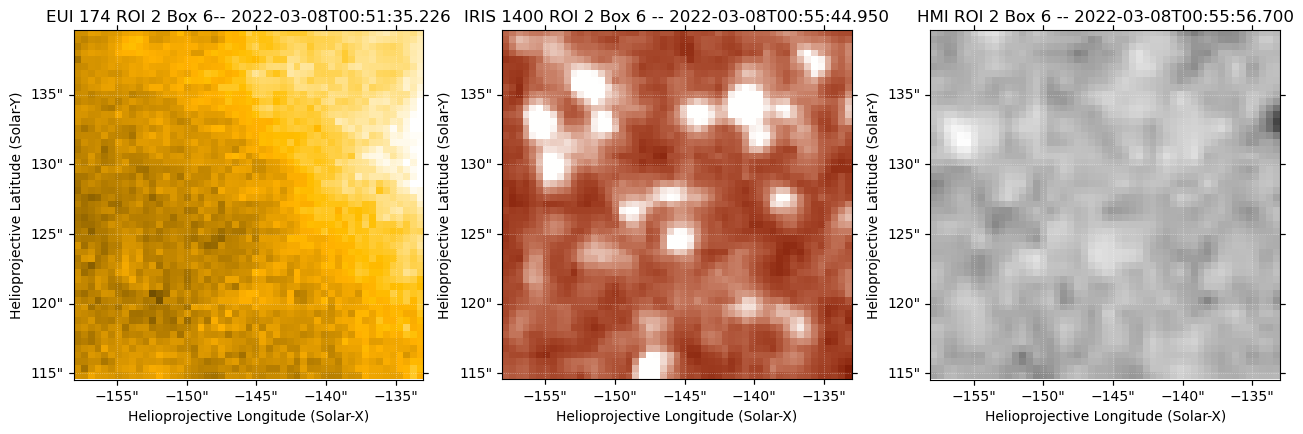

  3%|███▎                                                                                                                  | 1/36 [00:00<00:18,  1.90it/s]

<Figure size 640x480 with 0 Axes>

  6%|██████▌                                                                                                               | 2/36 [00:00<00:12,  2.63it/s]

<Figure size 640x480 with 0 Axes>

  8%|█████████▊                                                                                                            | 3/36 [00:01<00:10,  3.03it/s]

<Figure size 640x480 with 0 Axes>

 11%|█████████████                                                                                                         | 4/36 [00:01<00:09,  3.33it/s]

<Figure size 640x480 with 0 Axes>

 14%|████████████████▍                                                                                                     | 5/36 [00:01<00:08,  3.52it/s]

<Figure size 640x480 with 0 Axes>

 17%|███████████████████▋                                                                                                  | 6/36 [00:01<00:08,  3.65it/s]

<Figure size 640x480 with 0 Axes>

 19%|██████████████████████▉                                                                                               | 7/36 [00:02<00:07,  3.66it/s]

<Figure size 640x480 with 0 Axes>

 22%|██████████████████████████▏                                                                                           | 8/36 [00:02<00:07,  3.72it/s]

<Figure size 640x480 with 0 Axes>

 25%|█████████████████████████████▌                                                                                        | 9/36 [00:02<00:07,  3.73it/s]

<Figure size 640x480 with 0 Axes>

 28%|████████████████████████████████▌                                                                                    | 10/36 [00:02<00:06,  3.75it/s]

<Figure size 640x480 with 0 Axes>

 31%|███████████████████████████████████▊                                                                                 | 11/36 [00:03<00:06,  3.75it/s]

<Figure size 640x480 with 0 Axes>

 33%|███████████████████████████████████████                                                                              | 12/36 [00:03<00:06,  3.72it/s]

<Figure size 640x480 with 0 Axes>

 36%|██████████████████████████████████████████▎                                                                          | 13/36 [00:03<00:06,  3.68it/s]

<Figure size 640x480 with 0 Axes>

 39%|█████████████████████████████████████████████▌                                                                       | 14/36 [00:03<00:05,  3.67it/s]

<Figure size 640x480 with 0 Axes>

 42%|████████████████████████████████████████████████▊                                                                    | 15/36 [00:04<00:05,  3.66it/s]

<Figure size 640x480 with 0 Axes>

 44%|████████████████████████████████████████████████████                                                                 | 16/36 [00:04<00:08,  2.49it/s]

<Figure size 640x480 with 0 Axes>

 47%|███████████████████████████████████████████████████████▎                                                             | 17/36 [00:05<00:06,  2.72it/s]

<Figure size 640x480 with 0 Axes>

 50%|██████████████████████████████████████████████████████████▌                                                          | 18/36 [00:05<00:06,  2.88it/s]

<Figure size 640x480 with 0 Axes>

 53%|█████████████████████████████████████████████████████████████▊                                                       | 19/36 [00:05<00:05,  3.04it/s]

<Figure size 640x480 with 0 Axes>

 56%|█████████████████████████████████████████████████████████████████                                                    | 20/36 [00:06<00:05,  3.15it/s]

<Figure size 640x480 with 0 Axes>

 58%|████████████████████████████████████████████████████████████████████▎                                                | 21/36 [00:06<00:04,  3.22it/s]

<Figure size 640x480 with 0 Axes>

 61%|███████████████████████████████████████████████████████████████████████▌                                             | 22/36 [00:06<00:04,  3.27it/s]

<Figure size 640x480 with 0 Axes>

 64%|██████████████████████████████████████████████████████████████████████████▊                                          | 23/36 [00:07<00:03,  3.29it/s]

<Figure size 640x480 with 0 Axes>

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 24/36 [00:07<00:03,  3.24it/s]

<Figure size 640x480 with 0 Axes>

 69%|█████████████████████████████████████████████████████████████████████████████████▎                                   | 25/36 [00:07<00:03,  3.27it/s]

<Figure size 640x480 with 0 Axes>

 72%|████████████████████████████████████████████████████████████████████████████████████▌                                | 26/36 [00:07<00:03,  3.28it/s]

<Figure size 640x480 with 0 Axes>

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 27/36 [00:08<00:02,  3.29it/s]

<Figure size 640x480 with 0 Axes>

 78%|███████████████████████████████████████████████████████████████████████████████████████████                          | 28/36 [00:08<00:02,  3.27it/s]

<Figure size 640x480 with 0 Axes>

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                      | 29/36 [00:08<00:02,  3.27it/s]

<Figure size 640x480 with 0 Axes>

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 30/36 [00:09<00:01,  3.25it/s]

<Figure size 640x480 with 0 Axes>

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 31/36 [00:09<00:01,  3.24it/s]

<Figure size 640x480 with 0 Axes>

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████             | 32/36 [00:09<00:01,  3.23it/s]

<Figure size 640x480 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 33/36 [00:10<00:00,  3.20it/s]

<Figure size 640x480 with 0 Axes>

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 34/36 [00:10<00:00,  3.19it/s]

<Figure size 640x480 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 35/36 [00:10<00:00,  3.17it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.25it/s]


In [32]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_6_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_6))):

        eui_map = eui_roi_2_trimmed_box_6[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 6-- {eui174_matched[frame_indices_box_6[i]].date}')

        iris_map = iris_roi_2_trimmed_box_6[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 6 -- {iris1400_matched[frame_indices_box_6[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_6[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 6 -- {hmi_matched[frame_indices_box_6[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                             | 0/102 [00:00<?, ?it/s]

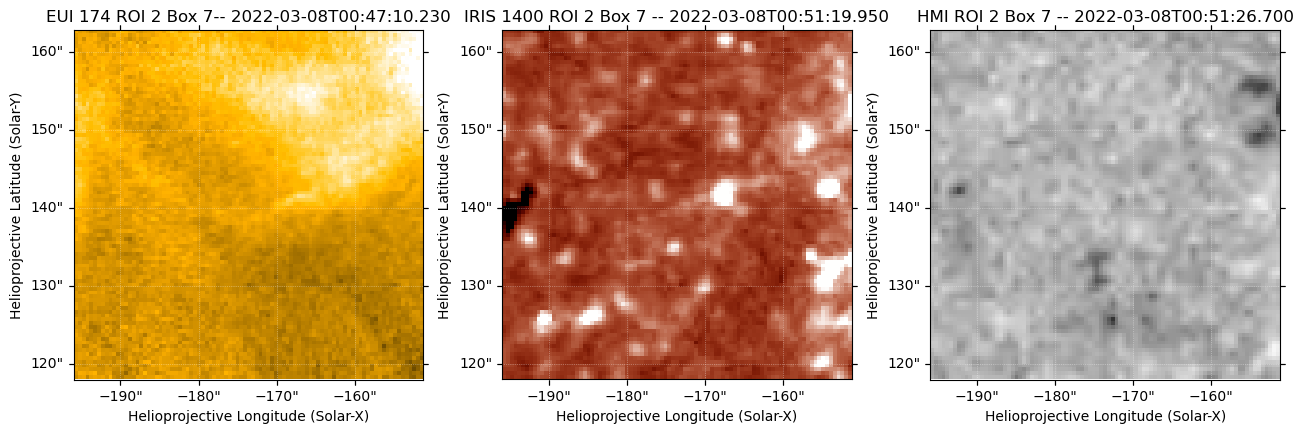

  1%|█▏                                                                                                                   | 1/102 [00:00<00:48,  2.07it/s]

<Figure size 640x480 with 0 Axes>

  2%|██▎                                                                                                                  | 2/102 [00:00<00:34,  2.86it/s]

<Figure size 640x480 with 0 Axes>

  3%|███▍                                                                                                                 | 3/102 [00:00<00:29,  3.32it/s]

<Figure size 640x480 with 0 Axes>

  4%|████▌                                                                                                                | 4/102 [00:01<00:27,  3.57it/s]

<Figure size 640x480 with 0 Axes>

  5%|█████▋                                                                                                               | 5/102 [00:01<00:26,  3.65it/s]

<Figure size 640x480 with 0 Axes>

  6%|██████▉                                                                                                              | 6/102 [00:01<00:25,  3.71it/s]

<Figure size 640x480 with 0 Axes>

  7%|████████                                                                                                             | 7/102 [00:02<00:25,  3.78it/s]

<Figure size 640x480 with 0 Axes>

  8%|█████████▏                                                                                                           | 8/102 [00:02<00:24,  3.80it/s]

<Figure size 640x480 with 0 Axes>

  9%|██████████▎                                                                                                          | 9/102 [00:02<00:24,  3.79it/s]

<Figure size 640x480 with 0 Axes>

 10%|███████████▎                                                                                                        | 10/102 [00:02<00:24,  3.78it/s]

<Figure size 640x480 with 0 Axes>

 11%|████████████▌                                                                                                       | 11/102 [00:03<00:24,  3.76it/s]

<Figure size 640x480 with 0 Axes>

 12%|█████████████▋                                                                                                      | 12/102 [00:03<00:23,  3.75it/s]

<Figure size 640x480 with 0 Axes>

 13%|██████████████▊                                                                                                     | 13/102 [00:03<00:23,  3.71it/s]

<Figure size 640x480 with 0 Axes>

 14%|███████████████▉                                                                                                    | 14/102 [00:03<00:24,  3.56it/s]

<Figure size 640x480 with 0 Axes>

 15%|█████████████████                                                                                                   | 15/102 [00:04<00:24,  3.52it/s]

<Figure size 640x480 with 0 Axes>

 16%|██████████████████▏                                                                                                 | 16/102 [00:04<00:24,  3.52it/s]

<Figure size 640x480 with 0 Axes>

 17%|███████████████████▎                                                                                                | 17/102 [00:04<00:24,  3.54it/s]

<Figure size 640x480 with 0 Axes>

 18%|████████████████████▍                                                                                               | 18/102 [00:05<00:23,  3.55it/s]

<Figure size 640x480 with 0 Axes>

 19%|█████████████████████▌                                                                                              | 19/102 [00:05<00:23,  3.53it/s]

<Figure size 640x480 with 0 Axes>

 20%|██████████████████████▋                                                                                             | 20/102 [00:05<00:23,  3.46it/s]

<Figure size 640x480 with 0 Axes>

 21%|███████████████████████▉                                                                                            | 21/102 [00:05<00:23,  3.43it/s]

<Figure size 640x480 with 0 Axes>

 22%|█████████████████████████                                                                                           | 22/102 [00:06<00:23,  3.40it/s]

<Figure size 640x480 with 0 Axes>

 23%|██████████████████████████▏                                                                                         | 23/102 [00:06<00:23,  3.40it/s]

<Figure size 640x480 with 0 Axes>

 24%|███████████████████████████▎                                                                                        | 24/102 [00:07<00:31,  2.45it/s]

<Figure size 640x480 with 0 Axes>

 25%|████████████████████████████▍                                                                                       | 25/102 [00:07<00:28,  2.66it/s]

<Figure size 640x480 with 0 Axes>

 25%|█████████████████████████████▌                                                                                      | 26/102 [00:07<00:26,  2.84it/s]

<Figure size 640x480 with 0 Axes>

 26%|██████████████████████████████▋                                                                                     | 27/102 [00:08<00:25,  2.97it/s]

<Figure size 640x480 with 0 Axes>

 27%|███████████████████████████████▊                                                                                    | 28/102 [00:08<00:24,  3.06it/s]

<Figure size 640x480 with 0 Axes>

 28%|████████████████████████████████▉                                                                                   | 29/102 [00:08<00:23,  3.13it/s]

<Figure size 640x480 with 0 Axes>

 29%|██████████████████████████████████                                                                                  | 30/102 [00:09<00:22,  3.14it/s]

<Figure size 640x480 with 0 Axes>

 30%|███████████████████████████████████▎                                                                                | 31/102 [00:09<00:22,  3.17it/s]

<Figure size 640x480 with 0 Axes>

 31%|████████████████████████████████████▍                                                                               | 32/102 [00:09<00:22,  3.17it/s]

<Figure size 640x480 with 0 Axes>

 32%|█████████████████████████████████████▌                                                                              | 33/102 [00:09<00:21,  3.18it/s]

<Figure size 640x480 with 0 Axes>

 33%|██████████████████████████████████████▋                                                                             | 34/102 [00:10<00:21,  3.17it/s]

<Figure size 640x480 with 0 Axes>

 34%|███████████████████████████████████████▊                                                                            | 35/102 [00:10<00:21,  3.15it/s]

<Figure size 640x480 with 0 Axes>

 35%|████████████████████████████████████████▉                                                                           | 36/102 [00:10<00:21,  3.14it/s]

<Figure size 640x480 with 0 Axes>

 36%|██████████████████████████████████████████                                                                          | 37/102 [00:11<00:20,  3.12it/s]

<Figure size 640x480 with 0 Axes>

 37%|███████████████████████████████████████████▏                                                                        | 38/102 [00:11<00:20,  3.10it/s]

<Figure size 640x480 with 0 Axes>

 38%|████████████████████████████████████████████▎                                                                       | 39/102 [00:11<00:20,  3.09it/s]

<Figure size 640x480 with 0 Axes>

 39%|█████████████████████████████████████████████▍                                                                      | 40/102 [00:12<00:20,  3.08it/s]

<Figure size 640x480 with 0 Axes>

 40%|██████████████████████████████████████████████▋                                                                     | 41/102 [00:12<00:19,  3.05it/s]

<Figure size 640x480 with 0 Axes>

 41%|███████████████████████████████████████████████▊                                                                    | 42/102 [00:12<00:19,  3.04it/s]

<Figure size 640x480 with 0 Axes>

 42%|████████████████████████████████████████████████▉                                                                   | 43/102 [00:13<00:19,  3.01it/s]

<Figure size 640x480 with 0 Axes>

 43%|██████████████████████████████████████████████████                                                                  | 44/102 [00:13<00:19,  2.98it/s]

<Figure size 640x480 with 0 Axes>

 44%|███████████████████████████████████████████████████▏                                                                | 45/102 [00:13<00:19,  2.97it/s]

<Figure size 640x480 with 0 Axes>

 45%|████████████████████████████████████████████████████▎                                                               | 46/102 [00:14<00:18,  2.96it/s]

<Figure size 640x480 with 0 Axes>

 46%|█████████████████████████████████████████████████████▍                                                              | 47/102 [00:14<00:18,  2.95it/s]

<Figure size 640x480 with 0 Axes>

 47%|██████████████████████████████████████████████████████▌                                                             | 48/102 [00:14<00:18,  2.94it/s]

<Figure size 640x480 with 0 Axes>

 48%|███████████████████████████████████████████████████████▋                                                            | 49/102 [00:15<00:18,  2.92it/s]

<Figure size 640x480 with 0 Axes>

 49%|████████████████████████████████████████████████████████▊                                                           | 50/102 [00:15<00:17,  2.90it/s]

<Figure size 640x480 with 0 Axes>

 50%|██████████████████████████████████████████████████████████                                                          | 51/102 [00:16<00:17,  2.86it/s]

<Figure size 640x480 with 0 Axes>

 51%|███████████████████████████████████████████████████████████▏                                                        | 52/102 [00:16<00:17,  2.85it/s]

<Figure size 640x480 with 0 Axes>

 52%|████████████████████████████████████████████████████████████▎                                                       | 53/102 [00:16<00:17,  2.85it/s]

<Figure size 640x480 with 0 Axes>

 53%|█████████████████████████████████████████████████████████████▍                                                      | 54/102 [00:17<00:17,  2.82it/s]

<Figure size 640x480 with 0 Axes>

 54%|██████████████████████████████████████████████████████████████▌                                                     | 55/102 [00:17<00:16,  2.77it/s]

<Figure size 640x480 with 0 Axes>

 55%|███████████████████████████████████████████████████████████████▋                                                    | 56/102 [00:17<00:16,  2.77it/s]

<Figure size 640x480 with 0 Axes>

 56%|████████████████████████████████████████████████████████████████▊                                                   | 57/102 [00:18<00:16,  2.76it/s]

<Figure size 640x480 with 0 Axes>

 57%|█████████████████████████████████████████████████████████████████▉                                                  | 58/102 [00:18<00:15,  2.75it/s]

<Figure size 640x480 with 0 Axes>

 58%|███████████████████████████████████████████████████████████████████                                                 | 59/102 [00:18<00:15,  2.73it/s]

<Figure size 640x480 with 0 Axes>

 59%|████████████████████████████████████████████████████████████████████▏                                               | 60/102 [00:19<00:15,  2.72it/s]

<Figure size 640x480 with 0 Axes>

 60%|█████████████████████████████████████████████████████████████████████▎                                              | 61/102 [00:19<00:15,  2.67it/s]

<Figure size 640x480 with 0 Axes>

 61%|██████████████████████████████████████████████████████████████████████▌                                             | 62/102 [00:20<00:15,  2.63it/s]

<Figure size 640x480 with 0 Axes>

 62%|███████████████████████████████████████████████████████████████████████▋                                            | 63/102 [00:20<00:14,  2.63it/s]

<Figure size 640x480 with 0 Axes>

 63%|████████████████████████████████████████████████████████████████████████▊                                           | 64/102 [00:20<00:14,  2.63it/s]

<Figure size 640x480 with 0 Axes>

 64%|█████████████████████████████████████████████████████████████████████████▉                                          | 65/102 [00:21<00:14,  2.62it/s]

<Figure size 640x480 with 0 Axes>

 65%|███████████████████████████████████████████████████████████████████████████                                         | 66/102 [00:21<00:13,  2.61it/s]

<Figure size 640x480 with 0 Axes>

 66%|████████████████████████████████████████████████████████████████████████████▏                                       | 67/102 [00:21<00:13,  2.60it/s]

<Figure size 640x480 with 0 Axes>

 67%|█████████████████████████████████████████████████████████████████████████████▎                                      | 68/102 [00:22<00:13,  2.59it/s]

<Figure size 640x480 with 0 Axes>

 68%|██████████████████████████████████████████████████████████████████████████████▍                                     | 69/102 [00:23<00:16,  2.01it/s]

<Figure size 640x480 with 0 Axes>

 69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 70/102 [00:23<00:15,  2.13it/s]

<Figure size 640x480 with 0 Axes>

 70%|████████████████████████████████████████████████████████████████████████████████▋                                   | 71/102 [00:23<00:13,  2.24it/s]

<Figure size 640x480 with 0 Axes>

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                  | 72/102 [00:24<00:12,  2.32it/s]

<Figure size 640x480 with 0 Axes>

 72%|███████████████████████████████████████████████████████████████████████████████████                                 | 73/102 [00:24<00:12,  2.36it/s]

<Figure size 640x480 with 0 Axes>

 73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 74/102 [00:25<00:11,  2.40it/s]

<Figure size 640x480 with 0 Axes>

 74%|█████████████████████████████████████████████████████████████████████████████████████▎                              | 75/102 [00:25<00:11,  2.41it/s]

<Figure size 640x480 with 0 Axes>

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 76/102 [00:25<00:10,  2.42it/s]

<Figure size 640x480 with 0 Axes>

 75%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 77/102 [00:26<00:10,  2.38it/s]

<Figure size 640x480 with 0 Axes>

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 78/102 [00:26<00:10,  2.33it/s]

<Figure size 640x480 with 0 Axes>

 77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 79/102 [00:27<00:09,  2.35it/s]

<Figure size 640x480 with 0 Axes>

 78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 80/102 [00:27<00:09,  2.38it/s]

<Figure size 640x480 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████                        | 81/102 [00:28<00:08,  2.38it/s]

<Figure size 640x480 with 0 Axes>

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 82/102 [00:28<00:08,  2.34it/s]

<Figure size 640x480 with 0 Axes>

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 83/102 [00:28<00:08,  2.33it/s]

<Figure size 640x480 with 0 Axes>

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 84/102 [00:29<00:07,  2.34it/s]

<Figure size 640x480 with 0 Axes>

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 85/102 [00:29<00:07,  2.33it/s]

<Figure size 640x480 with 0 Axes>

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 86/102 [00:30<00:06,  2.34it/s]

<Figure size 640x480 with 0 Axes>

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 87/102 [00:30<00:06,  2.32it/s]

<Figure size 640x480 with 0 Axes>

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 88/102 [00:31<00:06,  2.28it/s]

<Figure size 640x480 with 0 Axes>

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 89/102 [00:31<00:05,  2.26it/s]

<Figure size 640x480 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 90/102 [00:32<00:05,  2.26it/s]

<Figure size 640x480 with 0 Axes>

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 91/102 [00:32<00:04,  2.26it/s]

<Figure size 640x480 with 0 Axes>

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 92/102 [00:32<00:04,  2.27it/s]

<Figure size 640x480 with 0 Axes>

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 93/102 [00:33<00:03,  2.28it/s]

<Figure size 640x480 with 0 Axes>

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 94/102 [00:33<00:03,  2.26it/s]

<Figure size 640x480 with 0 Axes>

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 95/102 [00:34<00:03,  2.26it/s]

<Figure size 640x480 with 0 Axes>

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 96/102 [00:34<00:02,  2.25it/s]

<Figure size 640x480 with 0 Axes>

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 97/102 [00:35<00:02,  2.25it/s]

<Figure size 640x480 with 0 Axes>

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 98/102 [00:35<00:01,  2.21it/s]

<Figure size 640x480 with 0 Axes>

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 99/102 [00:36<00:01,  2.21it/s]

<Figure size 640x480 with 0 Axes>

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 100/102 [00:36<00:00,  2.21it/s]

<Figure size 640x480 with 0 Axes>

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 101/102 [00:36<00:00,  2.17it/s]

<Figure size 640x480 with 0 Axes>

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:37<00:00,  2.72it/s]


In [33]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_7_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_7))):

        eui_map = eui_roi_2_trimmed_box_7[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 7-- {eui174_matched[frame_indices_box_7[i]].date}')

        iris_map = iris_roi_2_trimmed_box_7[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 7 -- {iris1400_matched[frame_indices_box_7[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_7[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 7 -- {hmi_matched[frame_indices_box_7[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/63 [00:00<?, ?it/s]

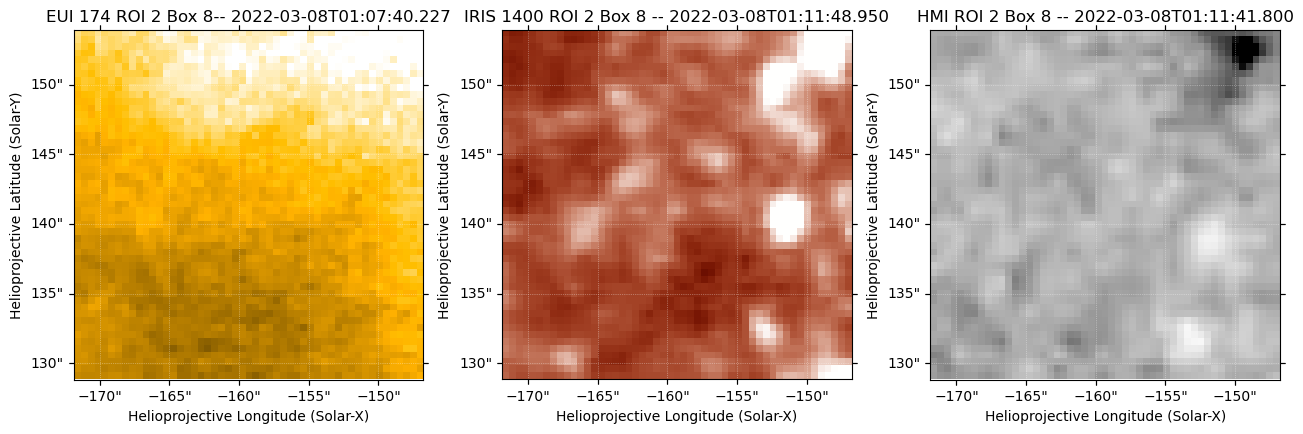

  2%|█▊                                                                                                                    | 1/63 [00:00<00:34,  1.79it/s]

<Figure size 640x480 with 0 Axes>

  3%|███▋                                                                                                                  | 2/63 [00:00<00:23,  2.62it/s]

<Figure size 640x480 with 0 Axes>

  5%|█████▌                                                                                                                | 3/63 [00:01<00:19,  3.05it/s]

<Figure size 640x480 with 0 Axes>

  6%|███████▍                                                                                                              | 4/63 [00:01<00:17,  3.30it/s]

<Figure size 640x480 with 0 Axes>

  8%|█████████▎                                                                                                            | 5/63 [00:01<00:17,  3.40it/s]

<Figure size 640x480 with 0 Axes>

 10%|███████████▏                                                                                                          | 6/63 [00:01<00:16,  3.53it/s]

<Figure size 640x480 with 0 Axes>

 11%|█████████████                                                                                                         | 7/63 [00:02<00:15,  3.56it/s]

<Figure size 640x480 with 0 Axes>

 13%|██████████████▉                                                                                                       | 8/63 [00:02<00:15,  3.61it/s]

<Figure size 640x480 with 0 Axes>

 14%|████████████████▊                                                                                                     | 9/63 [00:02<00:15,  3.60it/s]

<Figure size 640x480 with 0 Axes>

 16%|██████████████████▌                                                                                                  | 10/63 [00:02<00:14,  3.57it/s]

<Figure size 640x480 with 0 Axes>

 17%|████████████████████▍                                                                                                | 11/63 [00:03<00:14,  3.57it/s]

<Figure size 640x480 with 0 Axes>

 19%|██████████████████████▎                                                                                              | 12/63 [00:03<00:14,  3.58it/s]

<Figure size 640x480 with 0 Axes>

 21%|████████████████████████▏                                                                                            | 13/63 [00:03<00:13,  3.58it/s]

<Figure size 640x480 with 0 Axes>

 22%|██████████████████████████                                                                                           | 14/63 [00:04<00:13,  3.56it/s]

<Figure size 640x480 with 0 Axes>

 24%|███████████████████████████▊                                                                                         | 15/63 [00:04<00:13,  3.56it/s]

<Figure size 640x480 with 0 Axes>

 25%|█████████████████████████████▋                                                                                       | 16/63 [00:04<00:13,  3.55it/s]

<Figure size 640x480 with 0 Axes>

 27%|███████████████████████████████▌                                                                                     | 17/63 [00:04<00:13,  3.53it/s]

<Figure size 640x480 with 0 Axes>

 29%|█████████████████████████████████▍                                                                                   | 18/63 [00:05<00:12,  3.50it/s]

<Figure size 640x480 with 0 Axes>

 30%|███████████████████████████████████▎                                                                                 | 19/63 [00:05<00:12,  3.45it/s]

<Figure size 640x480 with 0 Axes>

 32%|█████████████████████████████████████▏                                                                               | 20/63 [00:05<00:12,  3.37it/s]

<Figure size 640x480 with 0 Axes>

 33%|███████████████████████████████████████                                                                              | 21/63 [00:06<00:19,  2.14it/s]

<Figure size 640x480 with 0 Axes>

 35%|████████████████████████████████████████▊                                                                            | 22/63 [00:07<00:17,  2.40it/s]

<Figure size 640x480 with 0 Axes>

 37%|██████████████████████████████████████████▋                                                                          | 23/63 [00:07<00:15,  2.63it/s]

<Figure size 640x480 with 0 Axes>

 38%|████████████████████████████████████████████▌                                                                        | 24/63 [00:07<00:13,  2.80it/s]

<Figure size 640x480 with 0 Axes>

 40%|██████████████████████████████████████████████▍                                                                      | 25/63 [00:07<00:12,  2.95it/s]

<Figure size 640x480 with 0 Axes>

 41%|████████████████████████████████████████████████▎                                                                    | 26/63 [00:08<00:12,  3.05it/s]

<Figure size 640x480 with 0 Axes>

 43%|██████████████████████████████████████████████████▏                                                                  | 27/63 [00:08<00:11,  3.12it/s]

<Figure size 640x480 with 0 Axes>

 44%|████████████████████████████████████████████████████                                                                 | 28/63 [00:08<00:11,  3.17it/s]

<Figure size 640x480 with 0 Axes>

 46%|█████████████████████████████████████████████████████▊                                                               | 29/63 [00:09<00:10,  3.19it/s]

<Figure size 640x480 with 0 Axes>

 48%|███████████████████████████████████████████████████████▋                                                             | 30/63 [00:09<00:10,  3.18it/s]

<Figure size 640x480 with 0 Axes>

 49%|█████████████████████████████████████████████████████████▌                                                           | 31/63 [00:09<00:10,  3.15it/s]

<Figure size 640x480 with 0 Axes>

 51%|███████████████████████████████████████████████████████████▍                                                         | 32/63 [00:10<00:09,  3.16it/s]

<Figure size 640x480 with 0 Axes>

 52%|█████████████████████████████████████████████████████████████▎                                                       | 33/63 [00:10<00:09,  3.16it/s]

<Figure size 640x480 with 0 Axes>

 54%|███████████████████████████████████████████████████████████████▏                                                     | 34/63 [00:10<00:09,  3.14it/s]

<Figure size 640x480 with 0 Axes>

 56%|█████████████████████████████████████████████████████████████████                                                    | 35/63 [00:11<00:08,  3.12it/s]

<Figure size 640x480 with 0 Axes>

 57%|██████████████████████████████████████████████████████████████████▊                                                  | 36/63 [00:11<00:08,  3.10it/s]

<Figure size 640x480 with 0 Axes>

 59%|████████████████████████████████████████████████████████████████████▋                                                | 37/63 [00:11<00:08,  3.02it/s]

<Figure size 640x480 with 0 Axes>

 60%|██████████████████████████████████████████████████████████████████████▌                                              | 38/63 [00:12<00:08,  3.01it/s]

<Figure size 640x480 with 0 Axes>

 62%|████████████████████████████████████████████████████████████████████████▍                                            | 39/63 [00:12<00:07,  3.03it/s]

<Figure size 640x480 with 0 Axes>

 63%|██████████████████████████████████████████████████████████████████████████▎                                          | 40/63 [00:12<00:07,  3.02it/s]

<Figure size 640x480 with 0 Axes>

 65%|████████████████████████████████████████████████████████████████████████████▏                                        | 41/63 [00:13<00:07,  3.03it/s]

<Figure size 640x480 with 0 Axes>

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 42/63 [00:13<00:07,  3.00it/s]

<Figure size 640x480 with 0 Axes>

 68%|███████████████████████████████████████████████████████████████████████████████▊                                     | 43/63 [00:13<00:06,  3.00it/s]

<Figure size 640x480 with 0 Axes>

 70%|█████████████████████████████████████████████████████████████████████████████████▋                                   | 44/63 [00:14<00:06,  2.97it/s]

<Figure size 640x480 with 0 Axes>

 71%|███████████████████████████████████████████████████████████████████████████████████▌                                 | 45/63 [00:14<00:06,  2.96it/s]

<Figure size 640x480 with 0 Axes>

 73%|█████████████████████████████████████████████████████████████████████████████████████▍                               | 46/63 [00:14<00:05,  2.95it/s]

<Figure size 640x480 with 0 Axes>

 75%|███████████████████████████████████████████████████████████████████████████████████████▎                             | 47/63 [00:15<00:05,  2.94it/s]

<Figure size 640x480 with 0 Axes>

 76%|█████████████████████████████████████████████████████████████████████████████████████████▏                           | 48/63 [00:15<00:05,  2.90it/s]

<Figure size 640x480 with 0 Axes>

 78%|███████████████████████████████████████████████████████████████████████████████████████████                          | 49/63 [00:15<00:04,  2.89it/s]

<Figure size 640x480 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████▊                        | 50/63 [00:16<00:04,  2.89it/s]

<Figure size 640x480 with 0 Axes>

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 51/63 [00:16<00:04,  2.85it/s]

<Figure size 640x480 with 0 Axes>

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 52/63 [00:16<00:03,  2.85it/s]

<Figure size 640x480 with 0 Axes>

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 53/63 [00:17<00:03,  2.84it/s]

<Figure size 640x480 with 0 Axes>

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 54/63 [00:17<00:03,  2.81it/s]

<Figure size 640x480 with 0 Axes>

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 55/63 [00:17<00:02,  2.77it/s]

<Figure size 640x480 with 0 Axes>

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████             | 56/63 [00:18<00:02,  2.77it/s]

<Figure size 640x480 with 0 Axes>

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 57/63 [00:18<00:02,  2.75it/s]

<Figure size 640x480 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 58/63 [00:19<00:01,  2.73it/s]

<Figure size 640x480 with 0 Axes>

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 59/63 [00:19<00:01,  2.73it/s]

<Figure size 640x480 with 0 Axes>

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 60/63 [00:19<00:01,  2.72it/s]

<Figure size 640x480 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 61/63 [00:20<00:00,  2.71it/s]

<Figure size 640x480 with 0 Axes>

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 62/63 [00:20<00:00,  2.70it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:20<00:00,  3.01it/s]


In [34]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_8_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_8))):

        eui_map = eui_roi_2_trimmed_box_8[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 8-- {eui174_matched[frame_indices_box_8[i]].date}')

        iris_map = iris_roi_2_trimmed_box_8[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 8 -- {iris1400_matched[frame_indices_box_8[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_8[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 8 -- {hmi_matched[frame_indices_box_8[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/78 [00:00<?, ?it/s]

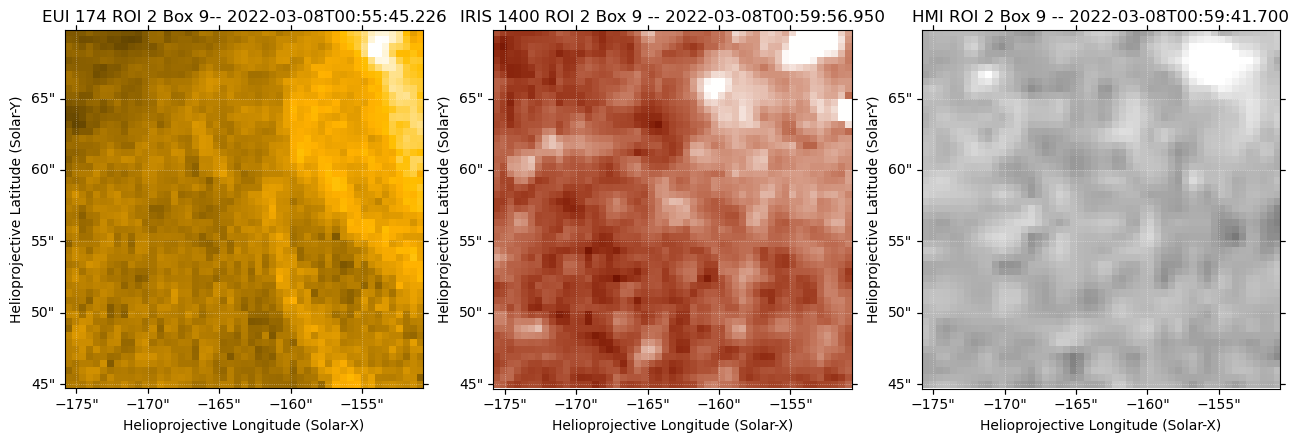

  1%|█▌                                                                                                                    | 1/78 [00:00<00:40,  1.90it/s]

<Figure size 640x480 with 0 Axes>

  3%|███                                                                                                                   | 2/78 [00:01<00:47,  1.61it/s]

<Figure size 640x480 with 0 Axes>

  4%|████▌                                                                                                                 | 3/78 [00:01<00:33,  2.21it/s]

<Figure size 640x480 with 0 Axes>

  5%|██████                                                                                                                | 4/78 [00:01<00:27,  2.67it/s]

<Figure size 640x480 with 0 Axes>

  6%|███████▌                                                                                                              | 5/78 [00:01<00:24,  3.01it/s]

<Figure size 640x480 with 0 Axes>

  8%|█████████                                                                                                             | 6/78 [00:02<00:22,  3.25it/s]

<Figure size 640x480 with 0 Axes>

  9%|██████████▌                                                                                                           | 7/78 [00:02<00:20,  3.41it/s]

<Figure size 640x480 with 0 Axes>

 10%|████████████                                                                                                          | 8/78 [00:02<00:19,  3.50it/s]

<Figure size 640x480 with 0 Axes>

 12%|█████████████▌                                                                                                        | 9/78 [00:03<00:19,  3.53it/s]

<Figure size 640x480 with 0 Axes>

 13%|██████████████▉                                                                                                      | 10/78 [00:03<00:19,  3.56it/s]

<Figure size 640x480 with 0 Axes>

 14%|████████████████▌                                                                                                    | 11/78 [00:03<00:18,  3.58it/s]

<Figure size 640x480 with 0 Axes>

 15%|██████████████████                                                                                                   | 12/78 [00:03<00:18,  3.59it/s]

<Figure size 640x480 with 0 Axes>

 17%|███████████████████▌                                                                                                 | 13/78 [00:04<00:18,  3.59it/s]

<Figure size 640x480 with 0 Axes>

 18%|█████████████████████                                                                                                | 14/78 [00:04<00:17,  3.59it/s]

<Figure size 640x480 with 0 Axes>

 19%|██████████████████████▌                                                                                              | 15/78 [00:04<00:17,  3.59it/s]

<Figure size 640x480 with 0 Axes>

 21%|████████████████████████                                                                                             | 16/78 [00:04<00:17,  3.56it/s]

<Figure size 640x480 with 0 Axes>

 22%|█████████████████████████▌                                                                                           | 17/78 [00:05<00:17,  3.56it/s]

<Figure size 640x480 with 0 Axes>

 23%|███████████████████████████                                                                                          | 18/78 [00:05<00:17,  3.52it/s]

<Figure size 640x480 with 0 Axes>

 24%|████████████████████████████▌                                                                                        | 19/78 [00:05<00:16,  3.48it/s]

<Figure size 640x480 with 0 Axes>

 26%|█████████████████████████████▉                                                                                       | 20/78 [00:06<00:16,  3.46it/s]

<Figure size 640x480 with 0 Axes>

 27%|███████████████████████████████▌                                                                                     | 21/78 [00:06<00:16,  3.43it/s]

<Figure size 640x480 with 0 Axes>

 28%|█████████████████████████████████                                                                                    | 22/78 [00:06<00:18,  3.03it/s]

<Figure size 640x480 with 0 Axes>

 29%|██████████████████████████████████▌                                                                                  | 23/78 [00:07<00:17,  3.11it/s]

<Figure size 640x480 with 0 Axes>

 31%|████████████████████████████████████                                                                                 | 24/78 [00:07<00:16,  3.18it/s]

<Figure size 640x480 with 0 Axes>

 32%|█████████████████████████████████████▌                                                                               | 25/78 [00:07<00:16,  3.22it/s]

<Figure size 640x480 with 0 Axes>

 33%|███████████████████████████████████████                                                                              | 26/78 [00:08<00:16,  3.23it/s]

<Figure size 640x480 with 0 Axes>

 35%|████████████████████████████████████████▌                                                                            | 27/78 [00:08<00:15,  3.25it/s]

<Figure size 640x480 with 0 Axes>

 36%|██████████████████████████████████████████                                                                           | 28/78 [00:08<00:15,  3.25it/s]

<Figure size 640x480 with 0 Axes>

 37%|███████████████████████████████████████████▌                                                                         | 29/78 [00:09<00:15,  3.24it/s]

<Figure size 640x480 with 0 Axes>

 38%|█████████████████████████████████████████████                                                                        | 30/78 [00:09<00:14,  3.23it/s]

<Figure size 640x480 with 0 Axes>

 40%|██████████████████████████████████████████████▌                                                                      | 31/78 [00:09<00:14,  3.22it/s]

<Figure size 640x480 with 0 Axes>

 41%|████████████████████████████████████████████████                                                                     | 32/78 [00:09<00:14,  3.20it/s]

<Figure size 640x480 with 0 Axes>

 42%|█████████████████████████████████████████████████▌                                                                   | 33/78 [00:10<00:14,  3.09it/s]

<Figure size 640x480 with 0 Axes>

 44%|███████████████████████████████████████████████████                                                                  | 34/78 [00:10<00:14,  3.10it/s]

<Figure size 640x480 with 0 Axes>

 45%|████████████████████████████████████████████████████▌                                                                | 35/78 [00:10<00:13,  3.09it/s]

<Figure size 640x480 with 0 Axes>

 46%|██████████████████████████████████████████████████████                                                               | 36/78 [00:11<00:13,  3.08it/s]

<Figure size 640x480 with 0 Axes>

 47%|███████████████████████████████████████████████████████▌                                                             | 37/78 [00:11<00:13,  3.07it/s]

<Figure size 640x480 with 0 Axes>

 49%|█████████████████████████████████████████████████████████                                                            | 38/78 [00:11<00:13,  3.07it/s]

<Figure size 640x480 with 0 Axes>

 50%|██████████████████████████████████████████████████████████▌                                                          | 39/78 [00:12<00:12,  3.05it/s]

<Figure size 640x480 with 0 Axes>

 51%|███████████████████████████████████████████████████████████▉                                                         | 40/78 [00:12<00:12,  3.05it/s]

<Figure size 640x480 with 0 Axes>

 53%|█████████████████████████████████████████████████████████████▌                                                       | 41/78 [00:12<00:12,  3.04it/s]

<Figure size 640x480 with 0 Axes>

 54%|███████████████████████████████████████████████████████████████                                                      | 42/78 [00:13<00:11,  3.02it/s]

<Figure size 640x480 with 0 Axes>

 55%|████████████████████████████████████████████████████████████████▌                                                    | 43/78 [00:13<00:11,  2.99it/s]

<Figure size 640x480 with 0 Axes>

 56%|██████████████████████████████████████████████████████████████████                                                   | 44/78 [00:14<00:15,  2.26it/s]

<Figure size 640x480 with 0 Axes>

 58%|███████████████████████████████████████████████████████████████████▌                                                 | 45/78 [00:14<00:13,  2.41it/s]

<Figure size 640x480 with 0 Axes>

 59%|█████████████████████████████████████████████████████████████████████                                                | 46/78 [00:14<00:12,  2.53it/s]

<Figure size 640x480 with 0 Axes>

 60%|██████████████████████████████████████████████████████████████████████▌                                              | 47/78 [00:15<00:11,  2.62it/s]

<Figure size 640x480 with 0 Axes>

 62%|████████████████████████████████████████████████████████████████████████                                             | 48/78 [00:15<00:11,  2.69it/s]

<Figure size 640x480 with 0 Axes>

 63%|█████████████████████████████████████████████████████████████████████████▌                                           | 49/78 [00:16<00:10,  2.74it/s]

<Figure size 640x480 with 0 Axes>

 64%|███████████████████████████████████████████████████████████████████████████                                          | 50/78 [00:16<00:10,  2.78it/s]

<Figure size 640x480 with 0 Axes>

 65%|████████████████████████████████████████████████████████████████████████████▌                                        | 51/78 [00:16<00:09,  2.80it/s]

<Figure size 640x480 with 0 Axes>

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 52/78 [00:17<00:09,  2.79it/s]

<Figure size 640x480 with 0 Axes>

 68%|███████████████████████████████████████████████████████████████████████████████▌                                     | 53/78 [00:17<00:08,  2.80it/s]

<Figure size 640x480 with 0 Axes>

 69%|█████████████████████████████████████████████████████████████████████████████████                                    | 54/78 [00:17<00:08,  2.77it/s]

<Figure size 640x480 with 0 Axes>

 71%|██████████████████████████████████████████████████████████████████████████████████▌                                  | 55/78 [00:18<00:08,  2.77it/s]

<Figure size 640x480 with 0 Axes>

 72%|████████████████████████████████████████████████████████████████████████████████████                                 | 56/78 [00:18<00:07,  2.75it/s]

<Figure size 640x480 with 0 Axes>

 73%|█████████████████████████████████████████████████████████████████████████████████████▌                               | 57/78 [00:18<00:07,  2.75it/s]

<Figure size 640x480 with 0 Axes>

 74%|███████████████████████████████████████████████████████████████████████████████████████                              | 58/78 [00:19<00:07,  2.73it/s]

<Figure size 640x480 with 0 Axes>

 76%|████████████████████████████████████████████████████████████████████████████████████████▌                            | 59/78 [00:19<00:06,  2.72it/s]

<Figure size 640x480 with 0 Axes>

 77%|██████████████████████████████████████████████████████████████████████████████████████████                           | 60/78 [00:20<00:06,  2.71it/s]

<Figure size 640x480 with 0 Axes>

 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                         | 61/78 [00:20<00:06,  2.60it/s]

<Figure size 640x480 with 0 Axes>

 79%|█████████████████████████████████████████████████████████████████████████████████████████████                        | 62/78 [00:20<00:06,  2.61it/s]

<Figure size 640x480 with 0 Axes>

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                      | 63/78 [00:21<00:05,  2.62it/s]

<Figure size 640x480 with 0 Axes>

 82%|████████████████████████████████████████████████████████████████████████████████████████████████                     | 64/78 [00:21<00:05,  2.61it/s]

<Figure size 640x480 with 0 Axes>

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 65/78 [00:21<00:05,  2.59it/s]

<Figure size 640x480 with 0 Axes>

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 66/78 [00:22<00:04,  2.57it/s]

<Figure size 640x480 with 0 Axes>

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 67/78 [00:22<00:04,  2.57it/s]

<Figure size 640x480 with 0 Axes>

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 68/78 [00:23<00:03,  2.56it/s]

<Figure size 640x480 with 0 Axes>

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 69/78 [00:23<00:03,  2.56it/s]

<Figure size 640x480 with 0 Axes>

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 70/78 [00:23<00:03,  2.54it/s]

<Figure size 640x480 with 0 Axes>

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 71/78 [00:24<00:02,  2.52it/s]

<Figure size 640x480 with 0 Axes>

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 72/78 [00:24<00:02,  2.51it/s]

<Figure size 640x480 with 0 Axes>

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 73/78 [00:25<00:02,  2.49it/s]

<Figure size 640x480 with 0 Axes>

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 74/78 [00:25<00:01,  2.47it/s]

<Figure size 640x480 with 0 Axes>

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 75/78 [00:25<00:01,  2.47it/s]

<Figure size 640x480 with 0 Axes>

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 76/78 [00:26<00:00,  2.44it/s]

<Figure size 640x480 with 0 Axes>

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 77/78 [00:26<00:00,  2.45it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:27<00:00,  2.86it/s]


In [35]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_9_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_9))):

        eui_map = eui_roi_2_trimmed_box_9[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 9-- {eui174_matched[frame_indices_box_9[i]].date}')

        iris_map = iris_roi_2_trimmed_box_9[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 9 -- {iris1400_matched[frame_indices_box_9[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_9[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 9 -- {hmi_matched[frame_indices_box_9[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/68 [00:00<?, ?it/s]

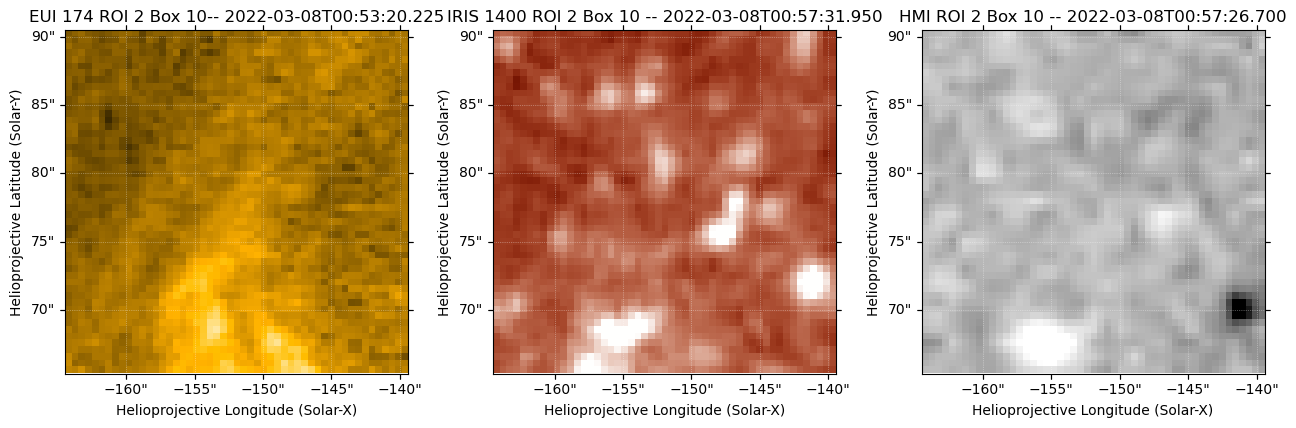

  1%|█▋                                                                                                                    | 1/68 [00:00<00:37,  1.78it/s]

<Figure size 640x480 with 0 Axes>

  3%|███▍                                                                                                                  | 2/68 [00:00<00:25,  2.58it/s]

<Figure size 640x480 with 0 Axes>

  4%|█████▏                                                                                                                | 3/68 [00:01<00:21,  3.03it/s]

<Figure size 640x480 with 0 Axes>

  6%|██████▉                                                                                                               | 4/68 [00:01<00:19,  3.29it/s]

<Figure size 640x480 with 0 Axes>

  7%|████████▋                                                                                                             | 5/68 [00:01<00:18,  3.46it/s]

<Figure size 640x480 with 0 Axes>

  9%|██████████▍                                                                                                           | 6/68 [00:01<00:17,  3.56it/s]

<Figure size 640x480 with 0 Axes>

 10%|████████████▏                                                                                                         | 7/68 [00:02<00:16,  3.63it/s]

<Figure size 640x480 with 0 Axes>

 12%|█████████████▉                                                                                                        | 8/68 [00:02<00:16,  3.66it/s]

<Figure size 640x480 with 0 Axes>

 13%|███████████████▌                                                                                                      | 9/68 [00:02<00:16,  3.68it/s]

<Figure size 640x480 with 0 Axes>

 15%|█████████████████▏                                                                                                   | 10/68 [00:02<00:15,  3.64it/s]

<Figure size 640x480 with 0 Axes>

 16%|██████████████████▉                                                                                                  | 11/68 [00:03<00:15,  3.63it/s]

<Figure size 640x480 with 0 Axes>

 18%|████████████████████▋                                                                                                | 12/68 [00:03<00:15,  3.62it/s]

<Figure size 640x480 with 0 Axes>

 19%|██████████████████████▎                                                                                              | 13/68 [00:03<00:15,  3.63it/s]

<Figure size 640x480 with 0 Axes>

 21%|████████████████████████                                                                                             | 14/68 [00:04<00:14,  3.62it/s]

<Figure size 640x480 with 0 Axes>

 22%|█████████████████████████▊                                                                                           | 15/68 [00:04<00:14,  3.57it/s]

<Figure size 640x480 with 0 Axes>

 24%|███████████████████████████▌                                                                                         | 16/68 [00:05<00:22,  2.35it/s]

<Figure size 640x480 with 0 Axes>

 25%|█████████████████████████████▎                                                                                       | 17/68 [00:05<00:19,  2.62it/s]

<Figure size 640x480 with 0 Axes>

 26%|██████████████████████████████▉                                                                                      | 18/68 [00:05<00:17,  2.84it/s]

<Figure size 640x480 with 0 Axes>

 28%|████████████████████████████████▋                                                                                    | 19/68 [00:05<00:16,  3.00it/s]

<Figure size 640x480 with 0 Axes>

 29%|██████████████████████████████████▍                                                                                  | 20/68 [00:06<00:15,  3.06it/s]

<Figure size 640x480 with 0 Axes>

 31%|████████████████████████████████████▏                                                                                | 21/68 [00:06<00:14,  3.15it/s]

<Figure size 640x480 with 0 Axes>

 32%|█████████████████████████████████████▊                                                                               | 22/68 [00:06<00:14,  3.21it/s]

<Figure size 640x480 with 0 Axes>

 34%|███████████████████████████████████████▌                                                                             | 23/68 [00:07<00:13,  3.26it/s]

<Figure size 640x480 with 0 Axes>

 35%|█████████████████████████████████████████▎                                                                           | 24/68 [00:07<00:13,  3.29it/s]

<Figure size 640x480 with 0 Axes>

 37%|███████████████████████████████████████████                                                                          | 25/68 [00:07<00:13,  3.31it/s]

<Figure size 640x480 with 0 Axes>

 38%|████████████████████████████████████████████▋                                                                        | 26/68 [00:08<00:12,  3.31it/s]

<Figure size 640x480 with 0 Axes>

 40%|██████████████████████████████████████████████▍                                                                      | 27/68 [00:08<00:12,  3.31it/s]

<Figure size 640x480 with 0 Axes>

 41%|████████████████████████████████████████████████▏                                                                    | 28/68 [00:08<00:12,  3.30it/s]

<Figure size 640x480 with 0 Axes>

 43%|█████████████████████████████████████████████████▉                                                                   | 29/68 [00:08<00:11,  3.28it/s]

<Figure size 640x480 with 0 Axes>

 44%|███████████████████████████████████████████████████▌                                                                 | 30/68 [00:09<00:11,  3.26it/s]

<Figure size 640x480 with 0 Axes>

 46%|█████████████████████████████████████████████████████▎                                                               | 31/68 [00:09<00:11,  3.24it/s]

<Figure size 640x480 with 0 Axes>

 47%|███████████████████████████████████████████████████████                                                              | 32/68 [00:09<00:11,  3.21it/s]

<Figure size 640x480 with 0 Axes>

 49%|████████████████████████████████████████████████████████▊                                                            | 33/68 [00:10<00:10,  3.19it/s]

<Figure size 640x480 with 0 Axes>

 50%|██████████████████████████████████████████████████████████▌                                                          | 34/68 [00:10<00:10,  3.17it/s]

<Figure size 640x480 with 0 Axes>

 51%|████████████████████████████████████████████████████████████▏                                                        | 35/68 [00:10<00:10,  3.16it/s]

<Figure size 640x480 with 0 Axes>

 53%|█████████████████████████████████████████████████████████████▉                                                       | 36/68 [00:11<00:10,  3.16it/s]

<Figure size 640x480 with 0 Axes>

 54%|███████████████████████████████████████████████████████████████▋                                                     | 37/68 [00:11<00:09,  3.13it/s]

<Figure size 640x480 with 0 Axes>

 56%|█████████████████████████████████████████████████████████████████▍                                                   | 38/68 [00:11<00:09,  3.11it/s]

<Figure size 640x480 with 0 Axes>

 57%|███████████████████████████████████████████████████████████████████                                                  | 39/68 [00:12<00:09,  3.09it/s]

<Figure size 640x480 with 0 Axes>

 59%|████████████████████████████████████████████████████████████████████▊                                                | 40/68 [00:12<00:09,  3.08it/s]

<Figure size 640x480 with 0 Axes>

 60%|██████████████████████████████████████████████████████████████████████▌                                              | 41/68 [00:12<00:08,  3.05it/s]

<Figure size 640x480 with 0 Axes>

 62%|████████████████████████████████████████████████████████████████████████▎                                            | 42/68 [00:13<00:08,  3.04it/s]

<Figure size 640x480 with 0 Axes>

 63%|█████████████████████████████████████████████████████████████████████████▉                                           | 43/68 [00:13<00:08,  3.03it/s]

<Figure size 640x480 with 0 Axes>

 65%|███████████████████████████████████████████████████████████████████████████▋                                         | 44/68 [00:13<00:08,  2.99it/s]

<Figure size 640x480 with 0 Axes>

 66%|█████████████████████████████████████████████████████████████████████████████▍                                       | 45/68 [00:14<00:07,  2.98it/s]

<Figure size 640x480 with 0 Axes>

 68%|███████████████████████████████████████████████████████████████████████████████▏                                     | 46/68 [00:14<00:07,  2.98it/s]

<Figure size 640x480 with 0 Axes>

 69%|████████████████████████████████████████████████████████████████████████████████▊                                    | 47/68 [00:14<00:07,  2.96it/s]

<Figure size 640x480 with 0 Axes>

 71%|██████████████████████████████████████████████████████████████████████████████████▌                                  | 48/68 [00:15<00:06,  2.94it/s]

<Figure size 640x480 with 0 Axes>

 72%|████████████████████████████████████████████████████████████████████████████████████▎                                | 49/68 [00:15<00:06,  2.92it/s]

<Figure size 640x480 with 0 Axes>

 74%|██████████████████████████████████████████████████████████████████████████████████████                               | 50/68 [00:15<00:06,  2.91it/s]

<Figure size 640x480 with 0 Axes>

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 51/68 [00:16<00:05,  2.89it/s]

<Figure size 640x480 with 0 Axes>

 76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 52/68 [00:16<00:05,  2.88it/s]

<Figure size 640x480 with 0 Axes>

 78%|███████████████████████████████████████████████████████████████████████████████████████████▏                         | 53/68 [00:16<00:05,  2.85it/s]

<Figure size 640x480 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████▉                        | 54/68 [00:17<00:04,  2.82it/s]

<Figure size 640x480 with 0 Axes>

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 55/68 [00:17<00:04,  2.81it/s]

<Figure size 640x480 with 0 Axes>

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 56/68 [00:18<00:04,  2.79it/s]

<Figure size 640x480 with 0 Axes>

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████                   | 57/68 [00:18<00:03,  2.79it/s]

<Figure size 640x480 with 0 Axes>

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 58/68 [00:18<00:03,  2.77it/s]

<Figure size 640x480 with 0 Axes>

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 59/68 [00:19<00:03,  2.76it/s]

<Figure size 640x480 with 0 Axes>

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 60/68 [00:19<00:02,  2.75it/s]

<Figure size 640x480 with 0 Axes>

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 61/68 [00:20<00:03,  2.07it/s]

<Figure size 640x480 with 0 Axes>

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 62/68 [00:20<00:02,  2.18it/s]

<Figure size 640x480 with 0 Axes>

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 63/68 [00:21<00:02,  2.31it/s]

<Figure size 640x480 with 0 Axes>

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 64/68 [00:21<00:01,  2.38it/s]

<Figure size 640x480 with 0 Axes>

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 65/68 [00:21<00:01,  2.46it/s]

<Figure size 640x480 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 66/68 [00:22<00:00,  2.49it/s]

<Figure size 640x480 with 0 Axes>

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 67/68 [00:22<00:00,  2.52it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:22<00:00,  2.96it/s]


In [36]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_10_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_10))):

        eui_map = eui_roi_2_trimmed_box_10[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 10-- {eui174_matched[frame_indices_box_10[i]].date}')

        iris_map = iris_roi_2_trimmed_box_10[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 10 -- {iris1400_matched[frame_indices_box_10[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_10[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 10 -- {hmi_matched[frame_indices_box_10[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

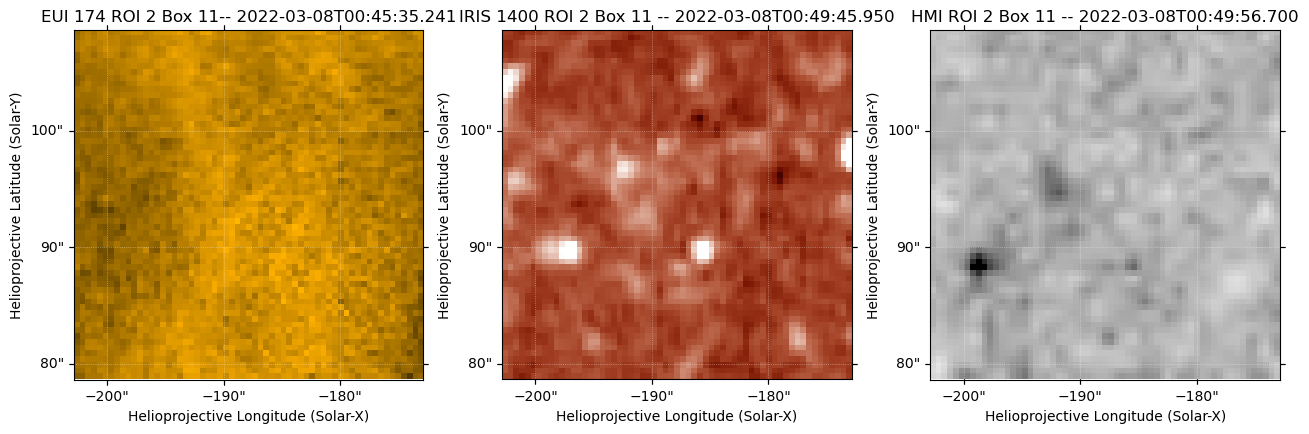

  5%|█████▌                                                                                                                | 1/21 [00:00<00:09,  2.20it/s]

<Figure size 640x480 with 0 Axes>

 10%|███████████▏                                                                                                          | 2/21 [00:00<00:06,  3.03it/s]

<Figure size 640x480 with 0 Axes>

 14%|████████████████▊                                                                                                     | 3/21 [00:00<00:05,  3.45it/s]

<Figure size 640x480 with 0 Axes>

 19%|██████████████████████▍                                                                                               | 4/21 [00:01<00:04,  3.67it/s]

<Figure size 640x480 with 0 Axes>

 24%|████████████████████████████                                                                                          | 5/21 [00:01<00:04,  3.80it/s]

<Figure size 640x480 with 0 Axes>

 29%|█████████████████████████████████▋                                                                                    | 6/21 [00:01<00:03,  3.87it/s]

<Figure size 640x480 with 0 Axes>

 33%|███████████████████████████████████████▎                                                                              | 7/21 [00:01<00:03,  3.90it/s]

<Figure size 640x480 with 0 Axes>

 38%|████████████████████████████████████████████▉                                                                         | 8/21 [00:02<00:03,  3.91it/s]

<Figure size 640x480 with 0 Axes>

 43%|██████████████████████████████████████████████████▌                                                                   | 9/21 [00:02<00:03,  3.91it/s]

<Figure size 640x480 with 0 Axes>

 48%|███████████████████████████████████████████████████████▋                                                             | 10/21 [00:02<00:02,  3.90it/s]

<Figure size 640x480 with 0 Axes>

 52%|█████████████████████████████████████████████████████████████▎                                                       | 11/21 [00:02<00:02,  3.88it/s]

<Figure size 640x480 with 0 Axes>

 57%|██████████████████████████████████████████████████████████████████▊                                                  | 12/21 [00:03<00:02,  3.81it/s]

<Figure size 640x480 with 0 Axes>

 62%|████████████████████████████████████████████████████████████████████████▍                                            | 13/21 [00:03<00:02,  3.78it/s]

<Figure size 640x480 with 0 Axes>

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 14/21 [00:03<00:01,  3.75it/s]

<Figure size 640x480 with 0 Axes>

 71%|███████████████████████████████████████████████████████████████████████████████████▌                                 | 15/21 [00:04<00:01,  3.72it/s]

<Figure size 640x480 with 0 Axes>

 76%|█████████████████████████████████████████████████████████████████████████████████████████▏                           | 16/21 [00:04<00:01,  3.69it/s]

<Figure size 640x480 with 0 Axes>

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 17/21 [00:04<00:01,  3.67it/s]

<Figure size 640x480 with 0 Axes>

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/21 [00:04<00:00,  3.67it/s]

<Figure size 640x480 with 0 Axes>

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 19/21 [00:05<00:00,  3.63it/s]

<Figure size 640x480 with 0 Axes>

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 20/21 [00:05<00:00,  3.58it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.67it/s]


In [37]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_11_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_11))):

        eui_map = eui_roi_2_trimmed_box_11[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 11-- {eui174_matched[frame_indices_box_11[i]].date}')

        iris_map = iris_roi_2_trimmed_box_11[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 11 -- {iris1400_matched[frame_indices_box_11[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_11[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 11 -- {hmi_matched[frame_indices_box_11[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/37 [00:00<?, ?it/s]

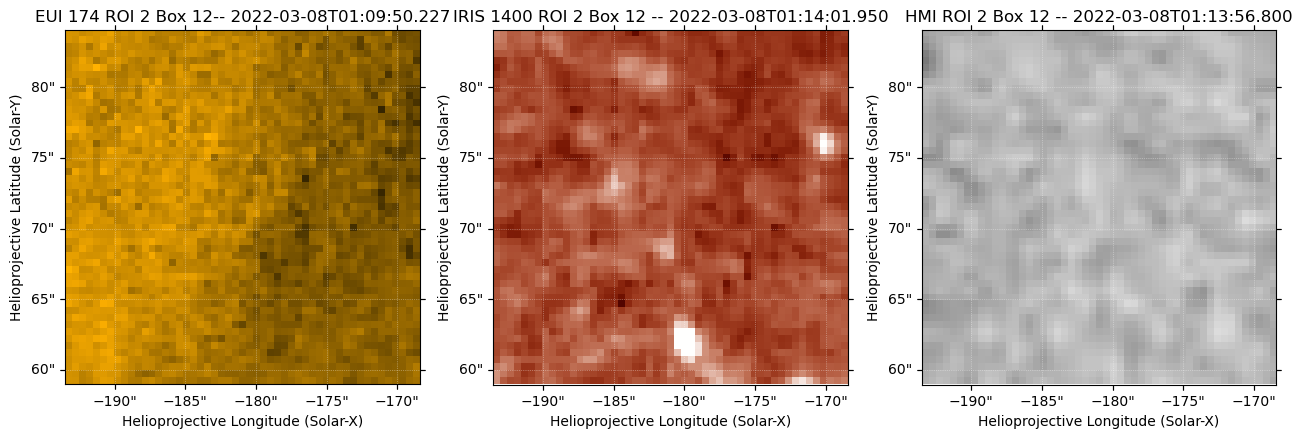

  3%|███▏                                                                                                                  | 1/37 [00:00<00:17,  2.01it/s]

<Figure size 640x480 with 0 Axes>

  5%|██████▍                                                                                                               | 2/37 [00:00<00:12,  2.84it/s]

<Figure size 640x480 with 0 Axes>

  8%|█████████▌                                                                                                            | 3/37 [00:01<00:10,  3.25it/s]

<Figure size 640x480 with 0 Axes>

 11%|████████████▊                                                                                                         | 4/37 [00:01<00:09,  3.48it/s]

<Figure size 640x480 with 0 Axes>

 14%|███████████████▉                                                                                                      | 5/37 [00:01<00:08,  3.60it/s]

<Figure size 640x480 with 0 Axes>

 16%|███████████████████▏                                                                                                  | 6/37 [00:01<00:08,  3.69it/s]

<Figure size 640x480 with 0 Axes>

 19%|██████████████████████▎                                                                                               | 7/37 [00:02<00:08,  3.71it/s]

<Figure size 640x480 with 0 Axes>

 22%|█████████████████████████▌                                                                                            | 8/37 [00:02<00:07,  3.71it/s]

<Figure size 640x480 with 0 Axes>

 24%|████████████████████████████▋                                                                                         | 9/37 [00:02<00:07,  3.72it/s]

<Figure size 640x480 with 0 Axes>

 27%|███████████████████████████████▌                                                                                     | 10/37 [00:02<00:07,  3.71it/s]

<Figure size 640x480 with 0 Axes>

 30%|██████████████████████████████████▊                                                                                  | 11/37 [00:03<00:07,  3.68it/s]

<Figure size 640x480 with 0 Axes>

 32%|█████████████████████████████████████▉                                                                               | 12/37 [00:03<00:06,  3.66it/s]

<Figure size 640x480 with 0 Axes>

 35%|█████████████████████████████████████████                                                                            | 13/37 [00:03<00:06,  3.61it/s]

<Figure size 640x480 with 0 Axes>

 38%|████████████████████████████████████████████▎                                                                        | 14/37 [00:03<00:06,  3.58it/s]

<Figure size 640x480 with 0 Axes>

 41%|███████████████████████████████████████████████▍                                                                     | 15/37 [00:04<00:06,  3.57it/s]

<Figure size 640x480 with 0 Axes>

 43%|██████████████████████████████████████████████████▌                                                                  | 16/37 [00:04<00:05,  3.51it/s]

<Figure size 640x480 with 0 Axes>

 46%|█████████████████████████████████████████████████████▊                                                               | 17/37 [00:04<00:05,  3.49it/s]

<Figure size 640x480 with 0 Axes>

 49%|████████████████████████████████████████████████████████▉                                                            | 18/37 [00:05<00:05,  3.48it/s]

<Figure size 640x480 with 0 Axes>

 51%|████████████████████████████████████████████████████████████                                                         | 19/37 [00:05<00:05,  3.48it/s]

<Figure size 640x480 with 0 Axes>

 54%|███████████████████████████████████████████████████████████████▏                                                     | 20/37 [00:05<00:04,  3.46it/s]

<Figure size 640x480 with 0 Axes>

 57%|██████████████████████████████████████████████████████████████████▍                                                  | 21/37 [00:06<00:04,  3.36it/s]

<Figure size 640x480 with 0 Axes>

 59%|█████████████████████████████████████████████████████████████████████▌                                               | 22/37 [00:06<00:04,  3.31it/s]

<Figure size 640x480 with 0 Axes>

 62%|████████████████████████████████████████████████████████████████████████▋                                            | 23/37 [00:06<00:04,  3.26it/s]

<Figure size 640x480 with 0 Axes>

 65%|███████████████████████████████████████████████████████████████████████████▉                                         | 24/37 [00:06<00:03,  3.27it/s]

<Figure size 640x480 with 0 Axes>

 68%|███████████████████████████████████████████████████████████████████████████████                                      | 25/37 [00:07<00:05,  2.14it/s]

<Figure size 640x480 with 0 Axes>

 70%|██████████████████████████████████████████████████████████████████████████████████▏                                  | 26/37 [00:08<00:04,  2.38it/s]

<Figure size 640x480 with 0 Axes>

 73%|█████████████████████████████████████████████████████████████████████████████████████▍                               | 27/37 [00:08<00:03,  2.59it/s]

<Figure size 640x480 with 0 Axes>

 76%|████████████████████████████████████████████████████████████████████████████████████████▌                            | 28/37 [00:08<00:03,  2.75it/s]

<Figure size 640x480 with 0 Axes>

 78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 29/37 [00:09<00:02,  2.88it/s]

<Figure size 640x480 with 0 Axes>

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▊                      | 30/37 [00:09<00:02,  2.96it/s]

<Figure size 640x480 with 0 Axes>

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████                   | 31/37 [00:09<00:01,  3.03it/s]

<Figure size 640x480 with 0 Axes>

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 32/37 [00:09<00:01,  3.05it/s]

<Figure size 640x480 with 0 Axes>

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 33/37 [00:10<00:01,  3.08it/s]

<Figure size 640x480 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 34/37 [00:10<00:00,  3.08it/s]

<Figure size 640x480 with 0 Axes>

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 35/37 [00:10<00:00,  3.08it/s]

<Figure size 640x480 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 36/37 [00:11<00:00,  3.07it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:11<00:00,  3.18it/s]


In [38]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_12_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_12))):

        eui_map = eui_roi_2_trimmed_box_12[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 12-- {eui174_matched[frame_indices_box_12[i]].date}')

        iris_map = iris_roi_2_trimmed_box_12[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 12 -- {iris1400_matched[frame_indices_box_12[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_12[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 12 -- {hmi_matched[frame_indices_box_12[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/48 [00:00<?, ?it/s]

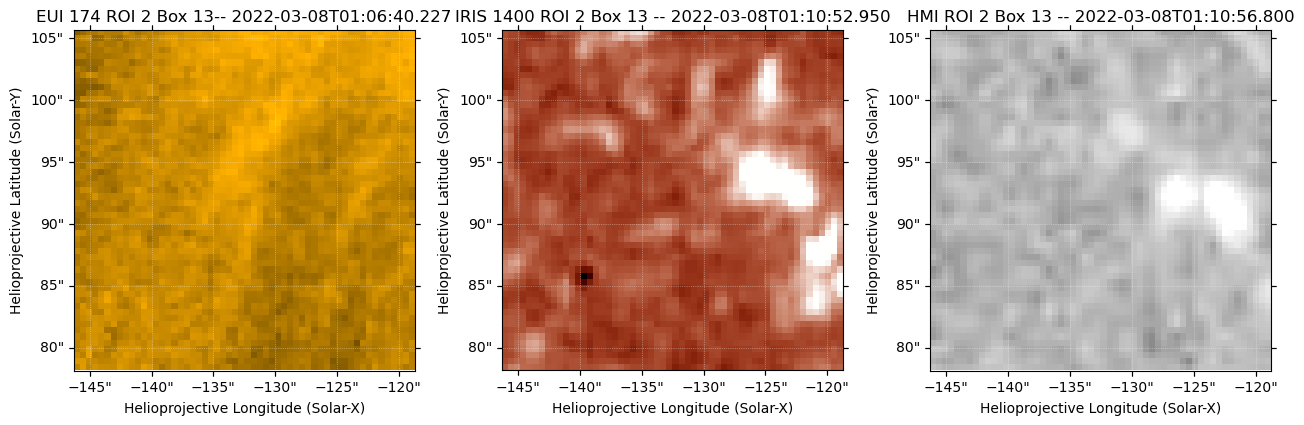

  2%|██▍                                                                                                                   | 1/48 [00:00<00:23,  2.01it/s]

<Figure size 640x480 with 0 Axes>

  4%|████▉                                                                                                                 | 2/48 [00:00<00:16,  2.81it/s]

<Figure size 640x480 with 0 Axes>

  6%|███████▍                                                                                                              | 3/48 [00:01<00:13,  3.24it/s]

<Figure size 640x480 with 0 Axes>

  8%|█████████▊                                                                                                            | 4/48 [00:01<00:12,  3.48it/s]

<Figure size 640x480 with 0 Axes>

 10%|████████████▎                                                                                                         | 5/48 [00:01<00:12,  3.58it/s]

<Figure size 640x480 with 0 Axes>

 12%|██████████████▊                                                                                                       | 6/48 [00:01<00:11,  3.65it/s]

<Figure size 640x480 with 0 Axes>

 15%|█████████████████▏                                                                                                    | 7/48 [00:02<00:11,  3.70it/s]

<Figure size 640x480 with 0 Axes>

 17%|███████████████████▋                                                                                                  | 8/48 [00:02<00:10,  3.71it/s]

<Figure size 640x480 with 0 Axes>

 19%|██████████████████████▏                                                                                               | 9/48 [00:02<00:10,  3.72it/s]

<Figure size 640x480 with 0 Axes>

 21%|████████████████████████▍                                                                                            | 10/48 [00:02<00:10,  3.67it/s]

<Figure size 640x480 with 0 Axes>

 23%|██████████████████████████▊                                                                                          | 11/48 [00:03<00:10,  3.66it/s]

<Figure size 640x480 with 0 Axes>

 25%|█████████████████████████████▎                                                                                       | 12/48 [00:03<00:09,  3.64it/s]

<Figure size 640x480 with 0 Axes>

 27%|███████████████████████████████▋                                                                                     | 13/48 [00:03<00:09,  3.63it/s]

<Figure size 640x480 with 0 Axes>

 29%|██████████████████████████████████▏                                                                                  | 14/48 [00:03<00:09,  3.59it/s]

<Figure size 640x480 with 0 Axes>

 31%|████████████████████████████████████▌                                                                                | 15/48 [00:04<00:09,  3.59it/s]

<Figure size 640x480 with 0 Axes>

 33%|███████████████████████████████████████                                                                              | 16/48 [00:04<00:08,  3.58it/s]

<Figure size 640x480 with 0 Axes>

 35%|█████████████████████████████████████████▍                                                                           | 17/48 [00:04<00:08,  3.57it/s]

<Figure size 640x480 with 0 Axes>

 38%|███████████████████████████████████████████▉                                                                         | 18/48 [00:05<00:08,  3.55it/s]

<Figure size 640x480 with 0 Axes>

 40%|██████████████████████████████████████████████▎                                                                      | 19/48 [00:05<00:08,  3.53it/s]

<Figure size 640x480 with 0 Axes>

 42%|████████████████████████████████████████████████▊                                                                    | 20/48 [00:05<00:07,  3.52it/s]

<Figure size 640x480 with 0 Axes>

 44%|███████████████████████████████████████████████████▏                                                                 | 21/48 [00:05<00:07,  3.50it/s]

<Figure size 640x480 with 0 Axes>

 46%|█████████████████████████████████████████████████████▋                                                               | 22/48 [00:06<00:07,  3.46it/s]

<Figure size 640x480 with 0 Axes>

 48%|████████████████████████████████████████████████████████                                                             | 23/48 [00:06<00:07,  3.44it/s]

<Figure size 640x480 with 0 Axes>

 50%|██████████████████████████████████████████████████████████▌                                                          | 24/48 [00:06<00:07,  3.41it/s]

<Figure size 640x480 with 0 Axes>

 52%|████████████████████████████████████████████████████████████▉                                                        | 25/48 [00:07<00:06,  3.39it/s]

<Figure size 640x480 with 0 Axes>

 54%|███████████████████████████████████████████████████████████████▎                                                     | 26/48 [00:07<00:06,  3.38it/s]

<Figure size 640x480 with 0 Axes>

 56%|█████████████████████████████████████████████████████████████████▊                                                   | 27/48 [00:07<00:06,  3.36it/s]

<Figure size 640x480 with 0 Axes>

 58%|████████████████████████████████████████████████████████████████████▎                                                | 28/48 [00:08<00:06,  3.32it/s]

<Figure size 640x480 with 0 Axes>

 60%|██████████████████████████████████████████████████████████████████████▋                                              | 29/48 [00:08<00:05,  3.27it/s]

<Figure size 640x480 with 0 Axes>

 62%|█████████████████████████████████████████████████████████████████████████▏                                           | 30/48 [00:08<00:05,  3.25it/s]

<Figure size 640x480 with 0 Axes>

 65%|███████████████████████████████████████████████████████████████████████████▌                                         | 31/48 [00:09<00:05,  3.22it/s]

<Figure size 640x480 with 0 Axes>

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 32/48 [00:09<00:05,  3.11it/s]

<Figure size 640x480 with 0 Axes>

 69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 33/48 [00:09<00:04,  3.08it/s]

<Figure size 640x480 with 0 Axes>

 71%|██████████████████████████████████████████████████████████████████████████████████▉                                  | 34/48 [00:10<00:04,  3.10it/s]

<Figure size 640x480 with 0 Axes>

 73%|█████████████████████████████████████████████████████████████████████████████████████▎                               | 35/48 [00:10<00:05,  2.20it/s]

<Figure size 640x480 with 0 Axes>

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 36/48 [00:11<00:04,  2.40it/s]

<Figure size 640x480 with 0 Axes>

 77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 37/48 [00:11<00:04,  2.54it/s]

<Figure size 640x480 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                        | 38/48 [00:11<00:03,  2.65it/s]

<Figure size 640x480 with 0 Axes>

 81%|███████████████████████████████████████████████████████████████████████████████████████████████                      | 39/48 [00:12<00:03,  2.76it/s]

<Figure size 640x480 with 0 Axes>

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 40/48 [00:12<00:02,  2.81it/s]

<Figure size 640x480 with 0 Axes>

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 41/48 [00:12<00:02,  2.87it/s]

<Figure size 640x480 with 0 Axes>

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 42/48 [00:13<00:02,  2.91it/s]

<Figure size 640x480 with 0 Axes>

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 43/48 [00:13<00:01,  2.93it/s]

<Figure size 640x480 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 44/48 [00:13<00:01,  2.94it/s]

<Figure size 640x480 with 0 Axes>

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 45/48 [00:14<00:01,  2.92it/s]

<Figure size 640x480 with 0 Axes>

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 46/48 [00:14<00:00,  2.92it/s]

<Figure size 640x480 with 0 Axes>

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 47/48 [00:14<00:00,  2.92it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.16it/s]


In [39]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_13_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_13))):

        eui_map = eui_roi_2_trimmed_box_13[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 13-- {eui174_matched[frame_indices_box_13[i]].date}')

        iris_map = iris_roi_2_trimmed_box_13[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 13 -- {iris1400_matched[frame_indices_box_13[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_13[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 13 -- {hmi_matched[frame_indices_box_13[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/61 [00:00<?, ?it/s]

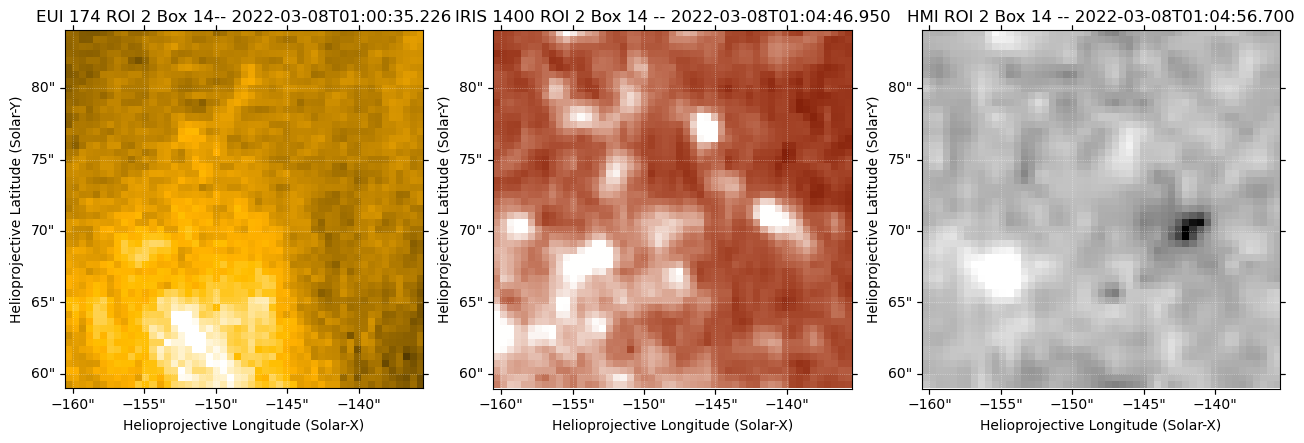

  2%|█▉                                                                                                                    | 1/61 [00:00<00:32,  1.85it/s]

<Figure size 640x480 with 0 Axes>

  3%|███▊                                                                                                                  | 2/61 [00:00<00:22,  2.67it/s]

<Figure size 640x480 with 0 Axes>

  5%|█████▊                                                                                                                | 3/61 [00:01<00:18,  3.11it/s]

<Figure size 640x480 with 0 Axes>

  7%|███████▋                                                                                                              | 4/61 [00:01<00:28,  2.04it/s]

<Figure size 640x480 with 0 Axes>

  8%|█████████▋                                                                                                            | 5/61 [00:02<00:22,  2.46it/s]

<Figure size 640x480 with 0 Axes>

 10%|███████████▌                                                                                                          | 6/61 [00:02<00:19,  2.79it/s]

<Figure size 640x480 with 0 Axes>

 11%|█████████████▌                                                                                                        | 7/61 [00:02<00:17,  3.05it/s]

<Figure size 640x480 with 0 Axes>

 13%|███████████████▍                                                                                                      | 8/61 [00:02<00:16,  3.25it/s]

<Figure size 640x480 with 0 Axes>

 15%|█████████████████▍                                                                                                    | 9/61 [00:03<00:15,  3.37it/s]

<Figure size 640x480 with 0 Axes>

 16%|███████████████████▏                                                                                                 | 10/61 [00:03<00:14,  3.44it/s]

<Figure size 640x480 with 0 Axes>

 18%|█████████████████████                                                                                                | 11/61 [00:03<00:14,  3.52it/s]

<Figure size 640x480 with 0 Axes>

 20%|███████████████████████                                                                                              | 12/61 [00:03<00:13,  3.57it/s]

<Figure size 640x480 with 0 Axes>

 21%|████████████████████████▉                                                                                            | 13/61 [00:04<00:13,  3.58it/s]

<Figure size 640x480 with 0 Axes>

 23%|██████████████████████████▊                                                                                          | 14/61 [00:04<00:13,  3.56it/s]

<Figure size 640x480 with 0 Axes>

 25%|████████████████████████████▊                                                                                        | 15/61 [00:04<00:13,  3.50it/s]

<Figure size 640x480 with 0 Axes>

 26%|██████████████████████████████▋                                                                                      | 16/61 [00:05<00:13,  3.46it/s]

<Figure size 640x480 with 0 Axes>

 28%|████████████████████████████████▌                                                                                    | 17/61 [00:05<00:12,  3.47it/s]

<Figure size 640x480 with 0 Axes>

 30%|██████████████████████████████████▌                                                                                  | 18/61 [00:05<00:12,  3.48it/s]

<Figure size 640x480 with 0 Axes>

 31%|████████████████████████████████████▍                                                                                | 19/61 [00:05<00:12,  3.48it/s]

<Figure size 640x480 with 0 Axes>

 33%|██████████████████████████████████████▎                                                                              | 20/61 [00:06<00:11,  3.46it/s]

<Figure size 640x480 with 0 Axes>

 34%|████████████████████████████████████████▎                                                                            | 21/61 [00:06<00:11,  3.45it/s]

<Figure size 640x480 with 0 Axes>

 36%|██████████████████████████████████████████▏                                                                          | 22/61 [00:06<00:11,  3.42it/s]

<Figure size 640x480 with 0 Axes>

 38%|████████████████████████████████████████████                                                                         | 23/61 [00:07<00:11,  3.40it/s]

<Figure size 640x480 with 0 Axes>

 39%|██████████████████████████████████████████████                                                                       | 24/61 [00:07<00:10,  3.38it/s]

<Figure size 640x480 with 0 Axes>

 41%|███████████████████████████████████████████████▉                                                                     | 25/61 [00:07<00:10,  3.36it/s]

<Figure size 640x480 with 0 Axes>

 43%|█████████████████████████████████████████████████▊                                                                   | 26/61 [00:08<00:10,  3.32it/s]

<Figure size 640x480 with 0 Axes>

 44%|███████████████████████████████████████████████████▊                                                                 | 27/61 [00:08<00:10,  3.29it/s]

<Figure size 640x480 with 0 Axes>

 46%|█████████████████████████████████████████████████████▋                                                               | 28/61 [00:08<00:10,  3.28it/s]

<Figure size 640x480 with 0 Axes>

 48%|███████████████████████████████████████████████████████▌                                                             | 29/61 [00:08<00:09,  3.24it/s]

<Figure size 640x480 with 0 Axes>

 49%|█████████████████████████████████████████████████████████▌                                                           | 30/61 [00:09<00:09,  3.23it/s]

<Figure size 640x480 with 0 Axes>

 51%|███████████████████████████████████████████████████████████▍                                                         | 31/61 [00:09<00:09,  3.21it/s]

<Figure size 640x480 with 0 Axes>

 52%|█████████████████████████████████████████████████████████████▍                                                       | 32/61 [00:09<00:09,  3.17it/s]

<Figure size 640x480 with 0 Axes>

 54%|███████████████████████████████████████████████████████████████▎                                                     | 33/61 [00:10<00:08,  3.13it/s]

<Figure size 640x480 with 0 Axes>

 56%|█████████████████████████████████████████████████████████████████▏                                                   | 34/61 [00:10<00:08,  3.10it/s]

<Figure size 640x480 with 0 Axes>

 57%|███████████████████████████████████████████████████████████████████▏                                                 | 35/61 [00:10<00:08,  3.10it/s]

<Figure size 640x480 with 0 Axes>

 59%|█████████████████████████████████████████████████████████████████████                                                | 36/61 [00:11<00:08,  3.09it/s]

<Figure size 640x480 with 0 Axes>

 61%|██████████████████████████████████████████████████████████████████████▉                                              | 37/61 [00:11<00:07,  3.08it/s]

<Figure size 640x480 with 0 Axes>

 62%|████████████████████████████████████████████████████████████████████████▉                                            | 38/61 [00:11<00:07,  3.07it/s]

<Figure size 640x480 with 0 Axes>

 64%|██████████████████████████████████████████████████████████████████████████▊                                          | 39/61 [00:12<00:07,  3.06it/s]

<Figure size 640x480 with 0 Axes>

 66%|████████████████████████████████████████████████████████████████████████████▋                                        | 40/61 [00:12<00:06,  3.04it/s]

<Figure size 640x480 with 0 Axes>

 67%|██████████████████████████████████████████████████████████████████████████████▋                                      | 41/61 [00:12<00:06,  3.02it/s]

<Figure size 640x480 with 0 Axes>

 69%|████████████████████████████████████████████████████████████████████████████████▌                                    | 42/61 [00:13<00:06,  3.01it/s]

<Figure size 640x480 with 0 Axes>

 70%|██████████████████████████████████████████████████████████████████████████████████▍                                  | 43/61 [00:13<00:06,  2.96it/s]

<Figure size 640x480 with 0 Axes>

 72%|████████████████████████████████████████████████████████████████████████████████████▍                                | 44/61 [00:13<00:05,  2.94it/s]

<Figure size 640x480 with 0 Axes>

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                              | 45/61 [00:14<00:05,  2.91it/s]

<Figure size 640x480 with 0 Axes>

 75%|████████████████████████████████████████████████████████████████████████████████████████▏                            | 46/61 [00:14<00:05,  2.89it/s]

<Figure size 640x480 with 0 Axes>

 77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 47/61 [00:14<00:04,  2.89it/s]

<Figure size 640x480 with 0 Axes>

 79%|████████████████████████████████████████████████████████████████████████████████████████████                         | 48/61 [00:15<00:04,  2.87it/s]

<Figure size 640x480 with 0 Axes>

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 49/61 [00:16<00:05,  2.15it/s]

<Figure size 640x480 with 0 Axes>

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▉                     | 50/61 [00:16<00:04,  2.30it/s]

<Figure size 640x480 with 0 Axes>

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 51/61 [00:16<00:04,  2.43it/s]

<Figure size 640x480 with 0 Axes>

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 52/61 [00:17<00:03,  2.53it/s]

<Figure size 640x480 with 0 Axes>

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 53/61 [00:17<00:03,  2.61it/s]

<Figure size 640x480 with 0 Axes>

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 54/61 [00:17<00:02,  2.64it/s]

<Figure size 640x480 with 0 Axes>

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 55/61 [00:18<00:02,  2.66it/s]

<Figure size 640x480 with 0 Axes>

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 56/61 [00:18<00:01,  2.66it/s]

<Figure size 640x480 with 0 Axes>

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 57/61 [00:18<00:01,  2.68it/s]

<Figure size 640x480 with 0 Axes>

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 58/61 [00:19<00:01,  2.67it/s]

<Figure size 640x480 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 59/61 [00:19<00:00,  2.68it/s]

<Figure size 640x480 with 0 Axes>

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 60/61 [00:20<00:00,  2.67it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:20<00:00,  2.98it/s]


In [41]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_14_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_14))):

        eui_map = eui_roi_2_trimmed_box_14[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 14-- {eui174_matched[frame_indices_box_14[i]].date}')

        iris_map = iris_roi_2_trimmed_box_14[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 14 -- {iris1400_matched[frame_indices_box_14[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_14[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 14 -- {hmi_matched[frame_indices_box_14[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

  0%|                                                                                                                              | 0/31 [00:00<?, ?it/s]

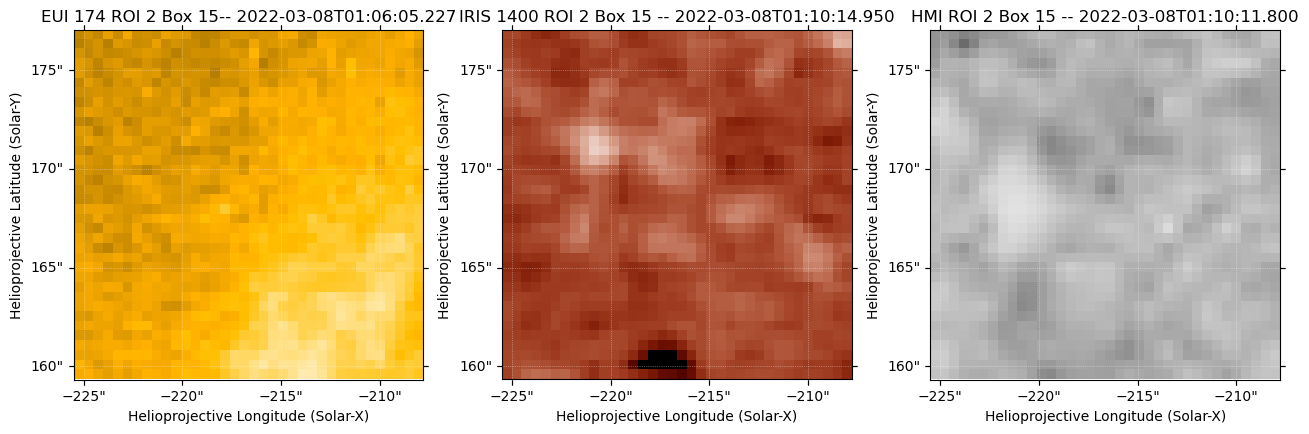

  3%|███▊                                                                                                                  | 1/31 [00:00<00:15,  1.96it/s]

<Figure size 640x480 with 0 Axes>

  6%|███████▌                                                                                                              | 2/31 [00:00<00:10,  2.75it/s]

<Figure size 640x480 with 0 Axes>

 10%|███████████▍                                                                                                          | 3/31 [00:01<00:08,  3.28it/s]

<Figure size 640x480 with 0 Axes>

 13%|███████████████▏                                                                                                      | 4/31 [00:01<00:07,  3.60it/s]

<Figure size 640x480 with 0 Axes>

 16%|███████████████████                                                                                                   | 5/31 [00:01<00:06,  3.76it/s]

<Figure size 640x480 with 0 Axes>

 19%|██████████████████████▊                                                                                               | 6/31 [00:01<00:06,  3.89it/s]

<Figure size 640x480 with 0 Axes>

 23%|██████████████████████████▋                                                                                           | 7/31 [00:01<00:06,  3.90it/s]

<Figure size 640x480 with 0 Axes>

 26%|██████████████████████████████▍                                                                                       | 8/31 [00:02<00:05,  3.90it/s]

<Figure size 640x480 with 0 Axes>

 29%|██████████████████████████████████▎                                                                                   | 9/31 [00:02<00:05,  3.94it/s]

<Figure size 640x480 with 0 Axes>

 32%|█████████████████████████████████████▋                                                                               | 10/31 [00:02<00:05,  3.93it/s]

<Figure size 640x480 with 0 Axes>

 35%|█████████████████████████████████████████▌                                                                           | 11/31 [00:02<00:05,  3.93it/s]

<Figure size 640x480 with 0 Axes>

 39%|█████████████████████████████████████████████▎                                                                       | 12/31 [00:03<00:04,  3.82it/s]

<Figure size 640x480 with 0 Axes>

 42%|█████████████████████████████████████████████████                                                                    | 13/31 [00:03<00:04,  3.83it/s]

<Figure size 640x480 with 0 Axes>

 45%|████████████████████████████████████████████████████▊                                                                | 14/31 [00:03<00:04,  3.82it/s]

<Figure size 640x480 with 0 Axes>

 48%|████████████████████████████████████████████████████████▌                                                            | 15/31 [00:04<00:04,  3.76it/s]

<Figure size 640x480 with 0 Axes>

 52%|████████████████████████████████████████████████████████████▍                                                        | 16/31 [00:04<00:03,  3.77it/s]

<Figure size 640x480 with 0 Axes>

 55%|████████████████████████████████████████████████████████████████▏                                                    | 17/31 [00:04<00:03,  3.77it/s]

<Figure size 640x480 with 0 Axes>

 58%|███████████████████████████████████████████████████████████████████▉                                                 | 18/31 [00:04<00:03,  3.75it/s]

<Figure size 640x480 with 0 Axes>

 61%|███████████████████████████████████████████████████████████████████████▋                                             | 19/31 [00:05<00:03,  3.73it/s]

<Figure size 640x480 with 0 Axes>

 65%|███████████████████████████████████████████████████████████████████████████▍                                         | 20/31 [00:05<00:02,  3.72it/s]

<Figure size 640x480 with 0 Axes>

 68%|███████████████████████████████████████████████████████████████████████████████▎                                     | 21/31 [00:05<00:02,  3.67it/s]

<Figure size 640x480 with 0 Axes>

 71%|███████████████████████████████████████████████████████████████████████████████████                                  | 22/31 [00:05<00:02,  3.65it/s]

<Figure size 640x480 with 0 Axes>

 74%|██████████████████████████████████████████████████████████████████████████████████████▊                              | 23/31 [00:06<00:02,  3.64it/s]

<Figure size 640x480 with 0 Axes>

 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                          | 24/31 [00:06<00:01,  3.62it/s]

<Figure size 640x480 with 0 Axes>

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                      | 25/31 [00:06<00:01,  3.59it/s]

<Figure size 640x480 with 0 Axes>

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 26/31 [00:07<00:01,  3.53it/s]

<Figure size 640x480 with 0 Axes>

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 27/31 [00:07<00:01,  3.52it/s]

<Figure size 640x480 with 0 Axes>

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 28/31 [00:07<00:00,  3.50it/s]

<Figure size 640x480 with 0 Axes>

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 29/31 [00:07<00:00,  3.48it/s]

<Figure size 640x480 with 0 Axes>

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 30/31 [00:08<00:00,  3.46it/s]

<Figure size 640x480 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:08<00:00,  3.62it/s]


In [42]:
fig = plt.figure(figsize=(13, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/eui_iris_hmi_roi_2_box_15_interval1.gif", dpi=200):
    
    for i in tqdm(range(len(eui_roi_2_trimmed_box_15))):

        eui_map = eui_roi_2_trimmed_box_15[i]
        ax1= fig.add_subplot(131, projection=eui_map.wcs)
        eui_norm = ImageNormalize(eui_map.data, vmin=350, vmax=1000, stretch=SqrtStretch())
        eui_map.plot(axes=ax1, norm=eui_norm, cmap='solar orbiterhri_euv174', 
                     title=f'EUI 174 ROI 2 Box 15-- {eui174_matched[frame_indices_box_15[i]].date}')

        iris_map = iris_roi_2_trimmed_box_15[i]
        ax2 = fig.add_subplot(132, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
        iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=11, stretch=SqrtStretch())
        iris_map.plot(axes=ax2, norm=iris_norm, 
                      title=f'IRIS 1400 ROI 2 Box 15 -- {iris1400_matched[frame_indices_box_15[i]].date}')

        hmi_map = hmi_roi_2_trimmed_box_15[i]
        ax3 = fig.add_subplot(133, projection=hmi_map.wcs, sharex=ax1, sharey=ax1)
        hmi_norm = ImageNormalize(hmi_map.data, vmin=-50, vmax=50, stretch=SqrtStretch())
        hmi_map.plot(axes=ax3, norm=hmi_norm, 
                      title=f'HMI ROI 2 Box 15 -- {hmi_matched[frame_indices_box_15[i]].date}')

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # renders frame every 0.01 seconds
        writer.grab_frame()  # saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_1_interval1.gif "ROI 2 Box 1")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_2_interval1.gif "ROI 2 Box 2")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_3_interval1.gif "ROI 2 Box 3")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_4_interval1.gif "ROI 2 Box 4")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_5_interval1.gif "ROI 2 Box 5")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_6_interval1.gif "ROI 2 Box 6")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_7_interval1.gif "ROI 2 Box 7")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_8_interval1.gif "ROI 2 Box 8")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_9_interval1.gif "ROI 2 Box 9")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_10_interval1.gif "ROI 2 Box 10")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_11_interval1.gif "ROI 2 Box 11")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_12_interval1.gif "ROI 2 Box 12")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_13_interval1.gif "ROI 2 Box 13")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_14_interval1.gif "ROI 2 Box 14")
![SegmentLocal](gifs/eui_iris_hmi_roi_2_box_15_interval1.gif "ROI 2 Box 15")